<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Netherlands/Aegon/Aegon_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AGN.AS"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  4.510  4.660  4.480  4.660     3.0014   5159419
2009-01-05  4.720  5.030  4.700  5.030     3.2397  11091570
2009-01-06  5.030  5.450  4.850  5.408     3.4832  11711681
2009-01-07  5.300  5.549  5.140  5.200     3.3492  10401835
2009-01-08  5.000  5.140  4.980  5.095     3.2816   7282417
...           ...    ...    ...    ...        ...       ...
2018-12-21  4.078  4.128  4.051  4.096     3.7874  14647054
2018-12-24  4.050  4.075  3.998  3.998     3.6968   3336314
2018-12-27  4.089  4.095  3.924  3.956     3.6580   7735284
2018-12-28  3.990  4.060  3.968  4.051     3.7458   5215636
2018-12-31  4.089  4.089  4.031  4.079     3.7717   2567930

[2558 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2558.000000  2558.000000  2558.000000  2558.000000  2558.000000  2.558000e+03
mean      5.004676     5.068249     4.931841     4.999918     3.681198  1.076641e+07
std       1.019173     1.013415     1.026868     1.020521     0.931110  5.850329e+06
min       1.900000     1.995000     1.827000     1.848000     1.190300  5.433570e+05
25%       4.399250     4.461250     4.325000     4.389000     2.937325  7.082901e+06
50%       5.000000     5.068000     4.932000     4.997500     3.668900  9.462437e+06
75%       5.600000     5.664000     5.536750     5.600750     4.502225  1.295812e+07
max       7.685000     7.699000     7.586000     7.660000     5.626500  8.135267e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8  TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2009-03-13  2.550  2.610  2.386  2.395     1.5426  18489184   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  2.106663  2.618499  1.861967  2.225535  2.361372  2.567890      2.1740      2.2685  2.744073  2.223000  2.354370  2.18290  2.272056  2.223000  2.358000  2.761880                2.694635                 2.223000                1.751365                2.930453                 2.223000                1.515547                3.166271                 2.223000                1.279729                3.402089                 2.223000                1.043911  2.361372  2.363814  2.669946                2.833007                 2.361372                1.889736                3.068825                 2.361372                1.653918                3.304643                 2.361372                1.418101                3.540460                 2.361372   
2009-03-16  2.520  2.609  2.325  2.500     1.6102  18533022   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  2.126329  2.606195  1.878927  2.310488  2.392178  2.567258      2.1740      2.2685  2.670707  2.234500  2.452807  2.25110  2.333611  2.234500  2.447500  2.697878                2.727616                 2.234500                1.741384                2.974173                 2.234500                1.494827                3.220731                 2.234500                1.248269                3.467289                 2.234500                1.001711  2.392178  2.462178  2.611871                2.885294                 2.392178                1.899062                3.131851                 2.392178                1.652505                3.378409                 2.392178                1.405947                3.624967                 2.392178   
2009-03-17  2.460  2.550  2.392  2.450     1.5780  11913635   17          1         76           

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2.508000e+03  2508.000000  2508.000000  2508.000000    2508.000000   2508.000000     2508.000000     2508.000000       2508.000000  2508.000000  2508.000000  2508.000000  2508.000000   2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000   
mean      5.029626     5.091606     4.959606     5.025573     3.706909  1.071969e+07    15.785486     1.998006   186.278708      30.463317      0.033094        0.027911        0.010367          0.007974     6.626396     2.540670    27.013955     1.998006      2.013158    27.013955     5.021206     5.011803    -0.173833     5.025482     5.023125     5.028109     5.019296     5.015489     5.003910     5.023045     5.025685     5.023082     5.023928     5.023045     5.025296     5.018615                5.238119                 5.023045                4.807971                5.345656                 5.023045                4.700434                5.453194                 5.023045                4.592896                5.560731                 5.023045                4.485359     5.023125     5.025162     5.019203                5.238199                 5.023125                4.808051                5.345736                 5.023125                4.700514                5.453274   
std       1.005881     1.001455     1.009863     1.005719     0.918335  5.871197e+06     8.737829     1.408701   103.689863       0.785698      0.178918        0.164750        0.101309          0.088961     3.397654     1.106757    14.830494     1.408701      1.412600    14.830494     1.006433     0.995843     5.116170     1.008583     0.998852     1.005928     0.999877     0.997481     1.012056     1.002686     1.007337     1.004322     1.002240     1.002686     1.004255     0.996588                0.993591                 1.002686                1.027833                0.995231                 1.002686                1.046093                1.000985                 1.002686                1.067899                1.010784                 1.002686                1.093038     0.998852     1.003455     0.997686                0.989852                 0.998852                1.023967                0.991563                 0.998852                1.042233                0.997404   
min       2.460000     2.547000     2.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.017225  0.012228  0.011595  0.000000   0.000000  18489184   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.022475  0.633163  0.000000  0.000000  0.002447    0.000000    0.000000  0.156177  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.042126                0.000000                 0.000000                0.001736                0.005629                 0.000000                0.003483                0.022496                 0.000000                0.005116                0.044439                 0.000000                0.025687  0.000000  0.000000  0.033356                0.008132                 0.000000                0.000000                0.026452                 0.000000                0.000247                0.043397                 0.000000                0.007656                0.061240                 0.000000   
2009-03-16  0.011483  0.012034  0.000000  0.019943   0.016553  18533022   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.003643  0.019937  0.634286  0.015590  0.005963  0.002318    0.000000    0.000000  0.143683  0.002145  0.018456  0.012612  0.011577  0.002145  0.017001  0.029100                0.006410                 0.002145                0.000000                0.014054                 0.002145                0.000000                0.032343                 0.002145                0.000000                0.055450                 0.002145                0.019168  0.005963  0.018725  0.021675                0.018467                 0.005963                0.001682                0.038680                 0.005963                0.000000                0.057224                 0.005963                0.005620                0.076052                 0.005963   
2009-03-17  0.000000  0.000582  0.012735  0.0104

140209

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvbujrkn8
  JVM stdout: /tmp/tmpvbujrkn8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvbujrkn8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 15 days
H2O cluster name:           H2O_from_python_unknownUser_cqrth8
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_020157_mod...  0.763107  0.603304              0.305531  0.457788  0.209570
1  DeepLearning_grid_1_AutoML_20190903_020157_mod...  0.760294  0.599559              0.294501  0.455366  0.207359
2  DeepLearning_grid_1_AutoML_20190903_020157_mod...  0.754028  0.593838              0.316560  0.452617  0.204862
3  DeepLearning_grid_1_AutoML_20190903_020157_mod...  0.753581  0.604953              0.307864  0.459184  0.210850
4  DeepLearning_grid_1_AutoML_20190903_020157_mod...  0.750512  0.700951              0.296867  0.494275  0.244308
5  DeepLearning_grid_1_AutoML_20190903_020157_mod...  0.737788  0.793242              0.308216  0.515611  0.265854
6  DeepLearning_grid_1_AutoML_20190903_020157_mod...  0.733504  0.615820              0.312596  0.462644  0.214039
7              DeepLearning_1_AutoML_20190903_020157  0.728517  0.824881              0.316560  0.522606  0.273118
8  DeepLearning_grid_1_AutoML_20190903_020157_mod...  0.709207  1.301345              0.356650  0.601769  0.362126
9  DeepLearning_grid_1_AutoML_20190903_020157_mod...  0.699552  6.209607              0.356650  0.685271  0.469596

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.008806
1                  CDLLONGLINE             0.808139           0.808139    0.007117
2           CDLCLOSINGMARUBOZU             0.524235           0.524235    0.004617
3                          SUB             0.500458           0.500458    0.004407
4                 CDLENGULFING             0.428453           0.428453    0.003773
...                        ...                  ...                ...         ...
1037  BBANDS_middleband_20_7_2             0.075213           0.075213    0.000662
1038  BBANDS_middleband_14_0_5             0.074700           0.074700    0.000658
1039  BBANDS_middleband_14_0_2             0.073867           0.073867    0.000650
1040          CDLCOUNTERATTACK             0.071789           0.071789    0.000632
1041       CDLXSIDEGAP3METHODS             0.066978           0.066978    0.000590

[1042 rows x 4 columns]

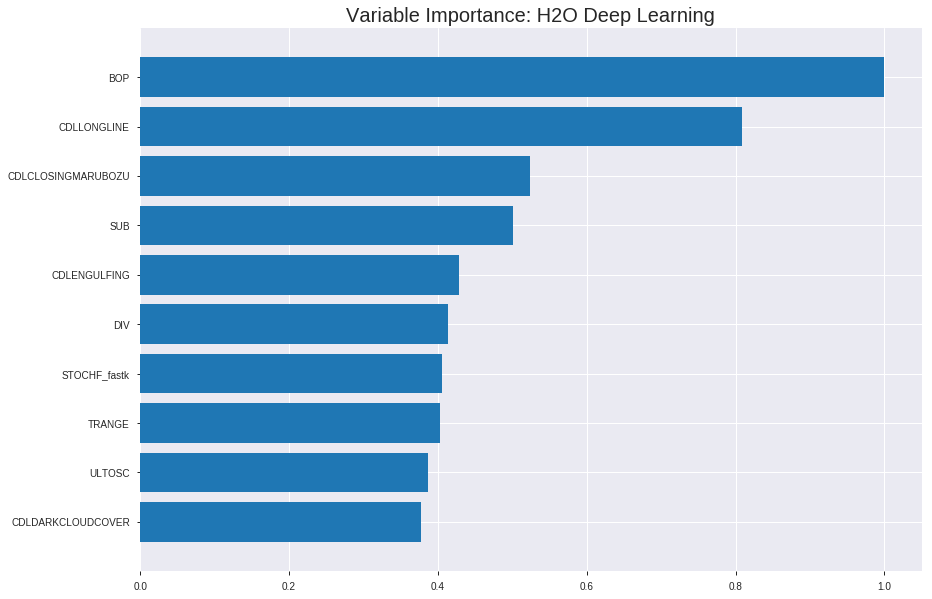

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_020157_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1879068954567505
RMSE: 0.43348228966908264
LogLoss: 0.5506788265551533
Mean Per-Class Error: 0.2889177575957169
AUC: 0.7937463959314215
pr_auc: 0.7974089122510029
Gini: 0.587492791862843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42570020758829696: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      372  475   0.5608   (475.0/847.0)
1      72   835   0.0794   (72.0/907.0)
Total  444  1310  0.3119   (547.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4257       0.75327   264
max f2                       0.373897     0.863869  291
max f0point5                 0.563098     0.732255  173
max accuracy                 0.505998     0.709806  211
max precision                0.999283     1         0
max recall                   0.0353582    1         385
max specificity              0.999283     1         0
max absolute_mcc             0.518693     0.423774  201
max min_per_class_accuracy   0.508236     0.696576  209
max mean_per_class_accuracy  0.518693     0.711082  201

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.989876           1.82641   1.82641            0.944444         0.994896  0.944444                    0.994896            0.0187431       0.0187431                  82.6412   82.6412
    2        0.0205245                   0.978421           1.93385   1.88013            1                0.983002  0.972222                    0.988949            0.0198456       0.0385888                  93.3848   88.013
    3        0.0302166                   0.968099           1.70634   1.82438            0.882353         0.973935  0.943396                    0.984133            0.016538        0.0551268                  70.6336   82.4385
    4        0.0404789                   0.958466           1.82641   1.8249             0.944444         0.963255  0.943662                    0.97884             0.0187431       0.0738699                  82.6412   82.4899
    5        0.050171                    0.945986           1.93385   1.84595            1                0.950802  0.954545                    0.973423            0.0187431       0.092613                   93.3848   84.5946
    6        0.100342                    0.8553             1.73607   1.79101            0.897727         0.900749  0.926136                    0.937086            0.0871003       0.179713                   73.6068   79.1007
    7        0.149943                    0.785673           1.66711   1.75002            0.862069         0.820669  0.904943                    0.898576            0.0826902       0.262404                   66.711    75.0022
    8        0.200114                    0.709012           1.40643   1.66388            0.727273         0.747331  0.860399                    0.860657            0.0705623       0.332966                   40.6435   66.388
    9        0.299886                    0.594785           1.44762   1.59193            0.748571         0.648563  0.823194                    0.790093            0.144432        0.477398                   44.7623   59.1932
    10       0.400228                    0.542939           1.15372   1.48207            0.596591         0.563449  0.766382                    0.733271            0.115766        0.593164                   15.3716   48.2066
    11       0.517674                    0.508233           1.0608    1.38649            0.548544         0.519443  0.71696                     0.684759            0.124587        0.717751                   6.08      38.6492
    12       0.599772                    0.485195           0.940065  1.32538            0.486111         0.496211  0.685361                    0.658951            0.0771775       0.794928                   -5.99351  32.5384
    13       0.700114                    0.448585           0.868034  1.25984            0.448864         0.466871  0.651466                    0.631421            0.0871003       0.882029                   -13.1966  25.9836
    14       0.799886                    0.391093           0.707236  1.19091            0.365714         0.421614  0.615823                    0.605251            0.0705623       0.952591                   -29.2764  19.0908
    15       0.899658                    0.274018           0.342567  1.09683            0.177143         0.346172  0.567174                    0.57652             0.0341786       0.98677                    -65.7433  9.68275
    16       1                           0.00074601         0.131853  1                  0.0681818        0.100183  0.517104                    0.528723           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20333116353878833
RMSE: 0.450922569338449
LogLoss: 0.5965843331578365
Mean Per-Class Error: 0.3247432529257225
AUC: 0.7481729161690949
pr_auc: 0.7757733758113107
Gini: 0.49634583233818974
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47700568047623637: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  134  0.5654   (134.0/237.0)
1      30   235  0.1132   (30.0/265.0)
Total  133  369  0.3267   (164.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477006     0.741325  280
max f2                       0.252953     0.858553  359
max f0point5                 0.604552     0.700104  158
max accuracy                 0.502052     0.683267  251
max precision                0.998871     1         0
max recall                   0.000159734  1         399
max specificity              0.998871     1         0
max absolute_mcc             0.502052     0.367697  251
max min_per_class_accuracy   0.528025     0.65283   217
max mean_per_class_accuracy  0.502052     0.675257  251

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 55.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.991811           1.89434   1.89434            1                0.994917  1                           0.994917            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.984706           1.89434   1.89434            1                0.987247  1                           0.991431            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.975401           1.89434   1.89434            1                0.978848  1                           0.987499            0.0188679       0.0603774                  89.434    89.434
    4        0.0418327                   0.965981           1.89434   1.89434            1                0.970183  1                           0.983376            0.0188679       0.0792453                  89.434    89.434
    5        0.0517928                   0.957801           1.89434   1.89434            1                0.961858  1                           0.979238            0.0188679       0.0981132                  89.434    89.434
    6        0.101594                    0.881072           1.66702   1.78291            0.88             0.913639  0.941176                    0.947082            0.0830189       0.181132                   66.7019   78.2908
    7        0.151394                    0.787435           1.51547   1.69494            0.8              0.827723  0.894737                    0.907819            0.0754717       0.256604                   51.5472   69.4935
    8        0.201195                    0.731673           1.36392   1.613              0.72             0.759109  0.851485                    0.871009            0.0679245       0.324528                   36.3925   61.3002
    9        0.300797                    0.635712           1.17449   1.4678             0.62             0.689815  0.774834                    0.811011            0.116981        0.441509                   17.4491   46.78
    10       0.400398                    0.570425           1.21238   1.40426            0.64             0.603574  0.741294                    0.75941             0.120755        0.562264                   21.2377   40.4262
    11       0.5                         0.529018           0.871396  1.29811            0.46             0.547441  0.685259                    0.717185            0.0867925       0.649057                   -12.8604  29.8113
    12       0.629482                    0.508233           1.07832   1.2529             0.569231         0.51605   0.661392                    0.675812            0.139623        0.788679                   7.83164   25.2902
    13       0.699203                    0.486079           0.865984  1.21432            0.457143         0.497561  0.641026                    0.658038            0.0603774       0.849057                   -13.4016  21.432
    14       0.798805                    0.439449           0.719849  1.15267            0.38             0.468282  0.608479                    0.634378            0.0716981       0.920755                   -28.0151  15.2666
    15       0.898406                    0.294309           0.530415  1.08368            0.28             0.375011  0.572062                    0.605623            0.0528302       0.973585                   -46.9585  8.36799
    16       1                           0.00013229         0.260007  1                  0.137255         0.141326  0.527888                    0.558453            0.026


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:21:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:21:28  3 min 12.729 sec  244 obs/sec       0.22691   1             398        0.599458         1.28644             -0.439086      0.52953         0.544837           1.28923          0.482896                         0.636319           1.55442               -0.624663        0.531152          0.551891             0.94717            0.472112
    2019-09-03 02:21:57  3 min 41.968 sec  330 obs/sec       5.28449   22            9269       0.499212         0.691569            0.00198074     0.564493        0.574565           1.5041           0.447548                         0.497598           0.688343              0.00649407       0.62987           0.63677              1.57862            0.424303
    2019-09-03 02:22:26  4 min 10.834 sec  358 obs/sec       11.0017   45            19297      0.487701         0.667124            0.0474775      0.641184        0.645552           1.61154          0.399088                         0.479821           0.650227              0.076214         0.694475          0.697918             1.57862            0.394422
    2019-09-03 02:22:58  4 min 42.106 sec  375 obs/sec       17.6323   72            30927      0.46888          0.62546             0.119576       0.738059        0.726095           1.82641          0.336374                         0.469795           0.628085              0.114416         0.737274          0.755162             1.89434            0.344622
    2019-09-03 02:23:26  5 min 10.911 sec  381 obs/sec       23.5336   96            41278      0.462404         0.614522            0.143729       0.754269        0.752612           1.82641          0.330673                         0.464884           0.61858               0.132833         0.741231          0.752862             1.89434            0.304781
    2019-09-03 02:23:55  5 min 40.287 sec  383 obs/sec       29.3746   120           51523      0.457881         0.602774            0.160399       0.775575        0.77511            1.93385          0.313569                         0.45726            0.612083              0.161044         0.755179          0.768345             1.89434            0.324701
    2019-09-03 02:24:28  6 min 12.659 sec  387 obs/sec       36.2452   148           63574      0.463803         0.614048            0.138538       0.756638        0.774512           1.93385          0.331243                         0.469485           0.636763              0.115585         0.706831          0.733486             1.89434            0.344622
    2019-09-03 02:24:57  6 min 41.693 sec  390 obs/sec       42.37     173           74317      0.433482         0.550679            0.247492       0.793746        0.797409           1.82641          0.311859                         0.450923           0.596584              0.184137         0.748173          0.775773             1.89434            0.326693
    2019-09-03 02:25:27

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.00880615802949685
CDLLONGLINE               0.8081390261650085     0.8081390261650085   0.007116599974212755
CDLCLOSINGMARUBOZU        0.5242354273796082     0.5242354273796082   0.0046165000181656495
SUB                       0.5004578828811646     0.5004578828811646   0.004407111203758961
CDLENGULFING              0.4284532964229584     0.4284532964229584   0.0037730274365594288
---                       ---                    ---                  ---
BBANDS_middleband_20_7_2  0.07521331310272217    0.07521331310272217  0.0006623403211045974
BBANDS_middleband_14_0_5  0.07469981908798218    0.07469981908798218  0.0006578184116635963
BBANDS_middleband_14_0_2  0.07386714965105057    0.07386714965105057  0.0006504857930156444
CDLCOUNTERATTACK          0.07178929448127747    0.07178929448127747  0.0006321878720282155
CDLXSIDEGAP3METHODS       0.06697782129049301    0.06697782129049301  0.0005898172787554801


See the whole table with table.as_data_frame()


('accuracy', 0.7051792828685259)

('F1', 0.7101449275362318)

('auc', 0.7631074168797953)

('logloss', 0.6033039426647077)

('mean_per_class_error', 0.3055306905370845)

('rmse', 0.457787730901251)

('mse', 0.20956960656371623)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


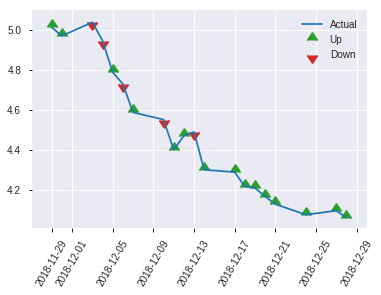


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20956960656371623
RMSE: 0.457787730901251
LogLoss: 0.6033039426647077
Mean Per-Class Error: 0.3055306905370845
AUC: 0.7631074168797953
pr_auc: 0.7313100187233229
Gini: 0.5262148337595907
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4817699812263255: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   63   0.4632   (63.0/136.0)
1      17   98   0.1478   (17.0/115.0)
Total  90   161  0.3187   (80.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48177      0.710145  152
max f2                       0.239686     0.822604  230
max f0point5                 0.610025     0.6974    76
max accuracy                 0.610025     0.705179  76
max precision                0.996492     1         0
max recall                   0.239686     1         230
max specificity              0.996492     1         0
max absolute_mcc             0.610025     0.411311  76
max min_per_class_accuracy   0.508233     0.661765  116
max mean_per_class_accuracy  0.48177      0.694469  152

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 55.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.995825           2.18261   2.18261            1                0.996202  1                           0.996202            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.983071           2.18261   2.18261            1                0.990103  1                           0.993152            0.026087        0.0521739                  118.261   118.261
    3        0.0318725                   0.968305           2.18261   2.18261            1                0.980491  1                           0.989987            0.0173913       0.0695652                  118.261   118.261
    4        0.0438247                   0.95329            2.18261   2.18261            1                0.956368  1                           0.980818            0.026087        0.0956522                  118.261   118.261
    5        0.0517928                   0.942132           1.0913    2.01472            0.5              0.944436  0.923077                    0.975221            0.00869565      0.104348                   9.13043   101.472
    6        0.103586                    0.862624           1.84682   1.93077            0.846154         0.899048  0.884615                    0.937134            0.0956522       0.2                        84.6823   93.0769
    7        0.151394                    0.793656           1.63696   1.83799            0.75             0.824954  0.842105                    0.901709            0.0782609       0.278261                   63.6957   83.7986
    8        0.203187                    0.722403           1.51104   1.75465            0.692308         0.748201  0.803922                    0.86258             0.0782609       0.356522                   51.1037   75.4646
    9        0.302789                    0.611671           1.48417   1.66568            0.68             0.653294  0.763158                    0.793736            0.147826        0.504348                   48.4174   66.5675
    10       0.40239                     0.549835           0.960348  1.49109            0.44             0.585378  0.683168                    0.742162            0.0956522       0.6                        -3.96522  49.1089
    11       0.501992                    0.507023           0.873043  1.36846            0.4              0.518541  0.626984                    0.697793            0.0869565       0.686957                   -12.6957  36.8461
    12       0.601594                    0.490041           1.13496   1.3298             0.52             0.497799  0.609272                    0.664681            0.113043        0.8                        13.4957   32.9801
    13       0.701195                    0.471842           0.785739  1.25252            0.36             0.480179  0.573864                    0.638473            0.0782609       0.878261                   -21.4261  25.252
    14       0.800797                    0.429262           0.523826  1.16189            0.24             0.44922   0.532338                    0.614934            0.0521739       0.930435                   -47.6174  16.1886
    15       0.900398                    0.384378           0.436522  1.08165            0.2              0.404299  0.495575                    0.591634            0.0434783       0.973913                   -56.3478  8.16468
    16       1                           0.0117773          0.261913  1                  0.12             0.226792  0.458167                    0.555295          

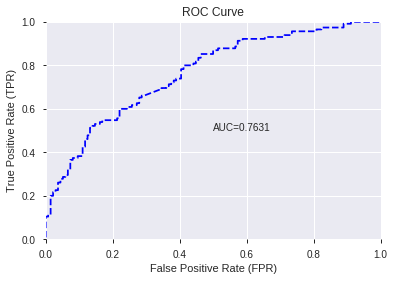

This function is available for GLM models only


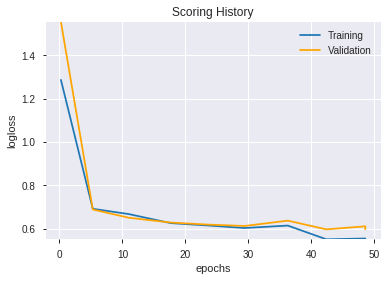

--2019-09-03 02:32:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  58.8MB/s    in 6.2s    

2019-09-03 02:32:30 (56.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_020157_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_020157_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_023240_model_8  0.765729  0.614695              0.281841  0.464267  0.215544
1  DeepLearning_grid_1_AutoML_20190903_023240_model_6  0.758951  0.601700              0.312884  0.456480  0.208374
2  DeepLearning_grid_1_AutoML_20190903_023240_model_5  0.752749  0.626452              0.306873  0.469570  0.220496
3  DeepLearning_grid_1_AutoML_20190903_023240_model_9  0.750767  0.609107              0.306873  0.459564  0.211199
4               DeepLearning_1_AutoML_20190903_023240  0.740281  0.637581              0.334942  0.471954  0.222740
5  DeepLearning_grid_1_AutoML_20190903_023240_model_3  0.704668  0.696368              0.358312  0.494119  0.244154
6  DeepLearning_grid_1_AutoML_20190903_023240_model_7  0.695524  0.758863              0.359655  0.497624  0.247629
7  DeepLearning_grid_1_AutoML_20190903_023240_model_2  0.694182  0.708843              0.335614  0.491681  0.241750
8  DeepLearning_grid_1_AutoML_20190903_023240_model_4  0.678197  0.850057              0.355339  0.527657  0.278421
9  DeepLearning_grid_1_AutoML_20190903_023240_model_1  0.676471  1.040915              0.344949  0.541474  0.293194

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.034266
1            CDLLONGLINE             0.869659           0.869659    0.029800
2                    day             0.762868           0.762868    0.026141
3             aroonup_30             0.736107           0.736107    0.025224
4     CDLCLOSINGMARUBOZU             0.724420           0.724420    0.024823
5                    SUB             0.723741           0.723741    0.024800
6         STOCHRSI_fastk             0.698850           0.698850    0.023947
7              CDLHAMMER             0.671743           0.671743    0.023018
8                 TRANGE             0.671287           0.671287    0.023003
9           HT_TRENDMODE             0.657654           0.657654    0.022535
10                   SIN             0.649864           0.649864    0.022268
11                   DIV             0.639244           0.639244    0.021905
12             dayofweek             0.625968           0.625968    0.021450
13         days_in_month             0.619852           0.619852    0.021240
14                   OBV             0.618042           0.618042    0.021178
15           CDLMARUBOZU             0.582185           0.582185    0.019949
16  HT_PHASOR_quadrature             0.582122           0.582122    0.019947
17               BETA_14             0.580678           0.580678    0.019898
18          aroondown_30             0.579054           0.579054    0.019842
19             aroonup_8             0.579032           0.579032    0.019841
20               weekday             0.569111           0.569111    0.019501
21          STOCHF_fastk             0.568508           0.568508    0.019481
22            PLUS_DI_24             0.561718           0.561718    0.019248
23                 ADOSC             0.556311           0.556311    0.019063
24             CDLTAKURI             0.556218           0.556218    0.019060
25           HT_DCPERIOD             0.553489           0.553489    0.018966
26     CDLDARKCLOUDCOVER             0.550481           0.550481    0.018863
27           AROONOSC_20             0.543689           0.543689    0.018630
28               BETA_12             0.543006           0.543006    0.018607
29           STOCH_slowd             0.542390           0.542390    0.018586
30          CDLENGULFING             0.538898           0.538898    0.018466
31         CDLHANGINGMAN             0.538656           0.538656    0.018458
32             CORREL_12             0.536792           0.536792    0.018394
33        CDLMORNINGSTAR             0.532113           0.532113    0.018234
34                BETA_8             0.531974           0.531974    0.018229
35              CORREL_8             0.528890           0.528890    0.018123
36           STOCH_slowk             0.527903           0.527903    0.018089
37             PLUS_DI_8             0.524742           0.524742    0.017981
38                ULTOSC             0.517983           0.517983    0.017749
39     CDLGRAVESTONEDOJI             0.517840           0.517840    0.017745
40          is_month_end             0.509264           0.509264    0.017451
41            CDLHIKKAKE             0.501349           0.501349    0.017179
42        is_quarter_end             0.493251           0.493251    0.016902
43          STOCHF_fastd             0.492004           0.492004    0.016859
44      CDLDRAGONFLYDOJI             0.490338           0.490338    0.016802
45        CDLRICKSHAWMAN             0.476222           0.476222    0.016318
46              WILLR_14             0.473211           0.473211    0.016215
47              WILLR_20             0.465395           0.465395    0.015947
48               WILLR_8             0.443981           0.443981    0.015214
49           CDLBELTHOLD             0.425007           0.425007    0.014563

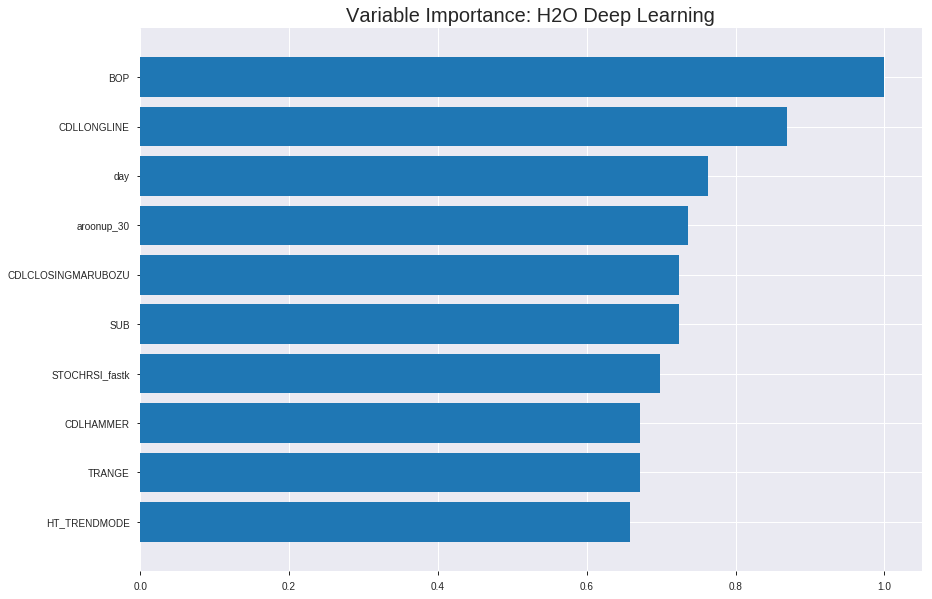

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_023240_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18683274640947053
RMSE: 0.43224153711723556
LogLoss: 0.5508201265304937
Mean Per-Class Error: 0.26959148899611973
AUC: 0.7981122816243593
pr_auc: 0.7907860877079957
Gini: 0.5962245632487186
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5013522279377228: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      466  381   0.4498   (381.0/847.0)
1      104  803   0.1147   (104.0/907.0)
Total  570  1184  0.2765   (485.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501352     0.768054  219
max f2                       0.222782     0.861801  325
max f0point5                 0.57086      0.735326  176
max accuracy                 0.554602     0.733181  188
max precision                0.981752     1         0
max recall                   0.0575502    1         382
max specificity              0.981752     1         0
max absolute_mcc             0.552579     0.46876   190
max min_per_class_accuracy   0.576671     0.716647  171
max mean_per_class_accuracy  0.554602     0.730409  188

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 52.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.947043           1.93385   1.93385            1                0.958617   1                           0.958617            0.0198456       0.0198456                  93.3848   93.3848
    2        0.0205245                   0.934486           1.61154   1.77269            0.833333         0.940023   0.916667                    0.94932             0.016538        0.0363837                  61.154    77.2694
    3        0.0302166                   0.907231           1.93385   1.82438            1                0.921059   0.943396                    0.940255            0.0187431       0.0551268                  93.3848   82.4385
    4        0.0404789                   0.882309           1.82641   1.8249             0.944444         0.895474   0.943662                    0.928902            0.0187431       0.0738699                  82.6412   82.4899
    5        0.050171                    0.858725           1.70634   1.80199            0.882353         0.867763   0.931818                    0.917091            0.016538        0.0904079                  70.6336   80.1995
    6        0.100342                    0.777091           1.62619   1.71409            0.840909         0.818664   0.886364                    0.867877            0.0815877       0.171996                   62.619    71.4092
    7        0.149943                    0.707616           1.5782    1.66914            0.816092         0.739524   0.863118                    0.825418            0.07828         0.250276                   57.8198   66.9139
    8        0.200114                    0.671458           1.56026   1.64184            0.806818         0.687364   0.849003                    0.790806            0.07828         0.328556                   56.0264   64.1842
    9        0.299886                    0.629317           1.35922   1.54781            0.702857         0.647054   0.80038                     0.74298             0.135612        0.464168                   35.9219   54.7814
    10       0.400228                    0.606778           1.25261   1.4738             0.647727         0.617401   0.762108                    0.711496            0.125689        0.589857                   25.2606   47.3801
    11       0.5                         0.578449           1.20451   1.42007            0.622857         0.592821   0.734322                    0.687815            0.120176        0.710033                   20.4511   42.0066
    12       0.599772                    0.551298           1.09401   1.36583            0.565714         0.565293   0.706274                    0.667434            0.109151        0.819184                   9.40054   36.5826
    13       0.700114                    0.480726           0.780132  1.28188            0.403409         0.519028   0.662866                    0.646164            0.07828         0.897464                   -21.9868  28.1883
    14       0.799886                    0.344058           0.574629  1.19367            0.297143         0.417607   0.617249                    0.617655            0.0573319       0.954796                   -42.5371  19.3665
    15       0.899658                    0.17705            0.331517  1.09805            0.171429         0.257235   0.567807                    0.577685            0.0330761       0.987872                   -66.8483  9.8053
    16       1                           0.00145439         0.120865  1                  0.0625           0.0946887  0.517104                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2008826888844596
RMSE: 0.4481993851897385
LogLoss: 0.5804892395551597
Mean Per-Class Error: 0.30894833213916084
AUC: 0.7558315420746755
pr_auc: 0.7754567357319598
Gini: 0.511663084149351
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4933725851001363: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      101  136  0.5738   (136.0/237.0)
1      28   237  0.1057   (28.0/265.0)
Total  129  373  0.3267   (164.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493373     0.742947  278
max f2                       0.329369     0.868403  339
max f0point5                 0.604412     0.710764  180
max accuracy                 0.594341     0.691235  190
max precision                0.962623     1         0
max recall                   0.136992     1         381
max specificity              0.962623     1         0
max absolute_mcc             0.594341     0.381657  190
max min_per_class_accuracy   0.596226     0.687764  189
max mean_per_class_accuracy  0.594341     0.691052  190

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 55.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.939012           1.89434   1.89434            1                0.948226  1                           0.948226            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.924694           1.89434   1.89434            1                0.929158  1                           0.939559            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.897869           1.89434   1.89434            1                0.905241  1                           0.928834            0.0188679       0.0603774                  89.434    89.434
    4        0.0418327                   0.849529           1.89434   1.89434            1                0.873576  1                           0.915678            0.0188679       0.0792453                  89.434    89.434
    5        0.0517928                   0.836139           1.89434   1.89434            1                0.839901  1                           0.901105            0.0188679       0.0981132                  89.434    89.434
    6        0.101594                    0.759221           1.59125   1.74576            0.84             0.799205  0.921569                    0.851154            0.0792453       0.177358                   59.1245   74.5764
    7        0.151394                    0.718072           1.59125   1.69494            0.84             0.734689  0.894737                    0.812843            0.0792453       0.256604                   59.1245   69.4935
    8        0.201195                    0.673702           1.1366    1.55673            0.6              0.691521  0.821782                    0.782813            0.0566038       0.313208                   13.6604   55.6735
    9        0.300797                    0.630838           1.36392   1.49289            0.72             0.646899  0.788079                    0.737808            0.135849        0.449057                   36.3925   49.289
    10       0.400398                    0.61376            1.1366    1.40426            0.6              0.621733  0.741294                    0.708934            0.113208        0.562264                   13.6604   40.4262
    11       0.5                         0.598463           1.09872   1.3434             0.58             0.607393  0.709163                    0.688707            0.109434        0.671698                   9.8717    34.3396
    12       0.599602                    0.571107           0.833509  1.2587             0.44             0.5841    0.664452                    0.67133             0.0830189       0.754717                   -16.6491  25.8697
    13       0.699203                    0.533024           0.871396  1.20353            0.46             0.556059  0.635328                    0.65491             0.0867925       0.841509                   -12.8604  20.3526
    14       0.798805                    0.430765           0.871396  1.16211            0.46             0.481567  0.613466                    0.633296            0.0867925       0.928302                   -12.8604  16.2114
    15       0.898406                    0.247485           0.530415  1.09208            0.28             0.352558  0.576497                    0.602172            0.0528302       0.981132                   -46.9585  9.20805
    16       1                           0.0118133          0.18572   1                  0.0980392        0.14184   0.527888                    0.555405            0.0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:38:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:38:13  1 min 12.113 sec  615 obs/sec       0.542759  1             952        0.495632         0.723976            0.0162428      0.72701         0.702071           1.61154          0.355188                         0.487871           0.688131              0.0449583        0.718597          0.713213             1.57862            0.364542
    2019-09-03 02:38:23  1 min 22.307 sec  1086 obs/sec      6.68472   12            11725      0.438535         0.565006            0.229849       0.789514        0.783575           1.93385          0.290764                         0.449867           0.586449              0.187952         0.758833          0.779512             1.89434            0.338645
    2019-09-03 02:38:33  1 min 31.896 sec  1220 obs/sec      13.5046   24            23687      0.432242         0.55082             0.251793       0.798112        0.790786           1.93385          0.276511                         0.448199           0.580489              0.193962         0.755832          0.775457             1.89434            0.326693
    2019-09-03 02:38:42  1 min 41.726 sec  1290 obs/sec      20.7948   37            36474      0.426075         0.536789            0.272991       0.812874        0.802494           1.93385          0.276511                         0.451716           0.587568              0.181265         0.758395          0.776421             1.89434            0.338645
    2019-09-03 02:38:53  1 min 51.852 sec  1343 obs/sec      28.6448   51            50243      0.418652         0.520373            0.298101       0.830062        0.81826            1.93385          0.246864                         0.457923           0.598254              0.158609         0.7442            0.767733             1.89434            0.342629
    2019-09-03 02:39:03  2 min  1.979 sec  1373 obs/sec      36.4601   65            63951      0.403638         0.487832            0.347541       0.852026        0.842598           1.93385          0.222919                         0.45861            0.606209              0.156084         0.729727          0.754248             1.89434            0.344622
    2019-09-03 02:39:13  2 min 11.967 sec  1401 obs/sec      44.3865   79            77854      0.386996         0.453999            0.400235       0.876707        0.872207           1.93385          0.213797                         0.454787           0.598141              0.170093         0.73967           0.744988             1.89434            0.326693
    2019-09-03 02:39:14  2 min 12.981 sec  1400 obs/sec      44.3865   79            77854      0.432242         0.55082             0.251793       0.798112        0.790786           1.93385          0.276511                         0.448199           0.580489              0.193962         0.755832          0.775457             1.89434            0.326693

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03426640658028919
CDLLONGLINE         0.8696587085723877     0.8696587085723877   0.029800078894030663
day                 0.7628675699234009     0.7628675699234009   0.026140730317912447
aroonup_30          0.7361065745353699     0.7361065745353699   0.025223727169452932
CDLCLOSINGMARUBOZU  0.7244200110435486     0.7244200110435486   0.024823270633315818
---                 ---                    ---                  ---
CDLRICKSHAWMAN      0.47622188925743103    0.47622188925743103  0.016318412879728583
WILLR_14            0.47321054339408875    0.47321054339408875  0.016215224878021423
WILLR_20            0.4653947949409485     0.4653947949409485   0.015947407263796853
WILLR_8             0.44398069381713867    0.44398069381713867  0.015213622968136959
CDLBELTHOLD         0.42500683665275574    0.42500683665275574  0.014563457064145881


See the whole table with table.as_data_frame()


('accuracy', 0.7171314741035857)

('F1', 0.702928870292887)

('auc', 0.7657289002557546)

('logloss', 0.6146947010672997)

('mean_per_class_error', 0.28184143222506397)

('rmse', 0.4642666972925964)

('mse', 0.21554356621497534)

deeplearning prediction progress: |███████████████████████████████████████| 100%


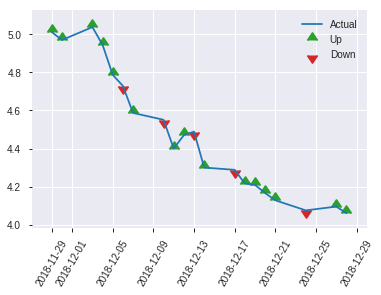


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21554356621497534
RMSE: 0.4642666972925964
LogLoss: 0.6146947010672997
Mean Per-Class Error: 0.28184143222506397
AUC: 0.7657289002557546
pr_auc: 0.709786593813712
Gini: 0.5314578005115091
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6090949736205089: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      96   40   0.2941   (40.0/136.0)
1      31   84   0.2696   (31.0/115.0)
Total  127  124  0.2829   (71.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.609095     0.702929  123
max f2                       0.30235      0.834543  228
max f0point5                 0.609584     0.688226  121
max accuracy                 0.609584     0.717131  121
max precision                0.94843      1         0
max recall                   0.30235      1         228
max specificity              0.94843      1         0
max absolute_mcc             0.609095     0.434818  123
max min_per_class_accuracy   0.609584     0.713235  121
max mean_per_class_accuracy  0.609095     0.718159  123

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 56.60 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.940135           2.18261    2.18261            1                0.946745  1                           0.946745            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.870417           1.45507    1.81884            0.666667         0.911671  0.833333                    0.929208            0.0173913       0.0434783                  45.5072   81.8841
    3        0.0318725                   0.858055           2.18261    1.90978            1                0.865676  0.875                       0.913325            0.0173913       0.0608696                  118.261   90.9783
    4        0.0438247                   0.837606           1.45507    1.78577            0.666667         0.843781  0.818182                    0.894358            0.0173913       0.0782609                  45.5072   78.5771
    5        0.0517928                   0.813378           2.18261    1.84682            1                0.82617   0.846154                    0.883868            0.0173913       0.0956522                  118.261   84.6823
    6        0.103586                    0.746336           1.67893    1.76288            0.769231         0.764147  0.807692                    0.824007            0.0869565       0.182609                   67.893    76.2876
    7        0.151394                    0.693006           1.63696    1.72311            0.75             0.722829  0.789474                    0.792057            0.0782609       0.26087                    63.6957   72.3112
    8        0.203187                    0.674015           1.51104    1.66905            0.692308         0.679259  0.764706                    0.763304            0.0782609       0.33913                    51.1037   66.9054
    9        0.302789                    0.633157           1.39687    1.57952            0.64             0.650909  0.723684                    0.726332            0.13913         0.478261                   39.687    57.9519
    10       0.40239                     0.616703           1.30957    1.5127             0.6              0.623289  0.693069                    0.700826            0.130435        0.608696                   30.9565   51.2699
    11       0.501992                    0.60782            1.22226    1.45507            0.56             0.613022  0.666667                    0.683405            0.121739        0.730435                   22.2261   45.5072
    12       0.601594                    0.582788           0.785739   1.34426            0.36             0.593832  0.615894                    0.668575            0.0782609       0.808696                   -21.4261  34.4256
    13       0.701195                    0.557037           0.61113    1.24012            0.28             0.568683  0.568182                    0.654386            0.0608696       0.869565                   -38.887   24.0119
    14       0.800797                    0.458411           0.785739   1.1836             0.36             0.517028  0.542289                    0.637301            0.0782609       0.947826                   -21.4261  18.3604
    15       0.900398                    0.323277           0.436522   1.10096            0.2              0.37977   0.504425                    0.608813            0.0434783       0.991304                   -56.3478  10.0962
    16       1                           0.031466           0.0873043  1                  0.04             0.178939  0.458167                   

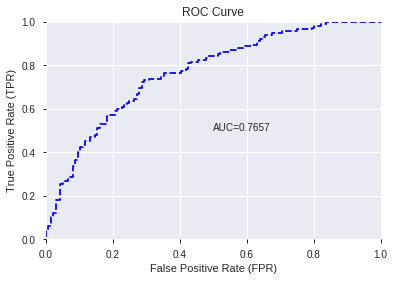

This function is available for GLM models only


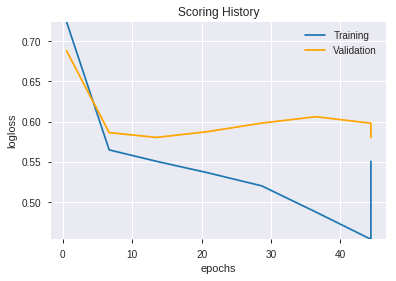

--2019-09-03 02:40:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_023240_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_023240_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLLONGLINE',
 'day',
 'aroonup_30',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'TRANGE',
 'HT_TRENDMODE',
 'SIN',
 'DIV',
 'dayofweek',
 'days_in_month',
 'OBV',
 'CDLMARUBOZU',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'aroondown_30',
 'aroonup_8',
 'weekday',
 'STOCHF_fastk',
 'PLUS_DI_24',
 'ADOSC',
 'CDLTAKURI',
 'HT_DCPERIOD',
 'CDLDARKCLOUDCOVER',
 'AROONOSC_20',
 'BETA_12',
 'STOCH_slowd',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'CORREL_12',
 'CDLMORNINGSTAR',
 'BETA_8',
 'CORREL_8',
 'STOCH_slowk',
 'PLUS_DI_8',
 'ULTOSC',
 'CDLGRAVESTONEDOJI',
 'is_month_end',
 'CDLHIKKAKE',
 'is_quarter_end',
 'STOCHF_fastd',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'WILLR_14',
 'WILLR_20',
 'WILLR_8',
 'CDLBELTHOLD']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_024031_model_1  0.758504  0.609797              0.292839  0.460003  0.211603

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.437024           1.000000    0.105136
1            CDLLONGLINE             0.236139           0.540334    0.056809
2                    SUB             0.185673           0.424858    0.044668
3           STOCHF_fastk             0.184314           0.421747    0.044341
4             aroonup_30             0.146985           0.336332    0.035361
5      CDLDARKCLOUDCOVER             0.141243           0.323193    0.033979
6            STOCH_slowd             0.134265           0.307225    0.032300
7              CDLHAMMER             0.127933           0.292737    0.030777
8     CDLCLOSINGMARUBOZU             0.127790           0.292409    0.030743
9      CDLGRAVESTONEDOJI             0.123032           0.281521    0.029598
10                TRANGE             0.122061           0.279300    0.029365
11                ULTOSC             0.115650           0.264632    0.027822
12             PLUS_DI_8             0.106529           0.243760    0.025628
13             aroonup_8             0.102471           0.234474    0.024652
14            PLUS_DI_24             0.095937           0.219524    0.023080
15        is_quarter_end             0.094694           0.216678    0.022781
16                   DIV             0.092264           0.211120    0.022196
17                   OBV             0.091941           0.210380    0.022118
18                 ADOSC             0.090778           0.207719    0.021839
19             CDLTAKURI             0.089974           0.205878    0.021645
20                   SIN             0.082520           0.188823    0.019852
21               BETA_14             0.077762           0.177935    0.018707
22         CDLHANGINGMAN             0.074051           0.169443    0.017815
23             CORREL_12             0.066246           0.151585    0.015937
24            CDLHIKKAKE             0.064679           0.147998    0.015560
25             dayofweek             0.064117           0.146712    0.015425
26               weekday             0.064007           0.146460    0.015398
27                BETA_8             0.064000           0.146446    0.015397
28           AROONOSC_20             0.062042           0.141965    0.014926
29          aroondown_30             0.061629           0.141019    0.014826
30  HT_PHASOR_quadrature             0.059558           0.136281    0.014328
31               WILLR_8             0.056841           0.130063    0.013674
32          CDLENGULFING             0.055147           0.126188    0.013267
33          STOCHF_fastd             0.051729           0.118366    0.012445
34           STOCH_slowk             0.050861           0.116381    0.012236
35        CDLMORNINGSTAR             0.048630           0.111276    0.011699
36          is_month_end             0.046154           0.105610    0.011103
37        STOCHRSI_fastk             0.041580           0.095144    0.010003
38               BETA_12             0.034070           0.077959    0.008196
39          HT_TRENDMODE             0.032897           0.075275    0.007914
40         days_in_month             0.030870           0.070637    0.007426
41              WILLR_14             0.029079           0.066538    0.006996
42              CORREL_8             0.027918           0.063882    0.006716
43           CDLBELTHOLD             0.016055           0.036738    0.003862
44      CDLDRAGONFLYDOJI             0.011541           0.026407    0.002776
45              WILLR_20             0.010881           0.024898    0.002618
46                   day             0.008447           0.019329    0.002032
47           HT_DCPERIOD             0.007588           0.017363    0.001825
48           CDLMARUBOZU             0.005693           0.013026    0.001370
49        CDLRICKSHAWMAN             0.003461           0.007920    0.000833

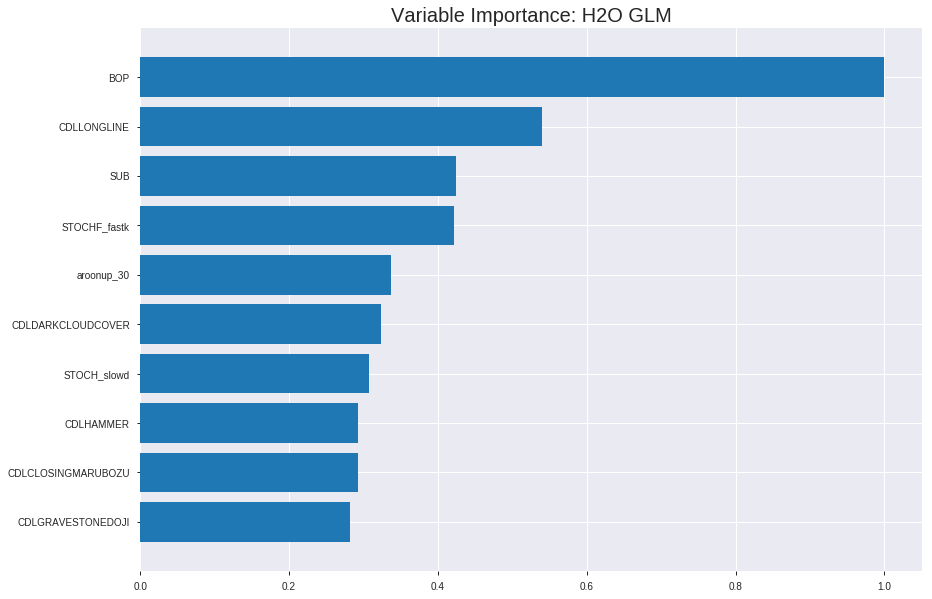

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_024031_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19050654776402748
RMSE: 0.43647055772872867
LogLoss: 0.5627782569018401
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2429.507457396468
Residual deviance: 1974.2261252116555
AIC: 2076.2261252116555
AUC: 0.7820994781503953
pr_auc: 0.7701140198585543
Gini: 0.5641989563007905
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.401604219195454: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      437  410   0.4841   (410.0/847.0)
1      115  792   0.1268   (115.0/907.0)
Total  552  1202  0.2993   (525.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401604     0.751067  256
max f2                       0.270071     0.857367  316
max f0point5                 0.524153     0.729144  194
max accuracy                 0.515996     0.720639  198
max precision                0.947115     1         0
max recall                   0.060933     1         396
max specificity              0.947115     1         0
max absolute_mcc             0.515996     0.440263  198
max min_per_class_accuracy   0.527316     0.713105  192
max mean_per_class_accuracy  0.515996     0.719843  198

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.911596           1.71898   1.71898            0.888889         0.927588  0.888889                    0.927588            0.0176406       0.0176406                  71.8976   71.8976
    2        0.0205245                   0.890802           1.71898   1.71898            0.888889         0.900708  0.888889                    0.914148            0.0176406       0.0352811                  71.8976   71.8976
    3        0.0302166                   0.879479           1.59258   1.67843            0.823529         0.885781  0.867925                    0.905049            0.0154355       0.0507166                  59.2581   67.8434
    4        0.0404789                   0.867185           1.61154   1.66147            0.833333         0.874341  0.859155                    0.897264            0.016538        0.0672547                  61.154    66.1475
    5        0.050171                    0.85706            1.70634   1.67014            0.882353         0.861523  0.863636                    0.890359            0.016538        0.0837927                  70.6336   67.0141
    6        0.100342                    0.803327           1.78002   1.72508            0.920455         0.828538  0.892045                    0.859449            0.0893054       0.173098                   78.0019   72.508
    7        0.149943                    0.764141           1.5782    1.67649            0.816092         0.783409  0.86692                     0.834295            0.07828         0.251378                   57.8198   67.6492
    8        0.200114                    0.724271           1.49434   1.63082            0.772727         0.746585  0.843305                    0.812305            0.0749724       0.326351                   49.4337   63.0823
    9        0.299886                    0.654399           1.33712   1.53311            0.691429         0.687437  0.792776                    0.770761            0.133407        0.459757                   33.7118   53.3108
    10       0.400228                    0.591917           1.29656   1.4738             0.670455         0.622992  0.762108                    0.733714            0.130099        0.589857                   29.6557   47.3801
    11       0.5                         0.531509           1.14926   1.40904            0.594286         0.563883  0.72862                     0.699825            0.114664        0.70452                    14.9258   40.9041
    12       0.599772                    0.470138           0.939298  1.3309             0.485714         0.503842  0.688213                    0.667223            0.0937155       0.798236                   -6.07025  33.0899
    13       0.700114                    0.391997           0.802107  1.25511            0.414773         0.429884  0.649023                    0.633207            0.0804851       0.878721                   -19.7893  25.5111
    14       0.799886                    0.310481           0.651983  1.17988            0.337143         0.350901  0.610121                    0.597994            0.0650496       0.943771                   -34.8017  17.9882
    15       0.899658                    0.198164           0.353618  1.08825            0.182857         0.253836  0.562738                    0.559827            0.0352811       0.979052                   -64.6382  8.8249
    16       1                           0.0241016          0.208768  1                  0.107955         0.13405   0.517104                    0.517104           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19228974806003024
RMSE: 0.4385085495860146
LogLoss: 0.5636909202195802
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 694.5911617977604
Residual deviance: 565.9456839004586
AIC: 667.9456839004586
AUC: 0.780049359127458
pr_auc: 0.7993821117120615
Gini: 0.560098718254916
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3754851381577093: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   151  0.6371   (151.0/237.0)
1      17   248  0.0642   (17.0/265.0)
Total  103  399  0.3347   (168.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375485     0.746988  309
max f2                       0.24722      0.866976  355
max f0point5                 0.589422     0.739857  184
max accuracy                 0.589422     0.719124  184
max precision                0.941093     1         0
max recall                   0.0904897    1         396
max specificity              0.941093     1         0
max absolute_mcc             0.589422     0.439629  184
max min_per_class_accuracy   0.584526     0.709434  189
max mean_per_class_accuracy  0.589422     0.720142  184

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 55.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.912317           1.89434   1.89434            1                0.920849  1                           0.920849            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.906266           1.89434   1.89434            1                0.90929   1                           0.915595            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.901055           1.89434   1.89434            1                0.903195  1                           0.91172             0.0188679       0.0603774                  89.434    89.434
    4        0.0418327                   0.884773           1.89434   1.89434            1                0.88989   1                           0.906522            0.0188679       0.0792453                  89.434    89.434
    5        0.0517928                   0.871153           1.89434   1.89434            1                0.875964  1                           0.900646            0.0188679       0.0981132                  89.434    89.434
    6        0.101594                    0.823651           1.4397    1.67148            0.76             0.844861  0.882353                    0.8733              0.0716981       0.169811                   43.9698   67.1476
    7        0.151394                    0.780793           1.81857   1.71986            0.96             0.79977   0.907895                    0.849113            0.090566        0.260377                   81.8566   71.9861
    8        0.201195                    0.736698           1.51547   1.66927            0.8              0.75655   0.881188                    0.826201            0.0754717       0.335849                   51.5472   66.927
    9        0.300797                    0.686983           1.32604   1.55562            0.7              0.712711  0.821192                    0.788622            0.132075        0.467925                   32.6038   55.5617
    10       0.400398                    0.636227           1.06083   1.43254            0.56             0.658954  0.756219                    0.756366            0.10566         0.573585                   6.08302   43.2535
    11       0.5                         0.586662           1.32604   1.41132            0.7              0.610425  0.74502                     0.727294            0.132075        0.70566                    32.6038   41.1321
    12       0.599602                    0.519628           0.833509  1.31534            0.44             0.554263  0.694352                    0.698551            0.0830189       0.788679                   -16.6491  31.5339
    13       0.699203                    0.449964           0.644075  1.21972            0.34             0.486657  0.643875                    0.668367            0.0641509       0.85283                    -35.5925  21.9717
    14       0.798805                    0.370989           0.833509  1.17156            0.44             0.41425   0.618454                    0.636682            0.0830189       0.935849                   -16.6491  17.1562
    15       0.898406                    0.239654           0.530415  1.10048            0.28             0.303984  0.580931                    0.599797            0.0528302       0.988679                   -46.9585  10.0481
    16       1                           0.0693201          0.111432  1                  0.0588235        0.168001  0.527888                    0.555929            0.0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:40:32  0.000 sec   2            21        51            1.36652           1.36421
    2019-09-03 02:40:32  0.029 sec   4            13        51            1.35682           1.35404
    2019-09-03 02:40:32  0.052 sec   6            8         51            1.34318           1.33969
    2019-09-03 02:40:32  0.086 sec   8            4.9       51            1.32504           1.32054
    2019-09-03 02:40:32  0.125 sec   10           3.1       51            1.30243           1.29658
    2019-09-03 02:40:32  0.158 sec   12           1.9       51            1.27618           1.26867
    2019-09-03 02:40:32  0.193 sec   14           1.2       51            1.24805           1.23875
    2019-09-03 02:40:32  0.225 sec   16           0.74      51            1.2202            1.20923
    2019-09-03 02:40:32  0.257 sec   18           0.46      51            1.19477           1.18265
    2019-09-03 02:40:32  0.299 sec   20           0.28      51            1.17317           1.16091
    2019-09-03 02:40:32  0.320 sec   22           0.18      51            1.15591           1.1449
    2019-09-03 02:40:32  0.346 sec   24           0.11      51            1.14271           1.13454
    2019-09-03 02:40:32  0.365 sec   26           0.068     51            1.13288           1.12906
    2019-09-03 02:40:32  0.384 sec   28           0.042     51            1.12556           1.12738
    2019-09-03 02:40:32  0.404 sec   30           0.026     51            1.11996           1.12857
    2019-09-03 02:40:32  0.438 sec   32           0.016     51            1.11555           1.13192
    2019-09-03 02:40:32  0.465 sec   34           0.01      51            1.11205           1.13682
    2019-09-03 02:40:32  0.490 sec   36           0.0063    51            1.10934           1.14284
    2019-09-03 02:40:32  0.517 sec   38           0.0039    51            1.10738           1.14936

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7142857142857143)

('auc', 0.7585038363171356)

('logloss', 0.6097973540687449)

('mean_per_class_error', 0.2928388746803069)

('rmse', 0.46000283342665754)

('mse', 0.21160260676055323)

glm prediction progress: |████████████████████████████████████████████████| 100%


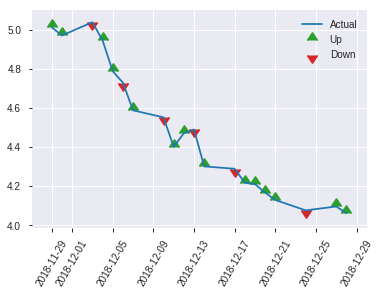


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21160260676055323
RMSE: 0.46000283342665754
LogLoss: 0.6097973540687449
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 349.69104234008756
Residual deviance: 306.11827174251
AIC: 408.11827174251
AUC: 0.7585038363171356
pr_auc: 0.7120763391095958
Gini: 0.5170076726342712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5480937597939304: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   56   0.4118   (56.0/136.0)
1      20   95   0.1739   (20.0/115.0)
Total  100  151  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.548094     0.714286  150
max f2                       0.325305     0.825893  211
max f0point5                 0.641714     0.675676  109
max accuracy                 0.641714     0.701195  109
max precision                0.930737     1         0
max recall                   0.138931     1         243
max specificity              0.930737     1         0
max absolute_mcc             0.548094     0.421666  150
max min_per_class_accuracy   0.615224     0.691176  121
max mean_per_class_accuracy  0.548094     0.707161  150

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 56.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.921585           2.18261   2.18261            1                0.927601  1                           0.927601            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.911811           1.45507   1.81884            0.666667         0.916848  0.833333                    0.922225            0.0173913       0.0434783                  45.5072   81.8841
    3        0.0318725                   0.894767           2.18261   1.90978            1                0.901547  0.875                       0.917055            0.0173913       0.0608696                  118.261   90.9783
    4        0.0438247                   0.883476           1.45507   1.78577            0.666667         0.886923  0.818182                    0.908837            0.0173913       0.0782609                  45.5072   78.5771
    5        0.0517928                   0.871137           2.18261   1.84682            1                0.874724  0.846154                    0.903589            0.0173913       0.0956522                  118.261   84.6823
    6        0.103586                    0.825234           2.01472   1.93077            0.923077         0.844218  0.884615                    0.873903            0.104348        0.2                        101.472   93.0769
    7        0.151394                    0.79377            1.81884   1.89542            0.833333         0.804978  0.868421                    0.852138            0.0869565       0.286957                   81.8841   89.5423
    8        0.203187                    0.743063           0.839465  1.62626            0.384615         0.770505  0.745098                    0.831329            0.0434783       0.330435                   -16.0535  62.6257
    9        0.302789                    0.698704           1.22226   1.49336            0.56             0.716465  0.684211                    0.793545            0.121739        0.452174                   22.2261   49.3364
    10       0.40239                     0.658586           1.48417   1.49109            0.68             0.678968  0.683168                    0.765184            0.147826        0.6                        48.4174   49.1089
    11       0.501992                    0.607248           1.04765   1.40311            0.48             0.632706  0.642857                    0.738899            0.104348        0.704348                   4.76522   40.3106
    12       0.601594                    0.548094           1.22226   1.37316            0.56             0.577493  0.629139                    0.712176            0.121739        0.826087                   22.2261   37.3164
    13       0.701195                    0.478912           0.61113   1.26492            0.28             0.507774  0.579545                    0.683142            0.0608696       0.886957                   -38.887   26.4921
    14       0.800797                    0.362475           0.523826  1.17274            0.24             0.416464  0.537313                    0.649973            0.0521739       0.93913                    -47.6174  17.2745
    15       0.900398                    0.239033           0.349217  1.08165            0.16             0.311337  0.495575                    0.612513            0.0347826       0.973913                   -65.0783  8.16468
    16       1                           0.0718526          0.261913  1                  0.12             0.16888   0.458167                    0.568327         

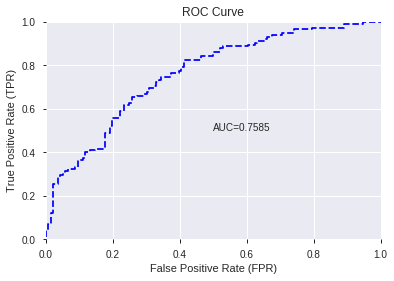

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


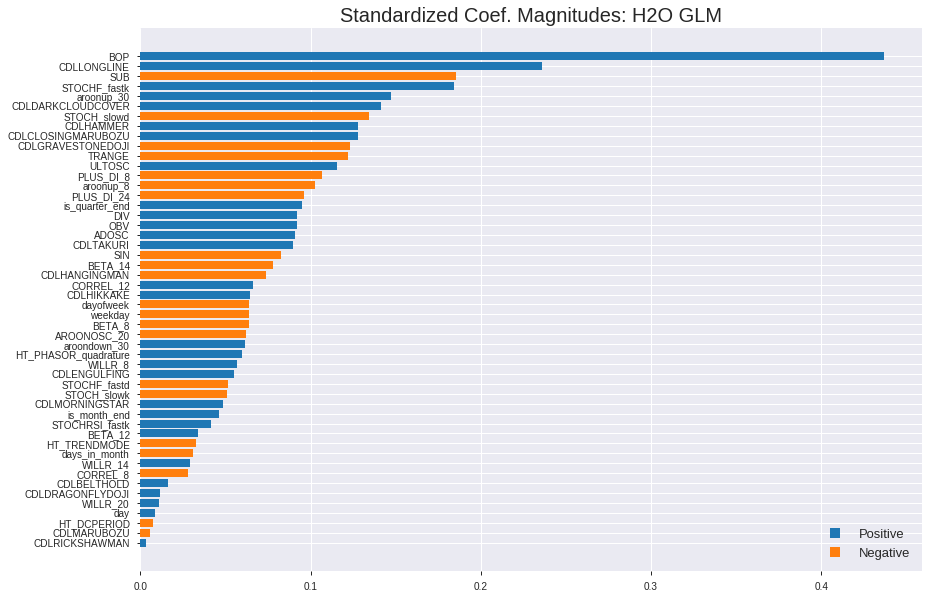

'log_likelihood'
--2019-09-03 02:40:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_024031_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_024031_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLLONGLINE',
 'SUB',
 'STOCHF_fastk',
 'aroonup_30',
 'CDLDARKCLOUDCOVER',
 'STOCH_slowd',
 'CDLHAMMER',
 'CDLCLOSINGMARUBOZU',
 'CDLGRAVESTONEDOJI',
 'TRANGE',
 'ULTOSC',
 'PLUS_DI_8',
 'aroonup_8',
 'PLUS_DI_24',
 'is_quarter_end',
 'DIV',
 'OBV',
 'ADOSC',
 'CDLTAKURI',
 'SIN',
 'BETA_14',
 'CDLHANGINGMAN',
 'CORREL_12',
 'CDLHIKKAKE',
 'dayofweek',
 'weekday',
 'BETA_8',
 'AROONOSC_20',
 'aroondown_30',
 'HT_PHASOR_quadrature',
 'WILLR_8',
 'CDLENGULFING',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLMORNINGSTAR',
 'is_month_end',
 'STOCHRSI_fastk',
 'BETA_12',
 'HT_TRENDMODE',
 'days_in_month',
 'WILLR_14',
 'CORREL_8',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'WILLR_20',
 'day',
 'HT_DCPERIOD',
 'CDLMARUBOZU',
 'CDLRICKSHAWMAN']

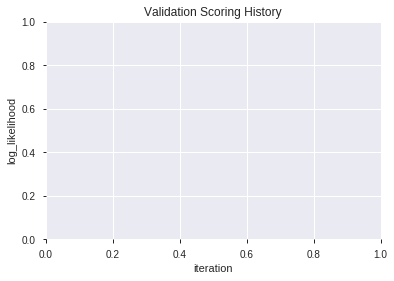

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_024043_model_4  0.741432  0.609721              0.339930  0.460945  0.212470
1               XGBoost_3_AutoML_20190903_024043  0.741368  0.616138              0.343606  0.463090  0.214452
2  XGBoost_grid_1_AutoML_20190903_024043_model_2  0.740217  0.616004              0.346292  0.463050  0.214416
3  XGBoost_grid_1_AutoML_20190903_024043_model_1  0.736317  0.618200              0.339930  0.464703  0.215948
4  XGBoost_grid_1_AutoML_20190903_024043_model_3  0.725895  0.629941              0.348625  0.469947  0.220850
5  XGBoost_grid_1_AutoML_20190903_024043_model_7  0.725703  0.632656              0.350288  0.470853  0.221702
6               XGBoost_2_AutoML_20190903_024043  0.725064  0.619565              0.350639  0.465472  0.216664
7               XGBoost_1_AutoML_20190903_024043  0.723338  0.628510              0.351630  0.468471  0.219465
8  XGBoost_grid_1_AutoML_20190903_024043_model_6  0.722762  0.639867              0.349648  0.474484  0.225135
9  XGBoost_grid_1_AutoML_20190903_024043_model_5  0.708951  0.667087              0.349616  0.482953  0.233244

variable  relative_importance  scaled_importance  percentage
0                    BOP          2113.450684           1.000000    0.409753
1           STOCHF_fastk           443.675323           0.209929    0.086019
2                    SUB           356.022797           0.168456    0.069025
3              aroonup_8           177.618820           0.084042    0.034436
4            STOCH_slowd           164.153824           0.077671    0.031826
5              dayofweek           124.090935           0.058715    0.024059
6               WILLR_14           123.978432           0.058662    0.024037
7                 ULTOSC           118.150803           0.055904    0.022907
8                    DIV           113.399017           0.053656    0.021986
9            STOCH_slowk           110.034264           0.052064    0.021333
10               WILLR_8           104.476791           0.049434    0.020256
11             PLUS_DI_8           103.054497           0.048761    0.019980
12              WILLR_20            96.701729           0.045755    0.018748
13              CORREL_8            91.594887           0.043339    0.017758
14                   SIN            89.739883           0.042461    0.017399
15                   OBV            75.555954           0.035750    0.014649
16                 ADOSC            71.804832           0.033975    0.013921
17  HT_PHASOR_quadrature            68.520744           0.032421    0.013285
18                   day            64.790642           0.030656    0.012562
19                BETA_8            62.511772           0.029578    0.012120
20                TRANGE            60.895275           0.028813    0.011806
21          aroondown_30            52.706306           0.024939    0.010219
22               BETA_14            52.666981           0.024920    0.010211
23             CORREL_12            51.512630           0.024374    0.009987
24            PLUS_DI_24            51.455791           0.024347    0.009976
25           HT_DCPERIOD            39.659790           0.018765    0.007689
26           CDLLONGLINE            38.805557           0.018361    0.007524
27            aroonup_30            34.835567           0.016483    0.006754
28        STOCHRSI_fastk            29.361235           0.013893    0.005693
29               BETA_12            28.683056           0.013572    0.005561
30           AROONOSC_20            25.377007           0.012007    0.004920
31         days_in_month            10.552311           0.004993    0.002046
32          HT_TRENDMODE             8.029536           0.003799    0.001557

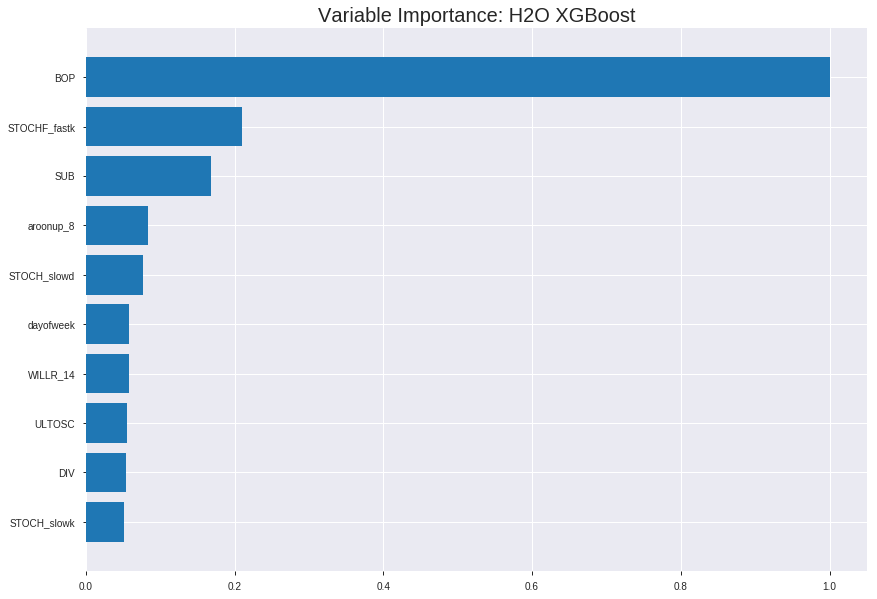

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_024043_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17587680642648124
RMSE: 0.41937668798644645
LogLoss: 0.5302657701918881
Mean Per-Class Error: 0.24709494174263136
AUC: 0.8235174667970098
pr_auc: 0.8234688492746454
Gini: 0.6470349335940195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4153371870517731: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      476  371   0.438    (371.0/847.0)
1      104  803   0.1147   (104.0/907.0)
Total  580  1174  0.2708   (475.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415337     0.771744  249
max f2                       0.259971     0.866458  325
max f0point5                 0.583704     0.76636   164
max accuracy                 0.531449     0.753136  190
max precision                0.882731     1         0
max recall                   0.145118     1         379
max specificity              0.882731     1         0
max absolute_mcc             0.531449     0.505754  190
max min_per_class_accuracy   0.539913     0.748524  187
max mean_per_class_accuracy  0.531449     0.752905  190

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.864805           1.93385   1.93385            1                0.871483  1                           0.871483            0.0198456       0.0198456                  93.3848   93.3848
    2        0.0205245                   0.852573           1.82641   1.88013            0.944444         0.858504  0.972222                    0.864994            0.0187431       0.0385888                  82.6412   88.013
    3        0.0302166                   0.846555           1.82009   1.86087            0.941176         0.849797  0.962264                    0.86012             0.0176406       0.0562293                  82.0092   86.0872
    4        0.0404789                   0.837888           1.61154   1.79766            0.833333         0.842356  0.929577                    0.855616            0.016538        0.0727674                  61.154    79.7661
    5        0.050171                    0.832213           1.93385   1.82397            1                0.834536  0.943182                    0.851544            0.0187431       0.0915105                  93.3848   82.397
    6        0.100342                    0.786197           1.75804   1.79101            0.909091         0.810419  0.926136                    0.830981            0.0882029       0.179713                   75.8044   79.1007
    7        0.149943                    0.75385            1.66711   1.75002            0.862069         0.770396  0.904943                    0.81094             0.0826902       0.262404                   66.711    75.0022
    8        0.200114                    0.726675           1.60421   1.71347            0.829545         0.739138  0.88604                     0.792938            0.0804851       0.342889                   60.4215   71.3466
    9        0.299886                    0.665571           1.39237   1.60664            0.72             0.696649  0.830798                    0.760903            0.13892         0.481808                   39.237    60.6638
    10       0.400228                    0.604514           1.3515    1.54267            0.698864         0.635286  0.797721                    0.729409            0.135612        0.61742                    35.1496   54.2671
    11       0.5                         0.543943           1.23766   1.48181            0.64             0.575902  0.766249                    0.698778            0.123484        0.740904                   23.7663   48.1808
    12       0.599772                    0.471969           0.906146  1.38605            0.468571         0.50713   0.71673                     0.666897            0.0904079       0.831312                   -9.38542  38.6047
    13       0.700114                    0.39063            0.714205  1.28976            0.369318         0.431876  0.666938                    0.633214            0.0716648       0.902977                   -28.5795  28.9757
    14       0.799886                    0.298995           0.508326  1.19229            0.262857         0.347021  0.616536                    0.597516            0.0507166       0.953693                   -49.1674  19.2287
    15       0.899658                    0.199266           0.320466  1.0956             0.165714         0.248894  0.56654                     0.558854            0.0319735       0.985667                   -67.9534  9.5602
    16       1                           0.100234           0.142841  1                  0.0738636        0.151115  0.517104                    0.51794             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19676380174890792
RMSE: 0.44358065980034334
LogLoss: 0.5761554850501008
Mean Per-Class Error: 0.29997611655123
AUC: 0.7678926837035268
pr_auc: 0.773775521468204
Gini: 0.5357853674070536
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45844872295856476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  125  0.5274   (125.0/237.0)
1      33   232  0.1245   (33.0/265.0)
Total  145  357  0.3147   (158.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458449     0.745981  269
max f2                       0.299067     0.866089  342
max f0point5                 0.600655     0.716738  172
max accuracy                 0.52735      0.705179  228
max precision                0.870187     1         0
max recall                   0.185295     1         375
max specificity              0.870187     1         0
max absolute_mcc             0.52735      0.408283  228
max min_per_class_accuracy   0.57656      0.690566  193
max mean_per_class_accuracy  0.52735      0.700024  228

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 54.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.85919            1.57862   1.57862            0.833333         0.864565  0.833333                    0.864565            0.0188679       0.0188679                  57.8616   57.8616
    2        0.0219124                   0.846313           1.89434   1.72213            1                0.852276  0.909091                    0.858979            0.0188679       0.0377358                  89.434    72.2127
    3        0.0318725                   0.836031           1.89434   1.77594            1                0.839599  0.9375                      0.852923            0.0188679       0.0566038                  89.434    77.5943
    4        0.0418327                   0.822841           1.51547   1.71393            0.8              0.826856  0.904762                    0.846716            0.0150943       0.0716981                  51.5472   71.3926
    5        0.0517928                   0.818927           1.89434   1.74862            1                0.819936  0.923077                    0.841566            0.0188679       0.090566                   89.434    74.8621
    6        0.101594                    0.778715           1.74279   1.74576            0.92             0.802395  0.921569                    0.822365            0.0867925       0.177358                   74.2792   74.5764
    7        0.151394                    0.745088           1.51547   1.67001            0.8              0.761054  0.881579                    0.802197            0.0754717       0.25283                    51.5472   67.001
    8        0.201195                    0.71983            1.4397    1.613              0.76             0.73194   0.851485                    0.784807            0.0716981       0.324528                   43.9698   61.3002
    9        0.300797                    0.668659           1.21238   1.48034            0.64             0.695287  0.781457                    0.755164            0.120755        0.445283                   21.2377   48.0345
    10       0.400398                    0.616935           1.25026   1.42311            0.66             0.641312  0.751244                    0.726843            0.124528        0.569811                   25.0264   42.3111
    11       0.5                         0.577673           1.09872   1.35849            0.58             0.598335  0.717131                    0.701244            0.109434        0.679245                   9.8717    35.8491
    12       0.599602                    0.532476           1.06083   1.30905            0.56             0.557588  0.69103                     0.677381            0.10566         0.784906                   6.08302   30.9045
    13       0.699203                    0.463284           0.795623  1.23591            0.42             0.497649  0.652422                    0.651778            0.0792453       0.864151                   -20.4377  23.5908
    14       0.798805                    0.388063           0.719849  1.17156            0.38             0.426386  0.618454                    0.623674            0.0716981       0.935849                   -28.0151  17.1562
    15       0.898406                    0.264404           0.492528  1.09628            0.26             0.330361  0.578714                    0.591156            0.0490566       0.984906                   -50.7472  9.62808
    16       1                           0.0984937          0.148576  1                  0.0784314        0.180314  0.527888                    0.549417          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:40:55  4.761 sec   0                  0.5              0.693147            0.5             0                  1                0.482896                         0.5                0.693147              0.5               0                    1                  0.472112
    2019-09-03 02:40:55  4.889 sec   5                  0.478539         0.650893            0.781011        0.737395           1.80492          0.330673                         0.481856           0.65733               0.773505          0.725878             1.74862            0.306773
    2019-09-03 02:40:55  4.965 sec   10                 0.464143         0.622717            0.785811        0.743887           1.80492          0.32041                          0.470115           0.63418               0.769397          0.731763             1.74862            0.316733
    2019-09-03 02:40:56  5.062 sec   15                 0.454034         0.602619            0.789381        0.773316           1.82641          0.312999                         0.462421           0.618673              0.764374          0.758031             1.74862            0.318725
    2019-09-03 02:40:56  5.140 sec   20                 0.446291         0.586874            0.793901        0.791938           1.93385          0.307868                         0.455664           0.604803              0.769907          0.771721             1.57862            0.326693
    2019-09-03 02:40:56  5.217 sec   25                 0.441219         0.576283            0.797144        0.795046           1.93385          0.302166                         0.451678           0.596314              0.772295          0.770386             1.62372            0.322709
    2019-09-03 02:40:56  5.318 sec   30                 0.436977         0.567447            0.800891        0.801227           1.93385          0.286203                         0.448688           0.589949              0.775098          0.772055             1.57862            0.326693
    2019-09-03 02:40:56  5.401 sec   35                 0.433732         0.560498            0.803911        0.80102            1.93385          0.292474                         0.446252           0.584306              0.775543          0.779927             1.89434            0.306773
    2019-09-03 02:40:56  5.501 sec   40                 0.430841         0.55448             0.807508        0.804847           1.93385          0.266819                         0.445806           0.582905              0.771133          0.773054             1.57862            0.306773
    2019-09-03 02:40:56  5.588 sec   45                 0.428369         0.549204            0.810506        0.806134           1.93385          0.269669                         0.445393           0.581775              0.769565          0.770077             1.57862            0.294821
    2019-09-03 02:40:56  5.682 sec   50                 0.425861         0.544021            0.814145        0.81437            1.93385          0.277081                         0.444736           0.579809              0.769111          0.771846             1.57862            0.322709
    2019-09-03 02:40:56  5.773 sec   55                 0.423834         0.539798            0.817194        0.813378           1.82641          0.279361                         0.443634           0.577136              0.770257          0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             2113.45068359375       1.0                    0.4097527927460727
STOCHF_fastk    443.6753234863281      0.2099293477394488     0.08601913651560059
SUB             356.0227966308594      0.1684556916300842     0.06902519009939821
aroonup_8       177.6188201904297      0.08404209360987       0.034436482564871106
STOCH_slowd     164.15382385253906     0.07767099801610176    0.031825908352472364
---             ---                    ---                    ---
STOCHRSI_fastk  29.361234664916992     0.013892557272730213   0.005692514140885968
BETA_12         28.683055877685547     0.013571670302196196   0.0055610298085538275
AROONOSC_20     25.37700653076172      0.01200738050230261    0.004920057694383236
days_in_month   10.552310943603516     0.00499292982113033    0.0020458669381933016
HT_TRENDMODE    8.029536247253418      0.0037992541342861375  0.0015567549918758074


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772908366533864)

('F1', 0.7016393442622951)

('auc', 0.7414322250639386)

('logloss', 0.6097214547639608)

('mean_per_class_error', 0.32528772378516624)

('rmse', 0.4609446832884289)

('mse', 0.21247000105187003)

xgboost prediction progress: |████████████████████████████████████████████| 100%


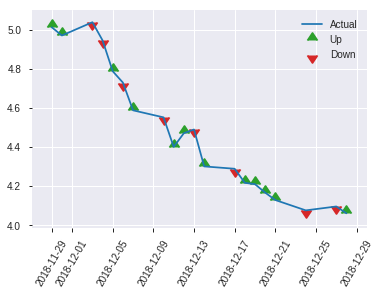


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21247000105187003
RMSE: 0.4609446832884289
LogLoss: 0.6097214547639608
Mean Per-Class Error: 0.32528772378516624
AUC: 0.7414322250639386
pr_auc: 0.7012951143956084
Gini: 0.48286445012787715
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40449655055999756: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   83   0.6103   (83.0/136.0)
1      8    107  0.0696   (8.0/115.0)
Total  61   190  0.3625   (91.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404497     0.701639  189
max f2                       0.254795     0.834543  228
max f0point5                 0.656867     0.652632  89
max accuracy                 0.656867     0.677291  89
max precision                0.883938     1         0
max recall                   0.254795     1         228
max specificity              0.883938     1         0
max absolute_mcc             0.404497     0.371893  189
max min_per_class_accuracy   0.593714     0.669118  121
max mean_per_class_accuracy  0.558567     0.674712  137

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 54.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.86838            2.18261   2.18261            1                0.876866  1                           0.876866            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.856056           2.18261   2.18261            1                0.861271  1                           0.869069            0.026087        0.0521739                  118.261   118.261
    3        0.0318725                   0.840904           2.18261   2.18261            1                0.842373  1                           0.862395            0.0173913       0.0695652                  118.261   118.261
    4        0.0438247                   0.83144            1.45507   1.98419            0.666667         0.834587  0.909091                    0.854811            0.0173913       0.0869565                  45.5072   98.419
    5        0.0517928                   0.819926           2.18261   2.01472            1                0.825764  0.923077                    0.850342            0.0173913       0.104348                   118.261   101.472
    6        0.103586                    0.776337           1.67893   1.84682            0.769231         0.795807  0.846154                    0.823075            0.0869565       0.191304                   67.893    84.6823
    7        0.151394                    0.75703            1.27319   1.66568            0.583333         0.766317  0.763158                    0.805151            0.0608696       0.252174                   27.3188   66.5675
    8        0.203187                    0.720308           1.51104   1.62626            0.692308         0.737402  0.745098                    0.787882            0.0782609       0.330435                   51.1037   62.6257
    9        0.302789                    0.676236           1.30957   1.52208            0.6              0.693712  0.697368                    0.756905            0.130435        0.46087                    30.9565   52.2082
    10       0.40239                     0.636045           1.13496   1.42626            0.52             0.657323  0.653465                    0.732256            0.113043        0.573913                   13.4957   42.6259
    11       0.501992                    0.59106            1.04765   1.35114            0.48             0.611703  0.619048                    0.708337            0.104348        0.678261                   4.76522   35.1139
    12       0.601594                    0.516573           0.960348  1.28644            0.44             0.550921  0.589404                    0.682274            0.0956522       0.773913                   -3.96522  28.6438
    13       0.701195                    0.438915           0.960348  1.24012            0.44             0.477212  0.568182                    0.653146            0.0956522       0.869565                   -3.96522  24.0119
    14       0.800797                    0.36461            0.698435  1.17274            0.32             0.405069  0.537313                    0.622291            0.0695652       0.93913                    -30.1565  17.2745
    15       0.900398                    0.275353           0.436522  1.0913             0.2              0.322344  0.5                         0.589111            0.0434783       0.982609                   -56.3478  9.13043
    16       1                           0.103656           0.174609  1                  0.08             0.180361  0.458167                    0.548399          

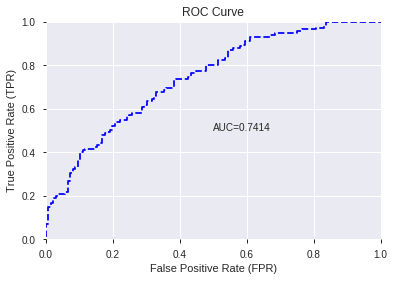

This function is available for GLM models only


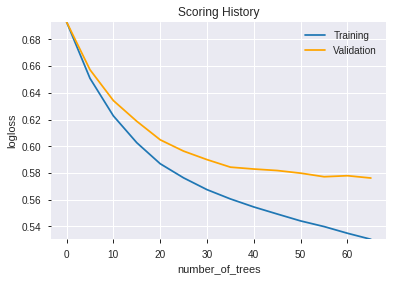

--2019-09-03 02:41:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.172
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.172|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_024043_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_024043_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'aroonup_8',
 'STOCH_slowd',
 'dayofweek',
 'WILLR_14',
 'ULTOSC',
 'DIV',
 'STOCH_slowk',
 'WILLR_8',
 'PLUS_DI_8',
 'WILLR_20',
 'CORREL_8',
 'SIN',
 'OBV',
 'ADOSC',
 'HT_PHASOR_quadrature',
 'day',
 'BETA_8',
 'TRANGE',
 'aroondown_30',
 'BETA_14',
 'CORREL_12',
 'PLUS_DI_24',
 'HT_DCPERIOD',
 'CDLLONGLINE',
 'aroonup_30',
 'STOCHRSI_fastk',
 'BETA_12',
 'AROONOSC_20',
 'days_in_month',
 'HT_TRENDMODE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_024118_model_1  0.761509  0.607699               0.31656  0.458689  0.210395

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.275000           1.000000  3.298557e-02
1                  CDLLONGLINE             0.183639           0.667779  2.202708e-02
2                          SUB             0.123465           0.448964  1.480935e-02
3                 STOCHF_fastk             0.121253           0.440920  1.454400e-02
4            CDLDARKCLOUDCOVER             0.110627           0.402280  1.326943e-02
...                        ...                  ...                ...           ...
1037                    T3_8_7             0.000029           0.000107  3.521515e-06
1038                    WMA_24             0.000016           0.000057  1.887343e-06
1039   BBANDS_upperband_24_5_2             0.000007           0.000027  8.814784e-07
1040  BBANDS_middleband_14_0_5             0.000006           0.000021  6.824916e-07
1041  BBANDS_middleband_14_0_3             0.000005           0.000019  6.370830e-07

[1042 rows x 4 columns]

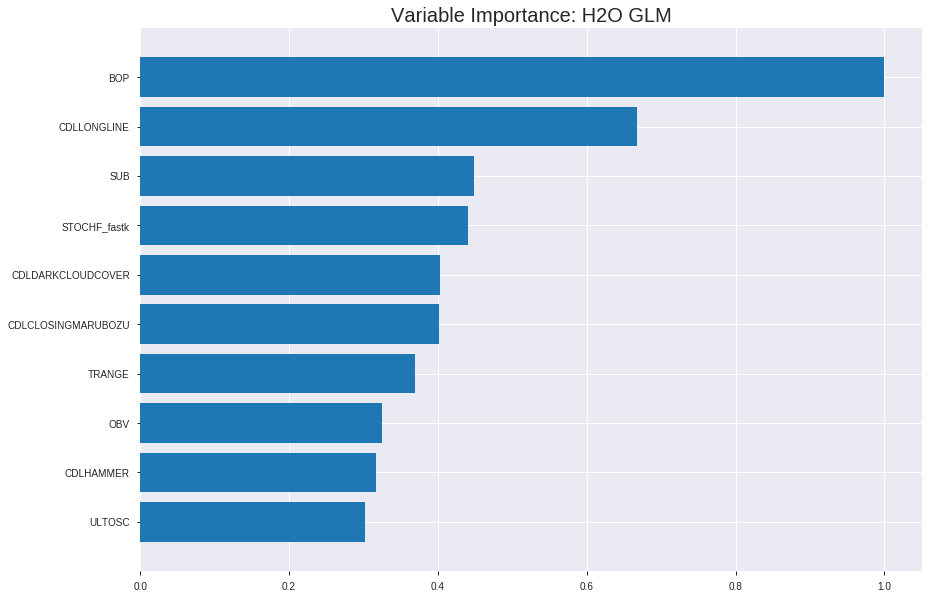

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_024118_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18629758042683733
RMSE: 0.43162203422304257
LogLoss: 0.553943139471913
Null degrees of freedom: 1753
Residual degrees of freedom: 711
Null deviance: 2429.507457396468
Residual deviance: 1943.232533267471
AIC: 4029.232533267471
AUC: 0.7976221933824419
pr_auc: 0.7865592192195502
Gini: 0.5952443867648838
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4349919267994988: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      482  365   0.4309   (365.0/847.0)
1      127  780   0.14     (127.0/907.0)
Total  609  1145  0.2805   (492.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434992     0.760234  239
max f2                       0.345529     0.861517  286
max f0point5                 0.55911      0.742178  173
max accuracy                 0.529169     0.72919   189
max precision                0.937822     1         0
max recall                   0.0938185    1         386
max specificity              0.937822     1         0
max absolute_mcc             0.529169     0.458015  189
max min_per_class_accuracy   0.531496     0.727674  188
max mean_per_class_accuracy  0.529169     0.729088  189

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.897139           1.71898   1.71898            0.888889         0.913286  0.888889                    0.913286            0.0176406       0.0176406                  71.8976   71.8976
    2        0.0205245                   0.872216           1.82641   1.77269            0.944444         0.88236   0.916667                    0.897823            0.0187431       0.0363837                  82.6412   77.2694
    3        0.0302166                   0.853898           1.82009   1.7879             0.941176         0.86374   0.924528                    0.886891            0.0176406       0.0540243                  82.0092   78.7897
    4        0.0404789                   0.842348           1.82641   1.79766            0.944444         0.847762  0.929577                    0.876971            0.0187431       0.0727674                  82.6412   79.7661
    5        0.050171                    0.827557           1.59258   1.75804            0.823529         0.833383  0.909091                    0.86855             0.0154355       0.0882029                  59.2581   75.8044
    6        0.100342                    0.779577           1.69212   1.72508            0.875            0.804426  0.892045                    0.836488            0.0848953       0.173098                   69.2117   72.508
    7        0.149943                    0.739534           1.60043   1.68384            0.827586         0.757771  0.870722                    0.810449            0.0793826       0.252481                   60.0426   68.3845
    8        0.200114                    0.708808           1.47236   1.63082            0.761364         0.723416  0.843305                    0.788628            0.0738699       0.326351                   47.2361   63.0823
    9        0.299886                    0.645774           1.40342   1.55517            0.725714         0.676601  0.804183                    0.751357            0.140022        0.466373                   40.3421   55.5167
    10       0.400228                    0.590847           1.28557   1.48758            0.664773         0.618568  0.769231                    0.718065            0.128997        0.595369                   28.5569   48.7575
    11       0.5                         0.53434            1.24871   1.43991            0.645714         0.563055  0.744584                    0.687134            0.124587        0.719956                   24.8713   43.9912
    12       0.599772                    0.465815           0.928247  1.3548             0.48             0.502431  0.70057                     0.656408            0.092613        0.812569                   -7.1753   35.4796
    13       0.700114                    0.399622           0.802107  1.27558            0.414773         0.435106  0.659609                    0.624691            0.0804851       0.893054                   -19.7893  27.5584
    14       0.799886                    0.327438           0.618831  1.19367            0.32             0.365229  0.617249                    0.592328            0.061742        0.954796                   -38.1169  19.3665
    15       0.899658                    0.221216           0.276264  1.09193            0.142857         0.277656  0.564639                    0.55743             0.0275634       0.982359                   -72.3736  9.19255
    16       1                           0.020751           0.175804  1                  0.0909091        0.155538  0.517104                    0.517104          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19754846942960763
RMSE: 0.4444642498892432
LogLoss: 0.5780754180266472
Null degrees of freedom: 501
Residual degrees of freedom: -541
Null deviance: 694.5911617977604
Residual deviance: 580.3877196987537
AIC: 2666.3877196987537
AUC: 0.7654008438818566
pr_auc: 0.7844249943219932
Gini: 0.5308016877637132
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34611502041322556: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      75   162  0.6835   (162.0/237.0)
1      12   253  0.0453   (12.0/265.0)
Total  87   415  0.3466   (174.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346115     0.744118  320
max f2                       0.239705     0.865829  354
max f0point5                 0.615685     0.716862  162
max accuracy                 0.538336     0.699203  218
max precision                0.931005     1         0
max recall                   0.0872178    1         399
max specificity              0.931005     1         0
max absolute_mcc             0.538336     0.395109  218
max min_per_class_accuracy   0.573908     0.687764  195
max mean_per_class_accuracy  0.538336     0.695701  218

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 55.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.892095           1.89434   1.89434            1                0.910271  1                           0.910271            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.885687           1.89434   1.89434            1                0.887842  1                           0.900076            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.865732           1.89434   1.89434            1                0.871606  1                           0.891179            0.0188679       0.0603774                  89.434    89.434
    4        0.0418327                   0.86001            1.89434   1.89434            1                0.862789  1                           0.88442             0.0188679       0.0792453                  89.434    89.434
    5        0.0517928                   0.844632           1.89434   1.89434            1                0.851203  1                           0.878032            0.0188679       0.0981132                  89.434    89.434
    6        0.101594                    0.799209           1.51547   1.70862            0.8              0.820764  0.901961                    0.849959            0.0754717       0.173585                   51.5472   70.862
    7        0.151394                    0.765573           1.66702   1.69494            0.88             0.782187  0.894737                    0.827666            0.0830189       0.256604                   66.7019   69.4935
    8        0.201195                    0.734177           1.59125   1.66927            0.84             0.746751  0.881188                    0.807637            0.0792453       0.335849                   59.1245   66.927
    9        0.300797                    0.6627             1.17449   1.50544            0.62             0.696321  0.794702                    0.770778            0.116981        0.45283                    17.4491   50.5435
    10       0.400398                    0.626629           1.17449   1.42311            0.62             0.64597   0.751244                    0.739731            0.116981        0.569811                   17.4491   42.3111
    11       0.5                         0.575151           1.06083   1.35094            0.56             0.59949   0.713147                    0.711795            0.10566         0.675472                   6.08302   35.0943
    12       0.599602                    0.524785           1.02294   1.29646            0.54             0.552223  0.684385                    0.685288            0.101887        0.777358                   2.29434   29.6458
    13       0.699203                    0.451906           0.795623  1.22511            0.42             0.488695  0.646724                    0.657283            0.0792453       0.856604                   -20.4377  22.5114
    14       0.798805                    0.376082           0.681962  1.15739            0.36             0.418601  0.610973                    0.627522            0.0679245       0.924528                   -31.8038  15.739
    15       0.898406                    0.240088           0.568302  1.09208            0.3              0.311178  0.576497                    0.592451            0.0566038       0.981132                   -43.1698  9.20805
    16       1                           0.0872178          0.18572   1                  0.0980392        0.179383  0.527888                    0.550486            0.018


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 02:41:24  0.000 sec   2            .21E2     1032          1.3593540222195313  1.3561932856367829
     2019-09-03 02:41:26  2.295 sec   4            .15E2     1040          1.3522328028182076  1.3490034241578475
     2019-09-03 02:41:29  4.770 sec   6            .11E2     1042          1.3433086007154988  1.3399413608726762
     2019-09-03 02:41:31  7.063 sec   8            .8E1      1043          1.3324176279799549  1.3289348322295715
     2019-09-03 02:41:33  9.354 sec   10           .58E1     1043          1.3194167619135857  1.3159472518447497
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 02:42:03  39.234 sec  36           .93E-1    1043          1.0964874224914245  1.1588783622642453
     2019-09-03 02:42:05  41.520 sec  38           .68E-1    1043          1.0862761389512778  1.1647810380760166
     2019-09-03 02:42:08  43.797 sec  40           .49E-1    1043          1.0770970435205296  1.173728666700957
     2019-09-03 02:42:10  46.179 sec  42           .36E-1    1043          1.0687870548454008  1.1856479024803146
     2019-09-03 02:42:12  48.453 sec  44           .26E-1    1043          1.0612089518618577  1.2003703013117923


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7025089605734767)

('auc', 0.7615089514066495)

('logloss', 0.6076991311289962)

('mean_per_class_error', 0.29453324808184145)

('rmse', 0.45868860027087616)

('mse', 0.2103952320184556)

glm prediction progress: |████████████████████████████████████████████████| 100%


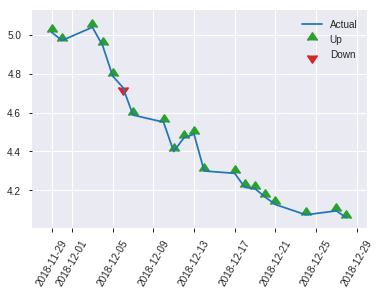


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2103952320184556
RMSE: 0.45868860027087616
LogLoss: 0.6076991311289962
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 349.69104234008756
Residual deviance: 305.06496382675607
AIC: 2391.064963826756
AUC: 0.7615089514066495
pr_auc: 0.7161977744726493
Gini: 0.5230179028132991
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5063021310036078: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   66   0.4853   (66.0/136.0)
1      17   98   0.1478   (17.0/115.0)
Total  87   164  0.3307   (83.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506302     0.702509  163
max f2                       0.338887     0.817236  212
max f0point5                 0.695697     0.676056  59
max accuracy                 0.61218      0.701195  115
max precision                0.914432     1         0
max recall                   0.144797     1         243
max specificity              0.914432     1         0
max absolute_mcc             0.569779     0.410435  133
max min_per_class_accuracy   0.602516     0.691176  121
max mean_per_class_accuracy  0.569779     0.705467  133

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 55.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.897314           2.18261   2.18261            1                0.906232  1                           0.906232            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.885518           0.727536  1.45507            0.333333         0.890797  0.666667                    0.898515            0.00869565      0.0347826                  -27.2464  45.5072
    3        0.0318725                   0.865925           2.18261   1.63696            1                0.869639  0.75                        0.891296            0.0173913       0.0521739                  118.261   63.6957
    4        0.0438247                   0.846971           2.18261   1.78577            1                0.852221  0.818182                    0.880639            0.026087        0.0782609                  118.261   78.5771
    5        0.0517928                   0.843657           2.18261   1.84682            1                0.845173  0.846154                    0.875183            0.0173913       0.0956522                  118.261   84.6823
    6        0.103586                    0.782016           2.01472   1.93077            0.923077         0.815795  0.884615                    0.845489            0.104348        0.2                        101.472   93.0769
    7        0.151394                    0.75337            1.81884   1.89542            0.833333         0.763133  0.868421                    0.819482            0.0869565       0.286957                   81.8841   89.5423
    8        0.203187                    0.728881           1.51104   1.79744            0.692308         0.740294  0.823529                    0.799296            0.0782609       0.365217                   51.1037   79.7442
    9        0.302789                    0.674686           1.22226   1.60824            0.56             0.693449  0.736842                    0.764478            0.121739        0.486957                   22.2261   60.8238
    10       0.40239                     0.633078           1.04765   1.46948            0.48             0.654946  0.673267                    0.737366            0.104348        0.591304                   4.76522   46.9479
    11       0.501992                    0.595474           1.30957   1.43775            0.6              0.615001  0.65873                     0.713088            0.130435        0.721739                   30.9565   43.775
    12       0.601594                    0.523209           0.873043  1.34426            0.4              0.557234  0.615894                    0.687284            0.0869565       0.808696                   -12.6957  34.4256
    13       0.701195                    0.461331           0.523826  1.22772            0.24             0.499079  0.5625                      0.66055             0.0521739       0.86087                    -47.6174  22.7717
    14       0.800797                    0.369764           0.698435  1.16189            0.32             0.417144  0.532338                    0.630276            0.0695652       0.930435                   -30.1565  16.1886
    15       0.900398                    0.2531             0.349217  1.07199            0.16             0.322875  0.49115                     0.596271            0.0347826       0.965217                   -65.0783  7.19892
    16       1                           0.0841321          0.349217  1                  0.16             0.184267  0.458167                    0.555235          

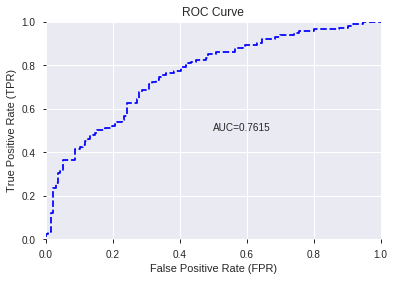

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


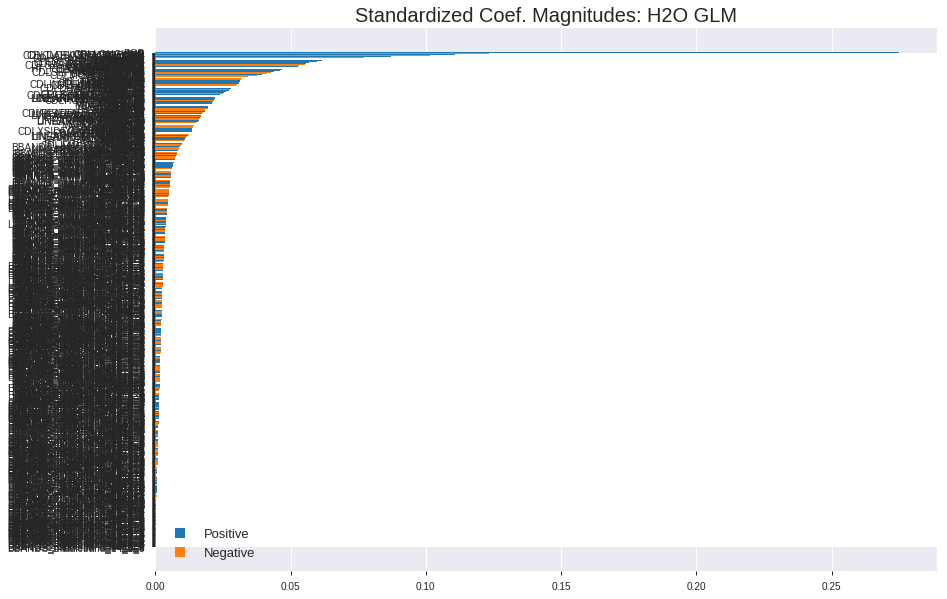

'log_likelihood'
--2019-09-03 02:42:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_024118_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_024118_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

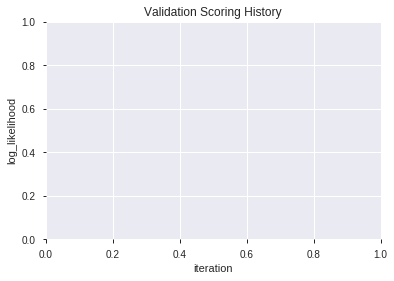

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190903_024244  0.762468  0.598459              0.330914  0.454726  0.206776
1  XGBoost_grid_1_AutoML_20190903_024244_model_2  0.760486  0.600298              0.336253  0.455787  0.207742
2  XGBoost_grid_1_AutoML_20190903_024244_model_1  0.756522  0.599520              0.316560  0.456577  0.208463
3  XGBoost_grid_1_AutoML_20190903_024244_model_3  0.753197  0.600421              0.329252  0.456872  0.208732
4  XGBoost_grid_1_AutoML_20190903_024244_model_4  0.752302  0.601203              0.319885  0.456379  0.208282
5  XGBoost_grid_1_AutoML_20190903_024244_model_6  0.747826  0.601013              0.317551  0.456932  0.208787
6               XGBoost_1_AutoML_20190903_024244  0.743798  0.605583              0.387372  0.459170  0.210837
7  XGBoost_grid_1_AutoML_20190903_024244_model_7  0.737148  0.615290              0.350959  0.462698  0.214089
8               XGBoost_2_AutoML_20190903_024244  0.735997  0.610768              0.371675  0.461715  0.213180
9  XGBoost_grid_1_AutoML_20190903_024244_model_5  0.722442  0.636282              0.323593  0.471886  0.222677

variable  relative_importance  scaled_importance  percentage
0                        BOP          2212.088867           1.000000    0.232205
1               STOCHF_fastk           666.206970           0.301166    0.069932
2                        SUB           384.161560           0.173665    0.040326
3                        DIV           190.520050           0.086127    0.019999
4                CDLLONGLINE           168.298019           0.076081    0.017666
..                       ...                  ...                ...         ...
305  BBANDS_upperband_12_7_4             0.421791           0.000191    0.000044
306  BBANDS_upperband_24_7_5             0.351765           0.000159    0.000037
307   BBANDS_lowerband_8_0_5             0.307909           0.000139    0.000032
308  BBANDS_lowerband_12_0_3             0.201340           0.000091    0.000021
309              CDLBELTHOLD             0.175960           0.000080    0.000018

[310 rows x 4 columns]

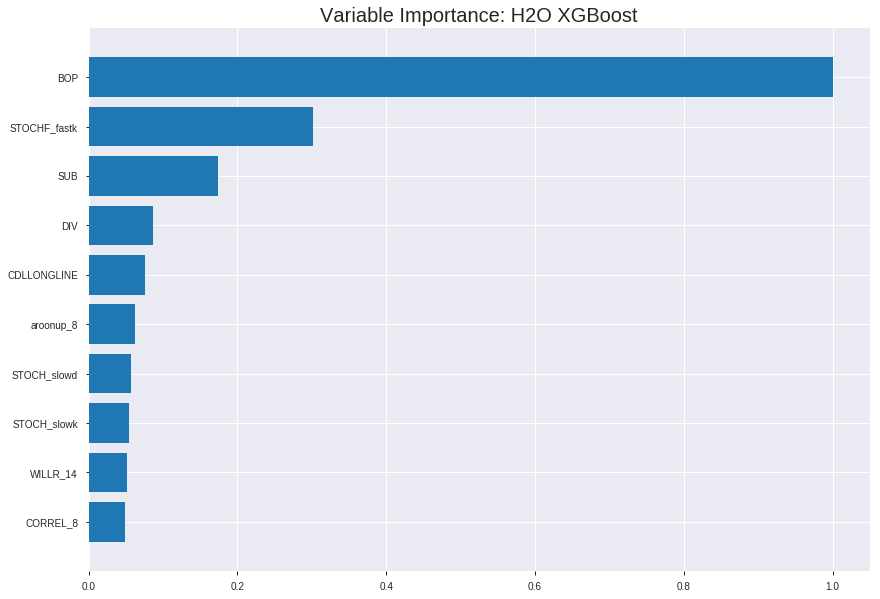

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190903_024244


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12570180310209308
RMSE: 0.35454450087696054
LogLoss: 0.4150682464650767
Mean Per-Class Error: 0.12797941759553466
AUC: 0.9434862521461699
pr_auc: 0.9497103931896278
Gini: 0.8869725042923398
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5368831157684326: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      746  101  0.1192   (101.0/847.0)
1      124  783  0.1367   (124.0/907.0)
Total  870  884  0.1283   (225.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536883     0.874372  196
max f2                       0.334392     0.908628  285
max f0point5                 0.589402     0.899724  170
max accuracy                 0.536883     0.871722  196
max precision                0.944426     1         0
max recall                   0.223391     1         334
max specificity              0.944426     1         0
max absolute_mcc             0.536883     0.743629  196
max min_per_class_accuracy   0.529295     0.867769  200
max mean_per_class_accuracy  0.536883     0.872021  196

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.68 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.913298           1.93385    1.93385            1                0.925782  1                           0.925782            0.0198456       0.0198456                  93.3848   93.3848
    2        0.0205245                   0.901034           1.93385    1.93385            1                0.906998  1                           0.91639             0.0198456       0.0396913                  93.3848   93.3848
    3        0.0302166                   0.89084            1.93385    1.93385            1                0.895369  1                           0.909647            0.0187431       0.0584344                  93.3848   93.3848
    4        0.0404789                   0.880391           1.93385    1.93385            1                0.885871  1                           0.90362             0.0198456       0.07828                    93.3848   93.3848
    5        0.050171                    0.872685           1.93385    1.93385            1                0.876281  1                           0.898338            0.0187431       0.0970232                  93.3848   93.3848
    6        0.100342                    0.818314           1.93385    1.93385            1                0.846145  1                           0.872242            0.0970232       0.194046                   93.3848   93.3848
    7        0.149943                    0.77707            1.91162    1.92649            0.988506         0.7983    0.996198                    0.847782            0.0948181       0.288864                   91.162    92.6495
    8        0.200114                    0.743324           1.8899     1.91732            0.977273         0.760148  0.991453                    0.825811            0.0948181       0.383682                   88.9897   91.7319
    9        0.299886                    0.679617           1.8786     1.90444            0.971429         0.714908  0.984791                    0.788913            0.187431        0.571114                   87.8595   90.4436
    10       0.400228                    0.615026           1.58224    1.82366            0.818182         0.647341  0.94302                     0.753419            0.158765        0.729879                   58.2239   82.3657
    11       0.5                         0.53909            1.28186    1.71555            0.662857         0.578699  0.887115                    0.718555            0.127894        0.857773                   28.1865   71.5546
    12       0.599772                    0.454024           0.640932   1.53678            0.331429         0.499849  0.794677                    0.682173            0.0639471       0.92172                    -35.9068  53.6784
    13       0.700114                    0.368034           0.450499   1.38109            0.232955         0.410946  0.714169                    0.6433              0.045204        0.966924                   -54.9501  38.1095
    14       0.799886                    0.265735           0.309416   1.24742            0.16             0.317841  0.645046                    0.602705            0.030871        0.997795                   -69.0584  24.7421
    15       0.899658                    0.174766           0.0221011  1.11153            0.0114286        0.220891  0.574778                    0.560362            0.00220507      1                          -97.7899  11.1534
    16       1                           0.064459           0          1                  0                0.126532  0.517104                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19484235812407236
RMSE: 0.44140951295149083
LogLoss: 0.5721620768437408
Mean Per-Class Error: 0.28884642942440886
AUC: 0.7745083990128174
pr_auc: 0.7724798201576902
Gini: 0.5490167980256349
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30409151315689087: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      69   168  0.7089   (168.0/237.0)
1      8    257  0.0302   (8.0/265.0)
Total  77   425  0.3506   (176.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304092     0.744928  331
max f2                       0.215721     0.871137  362
max f0point5                 0.574314     0.733006  189
max accuracy                 0.574314     0.709163  189
max precision                0.942037     1         0
max recall                   0.215721     1         362
max specificity              0.942037     1         0
max absolute_mcc             0.574314     0.422132  189
max min_per_class_accuracy   0.56632      0.701887  197
max mean_per_class_accuracy  0.574314     0.711154  189

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 53.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.901105           1.57862   1.57862            0.833333         0.921345  0.833333                    0.921345            0.0188679       0.0188679                  57.8616   57.8616
    2        0.0219124                   0.868794           1.89434   1.72213            1                0.875691  0.909091                    0.900593            0.0188679       0.0377358                  89.434    72.2127
    3        0.0318725                   0.850054           1.51547   1.65755            0.8              0.858903  0.875                       0.887565            0.0150943       0.0528302                  51.5472   65.7547
    4        0.0418327                   0.840891           1.51547   1.62372            0.8              0.843789  0.857143                    0.877142            0.0150943       0.0679245                  51.5472   62.372
    5        0.0517928                   0.81699            1.51547   1.6029             0.8              0.825649  0.846154                    0.86724             0.0150943       0.0830189                  51.5472   60.2903
    6        0.101594                    0.760994           1.66702   1.63433            0.88             0.784902  0.862745                    0.826878            0.0830189       0.166038                   66.7019   63.4332
    7        0.151394                    0.735216           1.81857   1.69494            0.96             0.748979  0.894737                    0.801253            0.090566        0.256604                   81.8566   69.4935
    8        0.201195                    0.706388           1.59125   1.66927            0.84             0.718601  0.881188                    0.780795            0.0792453       0.335849                   59.1245   66.927
    9        0.300797                    0.662383           1.1366    1.49289            0.6              0.684427  0.788079                    0.748885            0.113208        0.449057                   13.6604   49.289
    10       0.400398                    0.612378           1.40181   1.47023            0.74             0.637783  0.776119                    0.721248            0.139623        0.588679                   40.1811   47.0234
    11       0.5                         0.566687           1.09872   1.39623            0.58             0.589693  0.737052                    0.695042            0.109434        0.698113                   9.8717    39.6226
    12       0.599602                    0.511722           0.719849  1.28387            0.38             0.54157   0.677741                    0.669548            0.0716981       0.769811                   -28.0151  28.3871
    13       0.699203                    0.437469           0.833509  1.21972            0.44             0.477585  0.643875                    0.642203            0.0830189       0.85283                    -16.6491  21.9717
    14       0.798805                    0.349422           0.795623  1.16684            0.42             0.39417   0.61596                     0.611276            0.0792453       0.932075                   -20.4377  16.6838
    15       0.898406                    0.23341            0.530415  1.09628            0.28             0.294915  0.578714                    0.576203            0.0528302       0.984906                   -46.9585  9.62808
    16       1                           0.0714788          0.148576  1                  0.0784314        0.167948  0.527888                    0.534727            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:43:03  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.482896                         0.5                0.693147              0.5               0                    1                  0.472112
    2019-09-03 02:43:04  1.333 sec   5                  0.473183         0.640642            0.845064        0.826732           1.93385          0.261117                         0.484113           0.66171               0.725794          0.715814             1.57862            0.340637
    2019-09-03 02:43:04  1.613 sec   10                 0.450936         0.598118            0.865782        0.871318           1.93385          0.22805                          0.470669           0.635226              0.753483          0.751467             1.57862            0.316733
    2019-09-03 02:43:04  1.891 sec   15                 0.434181         0.566196            0.879046        0.887064           1.93385          0.200684                         0.461815           0.61745               0.763753          0.765441             1.57862            0.346614
    2019-09-03 02:43:05  2.151 sec   20                 0.421082         0.540926            0.884311        0.894647           1.93385          0.200114                         0.454989           0.603456              0.769286          0.7682               1.57862            0.332669
    2019-09-03 02:43:05  2.410 sec   25                 0.410035         0.519408            0.893383        0.903857           1.93385          0.194413                         0.450086           0.593112              0.775854          0.772654             1.57862            0.336653
    2019-09-03 02:43:05  2.685 sec   30                 0.403009         0.50512             0.895365        0.905559           1.93385          0.193273                         0.447241           0.586768              0.77657           0.773896             1.57862            0.334661
    2019-09-03 02:43:06  2.935 sec   35                 0.396546         0.492425            0.900122        0.909956           1.93385          0.18358                          0.445147           0.582106              0.778385          0.776735             1.57862            0.340637
    2019-09-03 02:43:06  3.183 sec   40                 0.390305         0.480192            0.905978        0.914483           1.93385          0.179019                         0.444076           0.57945               0.777733          0.774613             1.57862            0.304781
    2019-09-03 02:43:06  3.463 sec   45                 0.381643         0.464178            0.916567        0.923368           1.93385          0.163056                         0.443653           0.578145              0.77661           0.773899             1.57862            0.308765
    2019-09-03 02:43:06  3.752 sec   50                 0.374793         0.45117             0.922381        0.930368           1.93385          0.164766                         0.442324           0.575048              0.776745          0.774565             1.57862            0.306773
    2019-09-03 02:43:07  4.023 sec   55                 0.369185         0.441174            0.929096        0.936341           1.93385          0.152794                         0.442095           0.574164              0.77579           0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      2212.0888671875        1.0                    0.23220537848849135
STOCHF_fastk             666.2069702148438      0.3011664585889239     0.06993247150467963
SUB                      384.16156005859375     0.17366461436380967    0.04032585750840631
DIV                      190.52005004882812     0.08612676139501559    0.019999097227717578
CDLLONGLINE              168.2980194091797      0.07608103901501824    0.017666426460279987
---                      ---                    ---                    ---
BBANDS_upperband_12_7_4  0.42179107666015625    0.000190675466486313   4.4275868863923956e-05
BBANDS_upperband_24_7_5  0.3517646789550781     0.0001590192347933651  3.692512160214362e-05
BBANDS_lowerband_8_0_5   0.3079085350036621     0.0001391935647662944  3.2321494389719726e-05
BBANDS_lowerband_12_0_3  0.2013397216796875     9.101791734781224e-05  2.1134849946982964e-05
CDLBELTHOLD              0.17595958709716797    7.954453806410001e-05  1.847066956786655e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7211155378486056)

('F1', 0.7027027027027026)

('auc', 0.7624680306905371)

('logloss', 0.5984588405225044)

('mean_per_class_error', 0.2875639386189258)

('rmse', 0.45472599659781826)

('mse', 0.20677573198187904)

xgboost prediction progress: |████████████████████████████████████████████| 100%


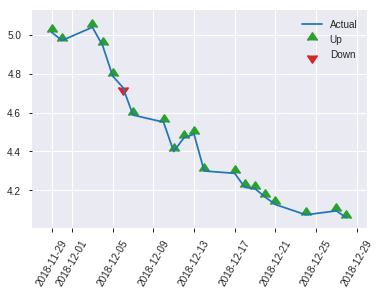


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20677573198187904
RMSE: 0.45472599659781826
LogLoss: 0.5984588405225044
Mean Per-Class Error: 0.2875639386189258
AUC: 0.7624680306905371
pr_auc: 0.7109470772487494
Gini: 0.5249360613810743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42773959040641785: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   77   0.5662   (77.0/136.0)
1      11   104  0.0957   (11.0/115.0)
Total  70   181  0.3506   (88.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42774      0.702703  180
max f2                       0.267674     0.830904  225
max f0point5                 0.655471     0.711253  88
max accuracy                 0.655471     0.721116  88
max precision                0.91515      1         0
max recall                   0.201269     1         234
max specificity              0.91515      1         0
max absolute_mcc             0.655471     0.438316  88
max min_per_class_accuracy   0.602182     0.686957  119
max mean_per_class_accuracy  0.647366     0.712436  94

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 54.64 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.896402           2.18261    2.18261            1                0.910247  1                           0.910247            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.882708           1.45507    1.81884            0.666667         0.88533   0.833333                    0.897789            0.0173913       0.0434783                  45.5072   81.8841
    3        0.0318725                   0.873829           1.0913     1.63696            0.5              0.878815  0.75                        0.893045            0.00869565      0.0521739                  9.13043   63.6957
    4        0.0438247                   0.856337           2.18261    1.78577            1                0.861522  0.818182                    0.884448            0.026087        0.0782609                  118.261   78.5771
    5        0.0517928                   0.839236           1.0913     1.67893            0.5              0.84713   0.769231                    0.878707            0.00869565      0.0869565                  9.13043   67.893
    6        0.103586                    0.771676           1.84682    1.76288            0.846154         0.801345  0.807692                    0.840026            0.0956522       0.182609                   84.6823   76.2876
    7        0.151394                    0.748708           1.81884    1.78055            0.833333         0.75786   0.815789                    0.814079            0.0869565       0.269565                   81.8841   78.0549
    8        0.203187                    0.731726           1.67893    1.75465            0.769231         0.739078  0.803922                    0.794961            0.0869565       0.356522                   67.893    75.4646
    9        0.302789                    0.680799           1.48417    1.66568            0.68             0.702254  0.763158                    0.764465            0.147826        0.504348                   48.4174   66.5675
    10       0.40239                     0.639097           1.04765    1.5127             0.48             0.654901  0.693069                    0.737345            0.104348        0.608696                   4.76522   51.2699
    11       0.501992                    0.591536           0.960348   1.40311            0.44             0.615571  0.642857                    0.713184            0.0956522       0.704348                   -3.96522  40.3106
    12       0.601594                    0.515294           0.61113    1.27198            0.28             0.548301  0.582781                    0.685885            0.0608696       0.765217                   -38.887   27.1984
    13       0.701195                    0.44604            1.04765    1.24012            0.48             0.480895  0.568182                    0.656767            0.104348        0.869565                   4.76522   24.0119
    14       0.800797                    0.338006           0.698435   1.17274            0.32             0.388528  0.537313                    0.623404            0.0695652       0.93913                    -30.1565  17.2745
    15       0.900398                    0.267674           0.523826   1.10096            0.24             0.300425  0.504425                    0.587676            0.0521739       0.991304                   -47.6174  10.0962
    16       1                           0.072464           0.0873043  1                  0.04             0.172963  0.458167                    

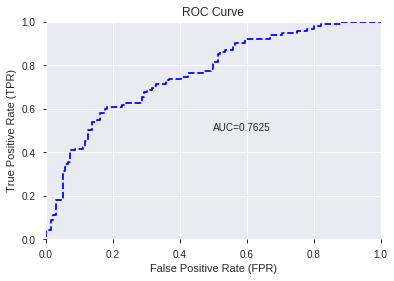

This function is available for GLM models only


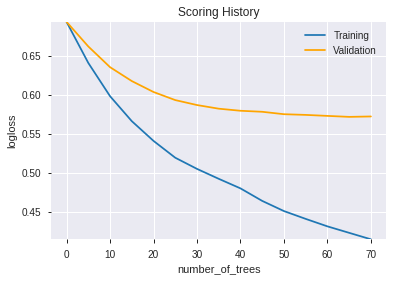

--2019-09-03 02:44:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190903_024244',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190903_024244',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_87ca',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_024407_model_9  0.769118  0.602190              0.300512  0.456092  0.208020
1  DeepLearning_grid_1_AutoML_20190903_024407_model_6  0.766113  0.615222              0.284143  0.462507  0.213912
2  DeepLearning_grid_1_AutoML_20190903_024407_model_8  0.750767  0.629416              0.289194  0.470841  0.221691
3               DeepLearning_1_AutoML_20190903_024407  0.749872  0.606951              0.301183  0.459654  0.211282
4  DeepLearning_grid_1_AutoML_20190903_024407_model_5  0.735678  0.624252              0.331266  0.469499  0.220429
5  DeepLearning_grid_1_AutoML_20190903_024407_model_4  0.714386  0.791991              0.380691  0.505485  0.255515
6  DeepLearning_grid_1_AutoML_20190903_024407_model_3  0.711253  0.708818              0.357641  0.497024  0.247033
7  DeepLearning_grid_1_AutoML_20190903_024407_model_7  0.705946  0.698474              0.360997  0.486911  0.237082
8  DeepLearning_grid_1_AutoML_20190903_024407_model_1  0.699169  0.984547              0.360646  0.540350  0.291978
9  DeepLearning_grid_1_AutoML_20190903_024407_model_2  0.691240  0.733205              0.345620  0.499391  0.249392

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.033464
1            CDLLONGLINE             0.825324           0.825324    0.027619
2     CDLCLOSINGMARUBOZU             0.742054           0.742054    0.024832
3                    SUB             0.673067           0.673067    0.022524
4              CDLHAMMER             0.660381           0.660381    0.022099
5              CDLTAKURI             0.639929           0.639929    0.021415
6           STOCHF_fastk             0.614745           0.614745    0.020572
7       CDLDRAGONFLYDOJI             0.610883           0.610883    0.020443
8              PLUS_DI_8             0.609507           0.609507    0.020397
9                 ULTOSC             0.607054           0.607054    0.020315
10                   SIN             0.605956           0.605956    0.020278
11           STOCH_slowd             0.602264           0.602264    0.020154
12        STOCHRSI_fastk             0.601695           0.601695    0.020135
13            aroonup_30             0.600095           0.600095    0.020082
14                   day             0.599766           0.599766    0.020071
15     CDLDARKCLOUDCOVER             0.595099           0.595099    0.019915
16          is_month_end             0.590296           0.590296    0.019754
17             dayofweek             0.590237           0.590237    0.019752
18          CDLENGULFING             0.589938           0.589938    0.019742
19        CDLMORNINGSTAR             0.588969           0.588969    0.019709
20         days_in_month             0.587720           0.587720    0.019668
21           CDLMARUBOZU             0.584276           0.584276    0.019552
22            PLUS_DI_24             0.584033           0.584033    0.019544
23                TRANGE             0.582429           0.582429    0.019491
24           CDLBELTHOLD             0.580731           0.580731    0.019434
25          aroondown_30             0.580563           0.580563    0.019428
26               BETA_14             0.580188           0.580188    0.019416
27           STOCH_slowk             0.577792           0.577792    0.019335
28         CDLHANGINGMAN             0.577273           0.577273    0.019318
29              WILLR_14             0.576276           0.576276    0.019285
30     CDLGRAVESTONEDOJI             0.573153           0.573153    0.019180
31           AROONOSC_20             0.572321           0.572321    0.019152
32  HT_PHASOR_quadrature             0.571897           0.571897    0.019138
33              WILLR_20             0.571213           0.571213    0.019115
34                   DIV             0.571200           0.571200    0.019115
35            CDLHIKKAKE             0.568333           0.568333    0.019019
36               BETA_12             0.565036           0.565036    0.018908
37        is_quarter_end             0.564856           0.564856    0.018902
38          STOCHF_fastd             0.564091           0.564091    0.018877
39              CORREL_8             0.563092           0.563092    0.018843
40               WILLR_8             0.560460           0.560460    0.018755
41               weekday             0.558402           0.558402    0.018686
42                 ADOSC             0.557383           0.557383    0.018652
43                BETA_8             0.554752           0.554752    0.018564
44             aroonup_8             0.547246           0.547246    0.018313
45        CDLRICKSHAWMAN             0.542518           0.542518    0.018155
46                   OBV             0.542503           0.542503    0.018154
47           HT_DCPERIOD             0.529089           0.529089    0.017706
48             CORREL_12             0.524400           0.524400    0.017549
49          HT_TRENDMODE             0.522195           0.522195    0.017475

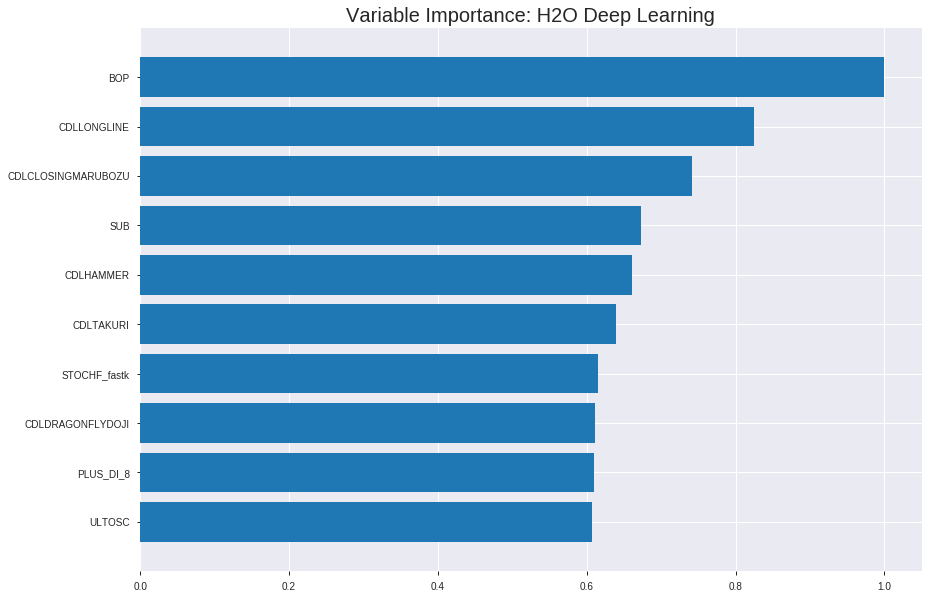

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_024407_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19603126023138076
RMSE: 0.44275417584860877
LogLoss: 0.5764863018381037
Mean Per-Class Error: 0.2910356156823031
AUC: 0.7744630832733469
pr_auc: 0.7703619988828497
Gini: 0.5489261665466938
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4183785296057307: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      397  450   0.5313   (450.0/847.0)
1      96   811   0.1058   (96.0/907.0)
Total  493  1261  0.3113   (546.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418379     0.748155  244
max f2                       0.278407     0.853418  299
max f0point5                 0.554205     0.723116  162
max accuracy                 0.554205     0.708096  162
max precision                0.857643     1         0
max recall                   0.065887     1         392
max specificity              0.857643     1         0
max absolute_mcc             0.554205     0.417963  162
max min_per_class_accuracy   0.54942      0.707202  166
max mean_per_class_accuracy  0.554205     0.708964  162

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.820167           1.71898   1.71898            0.888889         0.831459  0.888889                    0.831459            0.0176406       0.0176406                  71.8976   71.8976
    2        0.0205245                   0.802206           1.82641   1.77269            0.944444         0.810914  0.916667                    0.821186            0.0187431       0.0363837                  82.6412   77.2694
    3        0.0302166                   0.785437           1.93385   1.82438            1                0.794463  0.943396                    0.812614            0.0187431       0.0551268                  93.3848   82.4385
    4        0.0404789                   0.776569           1.71898   1.79766            0.888889         0.780489  0.929577                    0.80447             0.0176406       0.0727674                  71.8976   79.7661
    5        0.050171                    0.766447           1.70634   1.78002            0.882353         0.771597  0.920455                    0.79812             0.016538        0.0893054                  70.6336   78.0019
    6        0.100342                    0.723804           1.62619   1.7031             0.840909         0.741017  0.880682                    0.769568            0.0815877       0.170893                   62.619    70.3105
    7        0.149943                    0.687484           1.60043   1.66914            0.827586         0.703719  0.863118                    0.747785            0.0793826       0.250276                   60.0426   66.9139
    8        0.200114                    0.654337           1.47236   1.6198             0.761364         0.669076  0.837607                    0.728052            0.0738699       0.324146                   47.2361   61.9804
    9        0.299886                    0.60252            1.28186   1.50737            0.662857         0.626119  0.779468                    0.694139            0.127894        0.45204                    28.1865   50.7372
    10       0.400228                    0.573152           1.28557   1.45176            0.664773         0.588482  0.750712                    0.667649            0.128997        0.581036                   28.5569   45.1763
    11       0.5                         0.55092            1.18241   1.39802            0.611429         0.560996  0.722919                    0.646367            0.117971        0.699008                   18.241    39.8015
    12       0.599772                    0.505958           0.906146  1.31619            0.468571         0.53148   0.680608                    0.627256            0.0904079       0.789416                   -9.38542  31.6193
    13       0.700114                    0.432288           0.879022  1.25354            0.454545         0.472436  0.648208                    0.605067            0.0882029       0.877619                   -12.0978  25.3537
    14       0.799886                    0.303778           0.663034  1.17988            0.342857         0.376248  0.610121                    0.576525            0.0661521       0.943771                   -33.6966  17.9882
    15       0.899658                    0.172001           0.298365  1.08212            0.154286         0.23471   0.559569                    0.538618            0.0297685       0.973539                   -70.1635  8.21215
    16       1                           0.0380725          0.263707  1                  0.136364         0.115593  0.517104                    0.496171         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19699402426568804
RMSE: 0.4438400886194126
LogLoss: 0.5770593075419541
Mean Per-Class Error: 0.28728604410476877
AUC: 0.7759732505373775
pr_auc: 0.8001680513915381
Gini: 0.5519465010747551
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.453952422299573: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      95   142  0.5992   (142.0/237.0)
1      23   242  0.0868   (23.0/265.0)
Total  118  384  0.3287   (165.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453952     0.745763  286
max f2                       0.276007     0.867381  335
max f0point5                 0.572951     0.738197  173
max accuracy                 0.56266      0.711155  187
max precision                0.830885     1         0
max recall                   0.0756402    1         398
max specificity              0.830885     1         0
max absolute_mcc             0.572951     0.427063  173
max min_per_class_accuracy   0.561455     0.701887  189
max mean_per_class_accuracy  0.572951     0.712714  173

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 52.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.818822           1.89434   1.89434            1                0.821815  1                           0.821815            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.797417           1.89434   1.89434            1                0.809577  1                           0.816252            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.787887           1.89434   1.89434            1                0.792352  1                           0.808784            0.0188679       0.0603774                  89.434    89.434
    4        0.0418327                   0.779017           1.89434   1.89434            1                0.782649  1                           0.802561            0.0188679       0.0792453                  89.434    89.434
    5        0.0517928                   0.760477           1.89434   1.89434            1                0.773698  1                           0.79701             0.0188679       0.0981132                  89.434    89.434
    6        0.101594                    0.732778           1.74279   1.82005            0.92             0.74266   0.960784                    0.770368            0.0867925       0.184906                   74.2792   82.0052
    7        0.151394                    0.692547           1.59125   1.74479            0.84             0.709437  0.921053                    0.750325            0.0792453       0.264151                   59.1245   74.4786
    8        0.201195                    0.656672           1.4397    1.66927            0.76             0.671735  0.881188                    0.730872            0.0716981       0.335849                   43.9698   66.927
    9        0.300797                    0.625192           1.21238   1.51798            0.64             0.637859  0.801325                    0.700073            0.120755        0.456604                   21.2377   51.7981
    10       0.400398                    0.58553            1.28815   1.46081            0.68             0.603779  0.771144                    0.676119            0.128302        0.584906                   28.8151   46.0809
    11       0.5                         0.561832           1.1366    1.39623            0.6              0.573403  0.737052                    0.655658            0.113208        0.698113                   13.6604   39.6226
    12       0.599602                    0.52933            0.719849  1.28387            0.38             0.548852  0.677741                    0.637916            0.0716981       0.769811                   -28.0151  28.3871
    13       0.699203                    0.493728           0.871396  1.22511            0.46             0.513109  0.646724                    0.620137            0.0867925       0.856604                   -12.8604  22.5114
    14       0.798805                    0.409517           0.757736  1.16684            0.4              0.46238   0.61596                     0.600467            0.0754717       0.932075                   -24.2264  16.6838
    15       0.898406                    0.20814            0.492528  1.09208            0.26             0.312337  0.576497                    0.568523            0.0490566       0.981132                   -50.7472  9.20805
    16       1                           0.0706337          0.18572   1                  0.0980392        0.139102  0.527888                    0.524897            0.0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:50:29  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:50:31  2 min 20.627 sec  482 obs/sec       0.535918  1             940        0.653781         1.51138             -0.711719      0.757102        0.753637           1.93385          0.313569                         0.650698           1.43098               -0.698918        0.772375          0.78599              1.89434            0.302789
    2019-09-03 02:50:41  2 min 31.065 sec  768 obs/sec       4.99487   9             8761       0.442754         0.576486            0.214956       0.774463        0.770362           1.71898          0.311288                         0.44384            0.577059              0.209565         0.775973          0.800168             1.89434            0.328685
    2019-09-03 02:50:51  2 min 41.135 sec  910 obs/sec       10.6408   19            18664      0.439556         0.570122            0.226255       0.783307        0.776986           1.93385          0.285633                         0.444624           0.578814              0.206772         0.777486          0.795932             1.89434            0.332669
    2019-09-03 02:51:02  2 min 51.602 sec  1019 obs/sec      17.4253   31            30564      0.436911         0.565076            0.235542       0.788092        0.778808           1.82641          0.282782                         0.447929           0.585266              0.194933         0.764278          0.785874             1.89434            0.348606
    2019-09-03 02:51:12  3 min  1.673 sec  1107 obs/sec      24.6642   44            43261      0.433085         0.556621            0.24887        0.789509        0.783375           1.93385          0.290194                         0.447511           0.582299              0.196434         0.758435          0.773278             1.89434            0.342629
    2019-09-03 02:51:22  3 min 11.951 sec  1180 obs/sec      32.5502   58            57093      0.427212         0.546173            0.269103       0.797982        0.786088           1.71898          0.268529                         0.450841           0.588033              0.184431         0.748428          0.766287             1.89434            0.334661
    2019-09-03 02:51:32  3 min 21.998 sec  1199 obs/sec      39.2566   70            68856      0.430604         0.55324             0.25745        0.806257        0.797704           1.82641          0.269099                         0.451595           0.592027              0.181703         0.742552          0.756547             1.89434            0.340637
    2019-09-03 02:51:33  3 min 23.034 sec  1198 obs/sec      39.2566   70            68856      0.442754         0.576486            0.214956       0.774463        0.770362           1.71898          0.311288                         0.44384            0.577059              0.209565         0.775973          0.800168             1.89434            0.328685

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.0334642018701419
CDLLONGLINE         0.8253241777420044     0.8253241777420044   0.02761881489226731
CDLCLOSINGMARUBOZU  0.7420538663864136     0.7420538663864136   0.02483224038327425
SUB                 0.6730673313140869     0.6730673313140869   0.02252366104729229
CDLHAMMER           0.6603806614875793     0.6603806614875793   0.0220991117671582
---                 ---                    ---                  ---
CDLRICKSHAWMAN      0.5425180196762085     0.5425180196762085   0.018154932528634257
OBV                 0.5425031781196594     0.5425031781196594   0.018154435867789833
HT_DCPERIOD         0.5290887355804443     0.5290887355804443   0.01770553225468212
CORREL_12           0.524399995803833      0.524399995803833    0.017548627320281035
HT_TRENDMODE        0.5221953392028809     0.5221953392028809   0.01747485024673243


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7290836653386454)

('F1', 0.7168458781362007)

('auc', 0.7691176470588235)

('logloss', 0.6021898345984413)

('mean_per_class_error', 0.282225063938619)

('rmse', 0.4560917269580248)

('mse', 0.20801966339955344)

deeplearning prediction progress: |███████████████████████████████████████| 100%


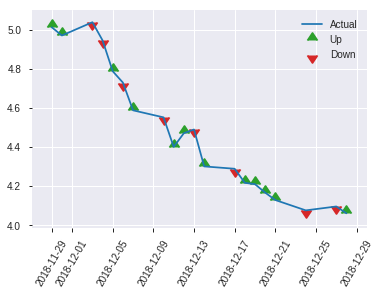


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20801966339955344
RMSE: 0.4560917269580248
LogLoss: 0.6021898345984413
Mean Per-Class Error: 0.282225063938619
AUC: 0.7691176470588235
pr_auc: 0.7205933385315115
Gini: 0.5382352941176469
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.524669071604221: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   64   0.4706   (64.0/136.0)
1      15   100  0.1304   (15.0/115.0)
Total  87   164  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.524669     0.716846  163
max f2                       0.211044     0.821114  221
max f0point5                 0.602937     0.725275  84
max accuracy                 0.602937     0.729084  84
max precision                0.827515     1         0
max recall                   0.115667     1         240
max specificity              0.827515     1         0
max absolute_mcc             0.602937     0.457143  84
max min_per_class_accuracy   0.569864     0.704348  120
max mean_per_class_accuracy  0.601642     0.717775  86

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.815879           2.18261   2.18261            1                0.822538  1                           0.822538            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.803059           1.45507   1.81884            0.666667         0.808766  0.833333                    0.815652            0.0173913       0.0434783                  45.5072   81.8841
    3        0.0318725                   0.776631           1.0913    1.63696            0.5              0.792929  0.75                        0.809972            0.00869565      0.0521739                  9.13043   63.6957
    4        0.0438247                   0.764721           2.18261   1.78577            1                0.766345  0.818182                    0.798074            0.026087        0.0782609                  118.261   78.5771
    5        0.0517928                   0.750604           2.18261   1.84682            1                0.752019  0.846154                    0.790988            0.0173913       0.0956522                  118.261   84.6823
    6        0.103586                    0.722134           1.67893   1.76288            0.769231         0.732885  0.807692                    0.761937            0.0869565       0.182609                   67.893    76.2876
    7        0.151394                    0.69642            1.63696   1.72311            0.75             0.710153  0.789474                    0.745584            0.0782609       0.26087                    63.6957   72.3112
    8        0.203187                    0.649619           1.67893   1.71185            0.769231         0.667885  0.784314                    0.725779            0.0869565       0.347826                   67.893    71.185
    9        0.302789                    0.610003           1.48417   1.63696            0.68             0.628017  0.75                        0.69362             0.147826        0.495652                   48.4174   63.6957
    10       0.40239                     0.58773            1.13496   1.5127             0.52             0.598833  0.693069                    0.670158            0.113043        0.608696                   13.4957   51.2699
    11       0.501992                    0.563569           1.04765   1.42043            0.48             0.575198  0.650794                    0.651317            0.104348        0.713043                   4.76522   42.0428
    12       0.601594                    0.540605           1.04765   1.35871            0.48             0.550195  0.622517                    0.634575            0.104348        0.817391                   4.76522   35.871
    13       0.701195                    0.497857           0.61113   1.25252            0.28             0.520511  0.573864                    0.618373            0.0608696       0.878261                   -38.887   25.252
    14       0.800797                    0.370724           0.436522  1.15103            0.2              0.432799  0.527363                    0.595291            0.0434783       0.921739                   -56.3478  15.1027
    15       0.900398                    0.187106           0.523826  1.08165            0.24             0.272963  0.495575                    0.559636            0.0521739       0.973913                   -47.6174  8.16468
    16       1                           0.0658973          0.261913  1                  0.12             0.127051  0.458167                    0.516549            

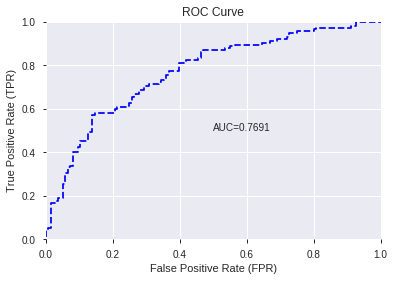

This function is available for GLM models only


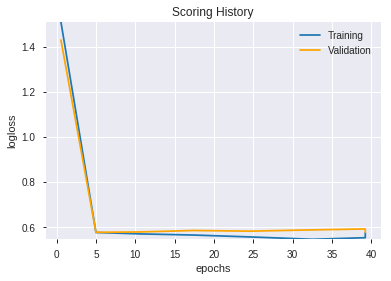

--2019-09-03 02:51:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_024407_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_024407_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLHAMMER',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'PLUS_DI_8',
 'ULTOSC',
 'SIN',
 'STOCH_slowd',
 'STOCHRSI_fastk',
 'aroonup_30',
 'day',
 'CDLDARKCLOUDCOVER',
 'is_month_end',
 'dayofweek',
 'CDLENGULFING',
 'CDLMORNINGSTAR',
 'days_in_month',
 'CDLMARUBOZU',
 'PLUS_DI_24',
 'TRANGE',
 'CDLBELTHOLD',
 'aroondown_30',
 'BETA_14',
 'STOCH_slowk',
 'CDLHANGINGMAN',
 'WILLR_14',
 'CDLGRAVESTONEDOJI',
 'AROONOSC_20',
 'HT_PHASOR_quadrature',
 'WILLR_20',
 'DIV',
 'CDLHIKKAKE',
 'BETA_12',
 'is_quarter_end',
 'STOCHF_fastd',
 'CORREL_8',
 'WILLR_8',
 'weekday',
 'ADOSC',
 'BETA_8',
 'aroonup_8',
 'CDLRICKSHAWMAN',
 'OBV',
 'HT_DCPERIOD',
 'CORREL_12',
 'HT_TRENDMODE']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_025146_model_1  0.758504  0.609797              0.292839  0.460003  0.211603

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.437024           1.000000    0.105136
1            CDLLONGLINE             0.236139           0.540334    0.056809
2                    SUB             0.185673           0.424858    0.044668
3           STOCHF_fastk             0.184314           0.421747    0.044341
4             aroonup_30             0.146985           0.336332    0.035361
5      CDLDARKCLOUDCOVER             0.141243           0.323193    0.033979
6            STOCH_slowd             0.134265           0.307225    0.032300
7              CDLHAMMER             0.127933           0.292737    0.030777
8     CDLCLOSINGMARUBOZU             0.127790           0.292409    0.030743
9      CDLGRAVESTONEDOJI             0.123032           0.281521    0.029598
10                TRANGE             0.122061           0.279300    0.029365
11                ULTOSC             0.115650           0.264632    0.027822
12             PLUS_DI_8             0.106529           0.243760    0.025628
13             aroonup_8             0.102471           0.234474    0.024652
14            PLUS_DI_24             0.095937           0.219524    0.023080
15        is_quarter_end             0.094694           0.216678    0.022781
16                   DIV             0.092264           0.211120    0.022196
17                   OBV             0.091941           0.210380    0.022118
18                 ADOSC             0.090778           0.207719    0.021839
19             CDLTAKURI             0.089974           0.205878    0.021645
20                   SIN             0.082520           0.188823    0.019852
21               BETA_14             0.077762           0.177935    0.018707
22         CDLHANGINGMAN             0.074051           0.169443    0.017815
23             CORREL_12             0.066246           0.151585    0.015937
24            CDLHIKKAKE             0.064679           0.147998    0.015560
25             dayofweek             0.064117           0.146712    0.015425
26               weekday             0.064007           0.146460    0.015398
27                BETA_8             0.064000           0.146446    0.015397
28           AROONOSC_20             0.062042           0.141965    0.014926
29          aroondown_30             0.061629           0.141019    0.014826
30  HT_PHASOR_quadrature             0.059558           0.136281    0.014328
31               WILLR_8             0.056841           0.130063    0.013674
32          CDLENGULFING             0.055147           0.126188    0.013267
33          STOCHF_fastd             0.051729           0.118366    0.012445
34           STOCH_slowk             0.050861           0.116381    0.012236
35        CDLMORNINGSTAR             0.048630           0.111276    0.011699
36          is_month_end             0.046154           0.105610    0.011103
37        STOCHRSI_fastk             0.041580           0.095144    0.010003
38               BETA_12             0.034070           0.077959    0.008196
39          HT_TRENDMODE             0.032897           0.075275    0.007914
40         days_in_month             0.030870           0.070637    0.007426
41              WILLR_14             0.029079           0.066538    0.006996
42              CORREL_8             0.027918           0.063882    0.006716
43           CDLBELTHOLD             0.016055           0.036738    0.003862
44      CDLDRAGONFLYDOJI             0.011541           0.026407    0.002776
45              WILLR_20             0.010881           0.024898    0.002618
46                   day             0.008447           0.019329    0.002032
47           HT_DCPERIOD             0.007588           0.017363    0.001825
48           CDLMARUBOZU             0.005693           0.013026    0.001370
49        CDLRICKSHAWMAN             0.003461           0.007920    0.000833

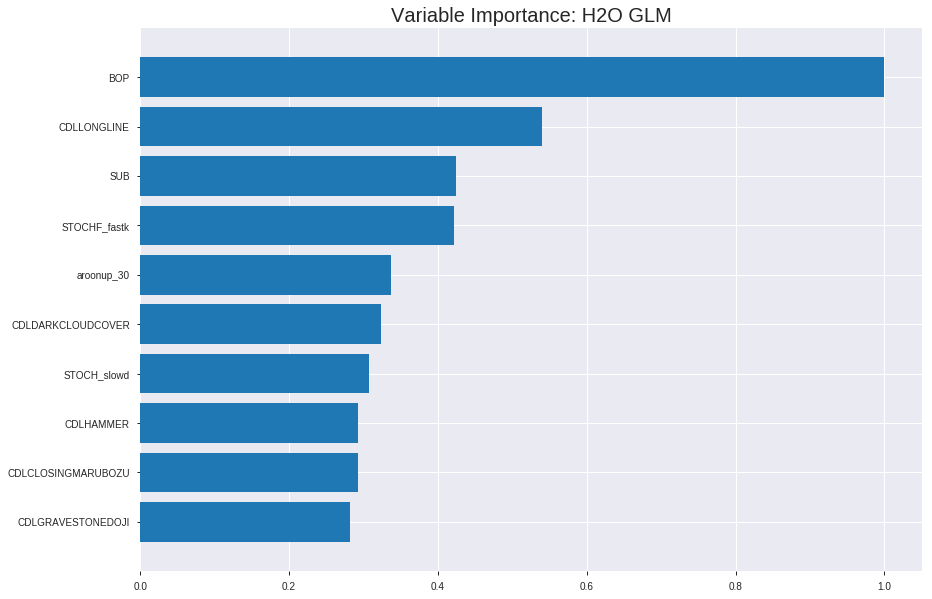

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_025146_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19050654776402748
RMSE: 0.43647055772872867
LogLoss: 0.5627782569018401
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2429.507457396468
Residual deviance: 1974.2261252116555
AIC: 2076.2261252116555
AUC: 0.7820994781503953
pr_auc: 0.7701140198585543
Gini: 0.5641989563007905
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.401604219195454: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      437  410   0.4841   (410.0/847.0)
1      115  792   0.1268   (115.0/907.0)
Total  552  1202  0.2993   (525.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401604     0.751067  256
max f2                       0.270071     0.857367  316
max f0point5                 0.524153     0.729144  194
max accuracy                 0.515996     0.720639  198
max precision                0.947115     1         0
max recall                   0.060933     1         396
max specificity              0.947115     1         0
max absolute_mcc             0.515996     0.440263  198
max min_per_class_accuracy   0.527316     0.713105  192
max mean_per_class_accuracy  0.515996     0.719843  198

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.911596           1.71898   1.71898            0.888889         0.927588  0.888889                    0.927588            0.0176406       0.0176406                  71.8976   71.8976
    2        0.0205245                   0.890802           1.71898   1.71898            0.888889         0.900708  0.888889                    0.914148            0.0176406       0.0352811                  71.8976   71.8976
    3        0.0302166                   0.879479           1.59258   1.67843            0.823529         0.885781  0.867925                    0.905049            0.0154355       0.0507166                  59.2581   67.8434
    4        0.0404789                   0.867185           1.61154   1.66147            0.833333         0.874341  0.859155                    0.897264            0.016538        0.0672547                  61.154    66.1475
    5        0.050171                    0.85706            1.70634   1.67014            0.882353         0.861523  0.863636                    0.890359            0.016538        0.0837927                  70.6336   67.0141
    6        0.100342                    0.803327           1.78002   1.72508            0.920455         0.828538  0.892045                    0.859449            0.0893054       0.173098                   78.0019   72.508
    7        0.149943                    0.764141           1.5782    1.67649            0.816092         0.783409  0.86692                     0.834295            0.07828         0.251378                   57.8198   67.6492
    8        0.200114                    0.724271           1.49434   1.63082            0.772727         0.746585  0.843305                    0.812305            0.0749724       0.326351                   49.4337   63.0823
    9        0.299886                    0.654399           1.33712   1.53311            0.691429         0.687437  0.792776                    0.770761            0.133407        0.459757                   33.7118   53.3108
    10       0.400228                    0.591917           1.29656   1.4738             0.670455         0.622992  0.762108                    0.733714            0.130099        0.589857                   29.6557   47.3801
    11       0.5                         0.531509           1.14926   1.40904            0.594286         0.563883  0.72862                     0.699825            0.114664        0.70452                    14.9258   40.9041
    12       0.599772                    0.470138           0.939298  1.3309             0.485714         0.503842  0.688213                    0.667223            0.0937155       0.798236                   -6.07025  33.0899
    13       0.700114                    0.391997           0.802107  1.25511            0.414773         0.429884  0.649023                    0.633207            0.0804851       0.878721                   -19.7893  25.5111
    14       0.799886                    0.310481           0.651983  1.17988            0.337143         0.350901  0.610121                    0.597994            0.0650496       0.943771                   -34.8017  17.9882
    15       0.899658                    0.198164           0.353618  1.08825            0.182857         0.253836  0.562738                    0.559827            0.0352811       0.979052                   -64.6382  8.8249
    16       1                           0.0241016          0.208768  1                  0.107955         0.13405   0.517104                    0.517104           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19228974806003024
RMSE: 0.4385085495860146
LogLoss: 0.5636909202195802
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 694.5911617977604
Residual deviance: 565.9456839004586
AIC: 667.9456839004586
AUC: 0.780049359127458
pr_auc: 0.7993821117120615
Gini: 0.560098718254916
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3754851381577093: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   151  0.6371   (151.0/237.0)
1      17   248  0.0642   (17.0/265.0)
Total  103  399  0.3347   (168.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375485     0.746988  309
max f2                       0.24722      0.866976  355
max f0point5                 0.589422     0.739857  184
max accuracy                 0.589422     0.719124  184
max precision                0.941093     1         0
max recall                   0.0904897    1         396
max specificity              0.941093     1         0
max absolute_mcc             0.589422     0.439629  184
max min_per_class_accuracy   0.584526     0.709434  189
max mean_per_class_accuracy  0.589422     0.720142  184

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 55.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.912317           1.89434   1.89434            1                0.920849  1                           0.920849            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.906266           1.89434   1.89434            1                0.90929   1                           0.915595            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.901055           1.89434   1.89434            1                0.903195  1                           0.91172             0.0188679       0.0603774                  89.434    89.434
    4        0.0418327                   0.884773           1.89434   1.89434            1                0.88989   1                           0.906522            0.0188679       0.0792453                  89.434    89.434
    5        0.0517928                   0.871153           1.89434   1.89434            1                0.875964  1                           0.900646            0.0188679       0.0981132                  89.434    89.434
    6        0.101594                    0.823651           1.4397    1.67148            0.76             0.844861  0.882353                    0.8733              0.0716981       0.169811                   43.9698   67.1476
    7        0.151394                    0.780793           1.81857   1.71986            0.96             0.79977   0.907895                    0.849113            0.090566        0.260377                   81.8566   71.9861
    8        0.201195                    0.736698           1.51547   1.66927            0.8              0.75655   0.881188                    0.826201            0.0754717       0.335849                   51.5472   66.927
    9        0.300797                    0.686983           1.32604   1.55562            0.7              0.712711  0.821192                    0.788622            0.132075        0.467925                   32.6038   55.5617
    10       0.400398                    0.636227           1.06083   1.43254            0.56             0.658954  0.756219                    0.756366            0.10566         0.573585                   6.08302   43.2535
    11       0.5                         0.586662           1.32604   1.41132            0.7              0.610425  0.74502                     0.727294            0.132075        0.70566                    32.6038   41.1321
    12       0.599602                    0.519628           0.833509  1.31534            0.44             0.554263  0.694352                    0.698551            0.0830189       0.788679                   -16.6491  31.5339
    13       0.699203                    0.449964           0.644075  1.21972            0.34             0.486657  0.643875                    0.668367            0.0641509       0.85283                    -35.5925  21.9717
    14       0.798805                    0.370989           0.833509  1.17156            0.44             0.41425   0.618454                    0.636682            0.0830189       0.935849                   -16.6491  17.1562
    15       0.898406                    0.239654           0.530415  1.10048            0.28             0.303984  0.580931                    0.599797            0.0528302       0.988679                   -46.9585  10.0481
    16       1                           0.0693201          0.111432  1                  0.0588235        0.168001  0.527888                    0.555929            0.0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:51:46  0.000 sec   2            21        51            1.36652           1.36421
    2019-09-03 02:51:46  0.014 sec   4            13        51            1.35682           1.35404
    2019-09-03 02:51:46  0.042 sec   6            8         51            1.34318           1.33969
    2019-09-03 02:51:46  0.066 sec   8            4.9       51            1.32504           1.32054
    2019-09-03 02:51:46  0.080 sec   10           3.1       51            1.30243           1.29658
    2019-09-03 02:51:46  0.095 sec   12           1.9       51            1.27618           1.26867
    2019-09-03 02:51:46  0.109 sec   14           1.2       51            1.24805           1.23875
    2019-09-03 02:51:46  0.123 sec   16           0.74      51            1.2202            1.20923
    2019-09-03 02:51:46  0.143 sec   18           0.46      51            1.19477           1.18265
    2019-09-03 02:51:46  0.159 sec   20           0.28      51            1.17317           1.16091
    2019-09-03 02:51:46  0.173 sec   22           0.18      51            1.15591           1.1449
    2019-09-03 02:51:46  0.189 sec   24           0.11      51            1.14271           1.13454
    2019-09-03 02:51:46  0.209 sec   26           0.068     51            1.13288           1.12906
    2019-09-03 02:51:46  0.226 sec   28           0.042     51            1.12556           1.12738
    2019-09-03 02:51:46  0.239 sec   30           0.026     51            1.11996           1.12857
    2019-09-03 02:51:46  0.254 sec   32           0.016     51            1.11555           1.13192
    2019-09-03 02:51:47  0.271 sec   34           0.01      51            1.11205           1.13682
    2019-09-03 02:51:47  0.284 sec   36           0.0063    51            1.10934           1.14284
    2019-09-03 02:51:47  0.297 sec   38           0.0039    51            1.10738           1.14936

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7142857142857143)

('auc', 0.7585038363171356)

('logloss', 0.6097973540687449)

('mean_per_class_error', 0.2928388746803069)

('rmse', 0.46000283342665754)

('mse', 0.21160260676055323)

glm prediction progress: |████████████████████████████████████████████████| 100%


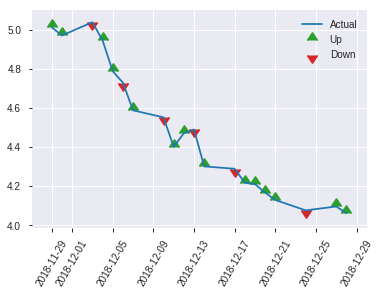


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21160260676055323
RMSE: 0.46000283342665754
LogLoss: 0.6097973540687449
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 349.69104234008756
Residual deviance: 306.11827174251
AIC: 408.11827174251
AUC: 0.7585038363171356
pr_auc: 0.7120763391095958
Gini: 0.5170076726342712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5480937597939304: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   56   0.4118   (56.0/136.0)
1      20   95   0.1739   (20.0/115.0)
Total  100  151  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.548094     0.714286  150
max f2                       0.325305     0.825893  211
max f0point5                 0.641714     0.675676  109
max accuracy                 0.641714     0.701195  109
max precision                0.930737     1         0
max recall                   0.138931     1         243
max specificity              0.930737     1         0
max absolute_mcc             0.548094     0.421666  150
max min_per_class_accuracy   0.615224     0.691176  121
max mean_per_class_accuracy  0.548094     0.707161  150

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 56.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.921585           2.18261   2.18261            1                0.927601  1                           0.927601            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.911811           1.45507   1.81884            0.666667         0.916848  0.833333                    0.922225            0.0173913       0.0434783                  45.5072   81.8841
    3        0.0318725                   0.894767           2.18261   1.90978            1                0.901547  0.875                       0.917055            0.0173913       0.0608696                  118.261   90.9783
    4        0.0438247                   0.883476           1.45507   1.78577            0.666667         0.886923  0.818182                    0.908837            0.0173913       0.0782609                  45.5072   78.5771
    5        0.0517928                   0.871137           2.18261   1.84682            1                0.874724  0.846154                    0.903589            0.0173913       0.0956522                  118.261   84.6823
    6        0.103586                    0.825234           2.01472   1.93077            0.923077         0.844218  0.884615                    0.873903            0.104348        0.2                        101.472   93.0769
    7        0.151394                    0.79377            1.81884   1.89542            0.833333         0.804978  0.868421                    0.852138            0.0869565       0.286957                   81.8841   89.5423
    8        0.203187                    0.743063           0.839465  1.62626            0.384615         0.770505  0.745098                    0.831329            0.0434783       0.330435                   -16.0535  62.6257
    9        0.302789                    0.698704           1.22226   1.49336            0.56             0.716465  0.684211                    0.793545            0.121739        0.452174                   22.2261   49.3364
    10       0.40239                     0.658586           1.48417   1.49109            0.68             0.678968  0.683168                    0.765184            0.147826        0.6                        48.4174   49.1089
    11       0.501992                    0.607248           1.04765   1.40311            0.48             0.632706  0.642857                    0.738899            0.104348        0.704348                   4.76522   40.3106
    12       0.601594                    0.548094           1.22226   1.37316            0.56             0.577493  0.629139                    0.712176            0.121739        0.826087                   22.2261   37.3164
    13       0.701195                    0.478912           0.61113   1.26492            0.28             0.507774  0.579545                    0.683142            0.0608696       0.886957                   -38.887   26.4921
    14       0.800797                    0.362475           0.523826  1.17274            0.24             0.416464  0.537313                    0.649973            0.0521739       0.93913                    -47.6174  17.2745
    15       0.900398                    0.239033           0.349217  1.08165            0.16             0.311337  0.495575                    0.612513            0.0347826       0.973913                   -65.0783  8.16468
    16       1                           0.0718526          0.261913  1                  0.12             0.16888   0.458167                    0.568327         

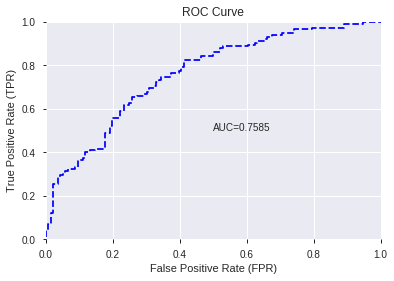

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


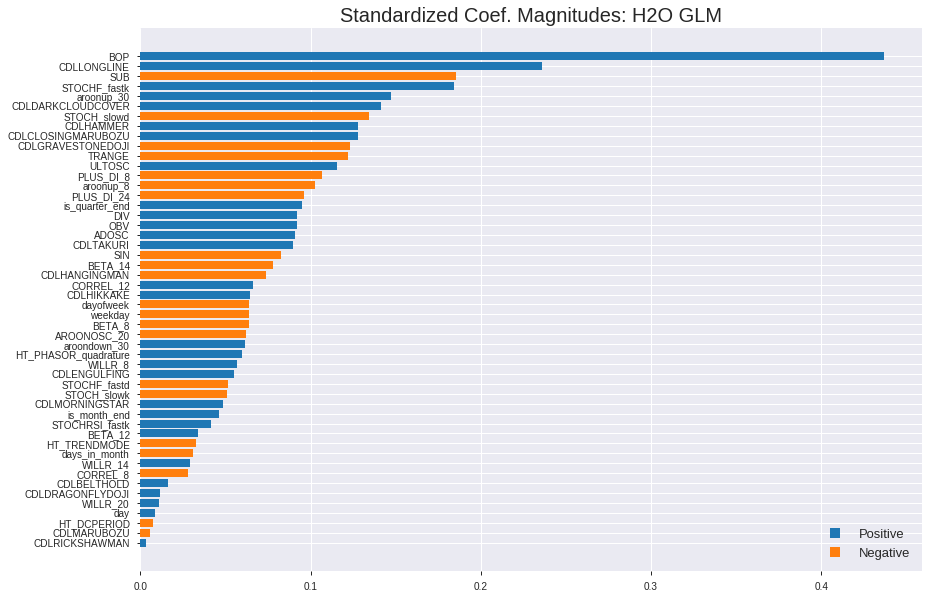

'log_likelihood'
--2019-09-03 02:51:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_025146_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_025146_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLLONGLINE',
 'SUB',
 'STOCHF_fastk',
 'aroonup_30',
 'CDLDARKCLOUDCOVER',
 'STOCH_slowd',
 'CDLHAMMER',
 'CDLCLOSINGMARUBOZU',
 'CDLGRAVESTONEDOJI',
 'TRANGE',
 'ULTOSC',
 'PLUS_DI_8',
 'aroonup_8',
 'PLUS_DI_24',
 'is_quarter_end',
 'DIV',
 'OBV',
 'ADOSC',
 'CDLTAKURI',
 'SIN',
 'BETA_14',
 'CDLHANGINGMAN',
 'CORREL_12',
 'CDLHIKKAKE',
 'dayofweek',
 'weekday',
 'BETA_8',
 'AROONOSC_20',
 'aroondown_30',
 'HT_PHASOR_quadrature',
 'WILLR_8',
 'CDLENGULFING',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLMORNINGSTAR',
 'is_month_end',
 'STOCHRSI_fastk',
 'BETA_12',
 'HT_TRENDMODE',
 'days_in_month',
 'WILLR_14',
 'CORREL_8',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'WILLR_20',
 'day',
 'HT_DCPERIOD',
 'CDLMARUBOZU',
 'CDLRICKSHAWMAN']

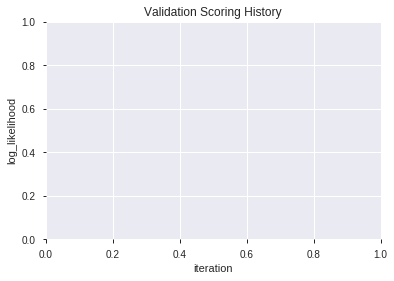

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_025157_model_4  0.741432  0.609721              0.339930  0.460945  0.212470
1               XGBoost_3_AutoML_20190903_025157  0.741368  0.616138              0.343606  0.463090  0.214452
2  XGBoost_grid_1_AutoML_20190903_025157_model_2  0.740217  0.616004              0.346292  0.463050  0.214416
3  XGBoost_grid_1_AutoML_20190903_025157_model_1  0.736317  0.618200              0.339930  0.464703  0.215948
4  XGBoost_grid_1_AutoML_20190903_025157_model_3  0.725895  0.629941              0.348625  0.469947  0.220850
5  XGBoost_grid_1_AutoML_20190903_025157_model_7  0.725703  0.632656              0.350288  0.470853  0.221702
6               XGBoost_2_AutoML_20190903_025157  0.725064  0.619565              0.350639  0.465472  0.216664
7               XGBoost_1_AutoML_20190903_025157  0.723338  0.628510              0.351630  0.468471  0.219465
8  XGBoost_grid_1_AutoML_20190903_025157_model_6  0.722762  0.639867              0.349648  0.474484  0.225135
9  XGBoost_grid_1_AutoML_20190903_025157_model_5  0.708951  0.667087              0.349616  0.482953  0.233244

variable  relative_importance  scaled_importance  percentage
0                    BOP          2113.450684           1.000000    0.409753
1           STOCHF_fastk           443.675323           0.209929    0.086019
2                    SUB           356.022797           0.168456    0.069025
3              aroonup_8           177.618820           0.084042    0.034436
4            STOCH_slowd           164.153824           0.077671    0.031826
5              dayofweek           124.090935           0.058715    0.024059
6               WILLR_14           123.978432           0.058662    0.024037
7                 ULTOSC           118.150803           0.055904    0.022907
8                    DIV           113.399017           0.053656    0.021986
9            STOCH_slowk           110.034264           0.052064    0.021333
10               WILLR_8           104.476791           0.049434    0.020256
11             PLUS_DI_8           103.054497           0.048761    0.019980
12              WILLR_20            96.701729           0.045755    0.018748
13              CORREL_8            91.594887           0.043339    0.017758
14                   SIN            89.739883           0.042461    0.017399
15                   OBV            75.555954           0.035750    0.014649
16                 ADOSC            71.804832           0.033975    0.013921
17  HT_PHASOR_quadrature            68.520744           0.032421    0.013285
18                   day            64.790642           0.030656    0.012562
19                BETA_8            62.511772           0.029578    0.012120
20                TRANGE            60.895275           0.028813    0.011806
21          aroondown_30            52.706306           0.024939    0.010219
22               BETA_14            52.666981           0.024920    0.010211
23             CORREL_12            51.512630           0.024374    0.009987
24            PLUS_DI_24            51.455791           0.024347    0.009976
25           HT_DCPERIOD            39.659790           0.018765    0.007689
26           CDLLONGLINE            38.805557           0.018361    0.007524
27            aroonup_30            34.835567           0.016483    0.006754
28        STOCHRSI_fastk            29.361235           0.013893    0.005693
29               BETA_12            28.683056           0.013572    0.005561
30           AROONOSC_20            25.377007           0.012007    0.004920
31         days_in_month            10.552311           0.004993    0.002046
32          HT_TRENDMODE             8.029536           0.003799    0.001557

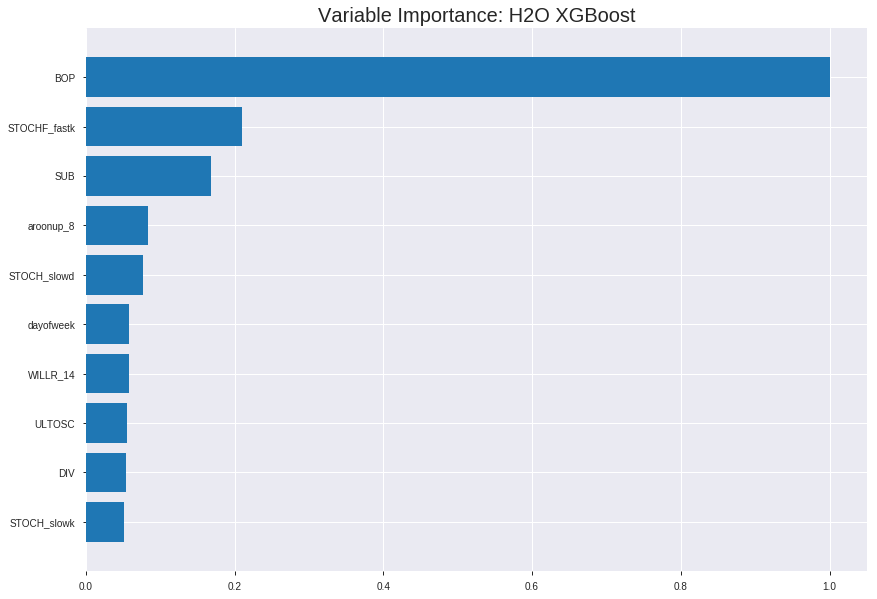

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_025157_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17597900565699343
RMSE: 0.4194985168710295
LogLoss: 0.5305630040636403
Mean Per-Class Error: 0.24834456913238112
AUC: 0.8233912023628371
pr_auc: 0.8221392760256451
Gini: 0.6467824047256743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4071703106164932: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      466  381   0.4498   (381.0/847.0)
1      96   811   0.1058   (96.0/907.0)
Total  562  1192  0.2719   (477.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40717      0.772749  252
max f2                       0.266767     0.865724  321
max f0point5                 0.581919     0.767123  164
max accuracy                 0.505343     0.753136  204
max precision                0.879884     1         0
max recall                   0.141589     1         383
max specificity              0.879884     1         0
max absolute_mcc             0.505343     0.505746  204
max min_per_class_accuracy   0.539956     0.747344  186
max mean_per_class_accuracy  0.505343     0.751655  204

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.862357           1.93385   1.93385            1                0.870149  1                           0.870149            0.0198456       0.0198456                  93.3848   93.3848
    2        0.0205245                   0.85361            1.82641   1.88013            0.944444         0.858426  0.972222                    0.864287            0.0187431       0.0385888                  82.6412   88.013
    3        0.0302166                   0.845812           1.70634   1.82438            0.882353         0.849621  0.943396                    0.859583            0.016538        0.0551268                  70.6336   82.4385
    4        0.0404789                   0.837888           1.71898   1.79766            0.888889         0.841768  0.929577                    0.855067            0.0176406       0.0727674                  71.8976   79.7661
    5        0.050171                    0.829353           1.93385   1.82397            1                0.833337  0.943182                    0.850869            0.0187431       0.0915105                  93.3848   82.397
    6        0.100342                    0.786354           1.78002   1.80199            0.920455         0.810676  0.931818                    0.830773            0.0893054       0.180816                   78.0019   80.1995
    7        0.149943                    0.752666           1.64488   1.75002            0.850575         0.770712  0.904943                    0.810905            0.0815877       0.262404                   64.4882   75.0022
    8        0.200114                    0.724798           1.58224   1.70796            0.818182         0.738535  0.883191                    0.792761            0.0793826       0.341786                   58.2239   70.7957
    9        0.299886                    0.664868           1.42552   1.61399            0.737143         0.696265  0.834601                    0.760656            0.142227        0.484013                   42.5522   61.3991
    10       0.400228                    0.604505           1.31853   1.53992            0.681818         0.634407  0.796296                    0.729004            0.132304        0.616318                   31.8533   53.9916
    11       0.5                         0.543065           1.20451   1.47299            0.622857         0.575041  0.761688                    0.698282            0.120176        0.736494                   20.4511   47.2988
    12       0.599772                    0.47199            0.939298  1.38421            0.485714         0.506528  0.715779                    0.666384            0.0937155       0.830209                   -6.07025  38.4209
    13       0.700114                    0.389443           0.736181  1.29133            0.380682         0.431696  0.667752                    0.632748            0.0738699       0.904079                   -26.3819  29.1332
    14       0.799886                    0.299606           0.497275  1.19229            0.257143         0.348219  0.616536                    0.597258            0.0496141       0.953693                   -50.2725  19.2287
    15       0.899658                    0.200397           0.320466  1.0956             0.165714         0.249066  0.56654                     0.558643            0.0319735       0.985667                   -67.9534  9.5602
    16       1                           0.0999441          0.142841  1                  0.0738636        0.152013  0.517104                    0.517841            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1962633438593364
RMSE: 0.44301618916167884
LogLoss: 0.5749843628983405
Mean Per-Class Error: 0.29975320436271
AUC: 0.7693734575272669
pr_auc: 0.7742346306951416
Gini: 0.5387469150545339
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38845622539520264: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      85   152  0.6414   (152.0/237.0)
1      16   249  0.0604   (16.0/265.0)
Total  101  401  0.3347   (168.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388456     0.747748  311
max f2                       0.303872     0.866089  344
max f0point5                 0.59041      0.71607   182
max accuracy                 0.530809     0.705179  227
max precision                0.874434     1         0
max recall                   0.185709     1         374
max specificity              0.874434     1         0
max absolute_mcc             0.52277      0.408283  229
max min_per_class_accuracy   0.574591     0.687764  197
max mean_per_class_accuracy  0.530809     0.700247  227

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 54.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.863387           1.57862   1.57862            0.833333         0.866565  0.833333                    0.866565            0.0188679       0.0188679                  57.8616   57.8616
    2        0.0219124                   0.849412           1.89434   1.72213            1                0.85473   0.909091                    0.861186            0.0188679       0.0377358                  89.434    72.2127
    3        0.0318725                   0.835922           1.89434   1.77594            1                0.841651  0.9375                      0.855081            0.0188679       0.0566038                  89.434    77.5943
    4        0.0418327                   0.826773           1.51547   1.71393            0.8              0.83001   0.904762                    0.849112            0.0150943       0.0716981                  51.5472   71.3926
    5        0.0517928                   0.822829           1.89434   1.74862            1                0.823702  0.923077                    0.844225            0.0188679       0.090566                   89.434    74.8621
    6        0.101594                    0.775575           1.66702   1.70862            0.88             0.802936  0.901961                    0.823986            0.0830189       0.173585                   66.7019   70.862
    7        0.151394                    0.747891           1.66702   1.69494            0.88             0.760564  0.894737                    0.803123            0.0830189       0.256604                   66.7019   69.4935
    8        0.201195                    0.718703           1.36392   1.613              0.72             0.731604  0.851485                    0.78542             0.0679245       0.324528                   36.3925   61.3002
    9        0.300797                    0.670094           1.25026   1.49289            0.66             0.695055  0.788079                    0.755498            0.124528        0.449057                   25.0264   49.289
    10       0.400398                    0.619158           1.21238   1.42311            0.64             0.641451  0.751244                    0.727128            0.120755        0.569811                   21.2377   42.3111
    11       0.5                         0.576785           1.1366    1.36604            0.6              0.597873  0.721116                    0.70138             0.113208        0.683019                   13.6604   36.6038
    12       0.599602                    0.530215           1.06083   1.31534            0.56             0.557389  0.694352                    0.677461            0.10566         0.788679                   6.08302   31.5339
    13       0.699203                    0.462728           0.795623  1.24131            0.42             0.496905  0.655271                    0.651741            0.0792453       0.867925                   -20.4377  24.1305
    14       0.798805                    0.387093           0.719849  1.17629            0.38             0.425965  0.620948                    0.623589            0.0716981       0.939623                   -28.0151  17.6286
    15       0.898406                    0.268296           0.454642  1.09628            0.24             0.331303  0.578714                    0.591185            0.045283        0.984906                   -54.5358  9.62808
    16       1                           0.0954008          0.148576  1                  0.0784314        0.178584  0.527888                    0.549268           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:52:07  4.387 sec   0                  0.5              0.693147            0.5             0                  1                0.482896                         0.5                0.693147              0.5               0                    1                  0.472112
    2019-09-03 02:52:07  4.518 sec   5                  0.478539         0.650893            0.781011        0.737395           1.80492          0.330673                         0.481856           0.65733               0.773505          0.725878             1.74862            0.306773
    2019-09-03 02:52:07  4.585 sec   10                 0.464143         0.622717            0.785811        0.743887           1.80492          0.32041                          0.470115           0.63418               0.769397          0.731763             1.74862            0.316733
    2019-09-03 02:52:07  4.652 sec   15                 0.454034         0.602619            0.789381        0.773316           1.82641          0.312999                         0.462421           0.618673              0.764374          0.758031             1.74862            0.318725
    2019-09-03 02:52:07  4.726 sec   20                 0.446291         0.586874            0.793901        0.791938           1.93385          0.307868                         0.455664           0.604803              0.769907          0.771721             1.57862            0.326693
    2019-09-03 02:52:07  4.798 sec   25                 0.441219         0.576283            0.797144        0.795046           1.93385          0.302166                         0.451678           0.596314              0.772295          0.770386             1.62372            0.322709
    2019-09-03 02:52:07  4.869 sec   30                 0.436977         0.567447            0.800891        0.801227           1.93385          0.286203                         0.448688           0.589949              0.775098          0.772055             1.57862            0.326693
    2019-09-03 02:52:07  4.938 sec   35                 0.433732         0.560498            0.803911        0.80102            1.93385          0.292474                         0.446252           0.584306              0.775543          0.779927             1.89434            0.306773
    2019-09-03 02:52:07  5.009 sec   40                 0.431153         0.555034            0.806752        0.802846           1.93385          0.268529                         0.44562            0.582557              0.772239          0.776409             1.57862            0.290837
    2019-09-03 02:52:07  5.099 sec   45                 0.428601         0.549599            0.809884        0.803683           1.93385          0.267389                         0.444844           0.580585              0.771388          0.771262             1.57862            0.296813
    2019-09-03 02:52:08  5.182 sec   50                 0.425999         0.544508            0.814267        0.810737           1.93385          0.275941                         0.444398           0.579212              0.770974          0.773292             1.57862            0.320717
    2019-09-03 02:52:08  5.271 sec   55                 0.423627         0.539316            0.817595        0.817917           1.93385          0.27309                          0.44347            0.576814              0.770353          0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             2113.45068359375       1.0                    0.4097527927460727
STOCHF_fastk    443.6753234863281      0.2099293477394488     0.08601913651560059
SUB             356.0227966308594      0.1684556916300842     0.06902519009939821
aroonup_8       177.6188201904297      0.08404209360987       0.034436482564871106
STOCH_slowd     164.15382385253906     0.07767099801610176    0.031825908352472364
---             ---                    ---                    ---
STOCHRSI_fastk  29.361234664916992     0.013892557272730213   0.005692514140885968
BETA_12         28.683055877685547     0.013571670302196196   0.0055610298085538275
AROONOSC_20     25.37700653076172      0.01200738050230261    0.004920057694383236
days_in_month   10.552310943603516     0.00499292982113033    0.0020458669381933016
HT_TRENDMODE    8.029536247253418      0.0037992541342861375  0.0015567549918758074


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772908366533864)

('F1', 0.7016393442622951)

('auc', 0.7414322250639386)

('logloss', 0.6097214547639608)

('mean_per_class_error', 0.32528772378516624)

('rmse', 0.4609446832884289)

('mse', 0.21247000105187003)

xgboost prediction progress: |████████████████████████████████████████████| 100%


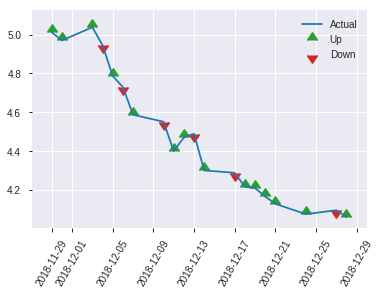


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21247000105187003
RMSE: 0.4609446832884289
LogLoss: 0.6097214547639608
Mean Per-Class Error: 0.32528772378516624
AUC: 0.7414322250639386
pr_auc: 0.7012951143956084
Gini: 0.48286445012787715
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40449655055999756: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   83   0.6103   (83.0/136.0)
1      8    107  0.0696   (8.0/115.0)
Total  61   190  0.3625   (91.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404497     0.701639  189
max f2                       0.254795     0.834543  228
max f0point5                 0.656867     0.652632  89
max accuracy                 0.656867     0.677291  89
max precision                0.883938     1         0
max recall                   0.254795     1         228
max specificity              0.883938     1         0
max absolute_mcc             0.404497     0.371893  189
max min_per_class_accuracy   0.593714     0.669118  121
max mean_per_class_accuracy  0.558567     0.674712  137

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 54.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.86838            2.18261   2.18261            1                0.876866  1                           0.876866            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.856056           2.18261   2.18261            1                0.861271  1                           0.869069            0.026087        0.0521739                  118.261   118.261
    3        0.0318725                   0.840904           2.18261   2.18261            1                0.842373  1                           0.862395            0.0173913       0.0695652                  118.261   118.261
    4        0.0438247                   0.83144            1.45507   1.98419            0.666667         0.834587  0.909091                    0.854811            0.0173913       0.0869565                  45.5072   98.419
    5        0.0517928                   0.819926           2.18261   2.01472            1                0.825764  0.923077                    0.850342            0.0173913       0.104348                   118.261   101.472
    6        0.103586                    0.776337           1.67893   1.84682            0.769231         0.795807  0.846154                    0.823075            0.0869565       0.191304                   67.893    84.6823
    7        0.151394                    0.75703            1.27319   1.66568            0.583333         0.766317  0.763158                    0.805151            0.0608696       0.252174                   27.3188   66.5675
    8        0.203187                    0.720308           1.51104   1.62626            0.692308         0.737402  0.745098                    0.787882            0.0782609       0.330435                   51.1037   62.6257
    9        0.302789                    0.676236           1.30957   1.52208            0.6              0.693712  0.697368                    0.756905            0.130435        0.46087                    30.9565   52.2082
    10       0.40239                     0.636045           1.13496   1.42626            0.52             0.657323  0.653465                    0.732256            0.113043        0.573913                   13.4957   42.6259
    11       0.501992                    0.59106            1.04765   1.35114            0.48             0.611703  0.619048                    0.708337            0.104348        0.678261                   4.76522   35.1139
    12       0.601594                    0.516573           0.960348  1.28644            0.44             0.550921  0.589404                    0.682274            0.0956522       0.773913                   -3.96522  28.6438
    13       0.701195                    0.438915           0.960348  1.24012            0.44             0.477212  0.568182                    0.653146            0.0956522       0.869565                   -3.96522  24.0119
    14       0.800797                    0.36461            0.698435  1.17274            0.32             0.405069  0.537313                    0.622291            0.0695652       0.93913                    -30.1565  17.2745
    15       0.900398                    0.275353           0.436522  1.0913             0.2              0.322344  0.5                         0.589111            0.0434783       0.982609                   -56.3478  9.13043
    16       1                           0.103656           0.174609  1                  0.08             0.180361  0.458167                    0.548399          

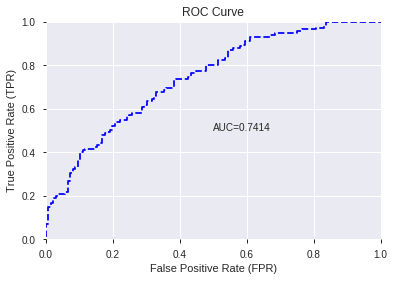

This function is available for GLM models only


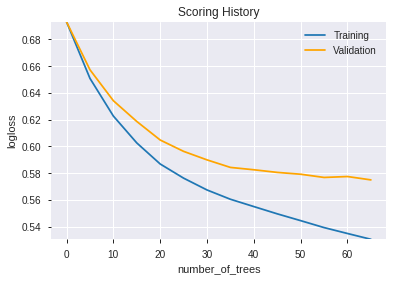

--2019-09-03 02:52:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.233.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.233.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_025157_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_025157_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'aroonup_8',
 'STOCH_slowd',
 'dayofweek',
 'WILLR_14',
 'ULTOSC',
 'DIV',
 'STOCH_slowk',
 'WILLR_8',
 'PLUS_DI_8',
 'WILLR_20',
 'CORREL_8',
 'SIN',
 'OBV',
 'ADOSC',
 'HT_PHASOR_quadrature',
 'day',
 'BETA_8',
 'TRANGE',
 'aroondown_30',
 'BETA_14',
 'CORREL_12',
 'PLUS_DI_24',
 'HT_DCPERIOD',
 'CDLLONGLINE',
 'aroonup_30',
 'STOCHRSI_fastk',
 'BETA_12',
 'AROONOSC_20',
 'days_in_month',
 'HT_TRENDMODE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

32

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_025229_model_5  0.759527  0.595211              0.330595  0.452454  0.204715
1  DeepLearning_grid_1_AutoML_20190903_025229_model_9  0.753133  0.601078              0.342615  0.454900  0.206934
2  DeepLearning_grid_1_AutoML_20190903_025229_model_6  0.751982  0.607961              0.302877  0.459538  0.211175
3  DeepLearning_grid_1_AutoML_20190903_025229_model_7  0.739130  0.621391              0.336605  0.464375  0.215644
4  DeepLearning_grid_1_AutoML_20190903_025229_model_8  0.739003  0.605295              0.322251  0.460211  0.211794
5  DeepLearning_grid_1_AutoML_20190903_025229_model_2  0.729668  0.626569              0.348306  0.466834  0.217934
6  DeepLearning_grid_1_AutoML_20190903_025229_model_3  0.725256  0.662749              0.345972  0.479871  0.230276
7               DeepLearning_1_AutoML_20190903_025229  0.701535  0.666897              0.325927  0.481103  0.231461
8  DeepLearning_grid_1_AutoML_20190903_025229_model_4  0.696675  0.722140              0.323242  0.497156  0.247164
9  DeepLearning_grid_1_AutoML_20190903_025229_model_1  0.674361  0.752715              0.372379  0.506949  0.256997

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.058777
1                  SUB             0.737790           0.737790    0.043365
2          CDLLONGLINE             0.709046           0.709046    0.041676
3                  DIV             0.649172           0.649172    0.038157
4         STOCHF_fastk             0.631903           0.631903    0.037142
5               TRANGE             0.629831           0.629831    0.037020
6   CDLCLOSINGMARUBOZU             0.611680           0.611680    0.035953
7    CDLDARKCLOUDCOVER             0.553388           0.553388    0.032527
8          CDLMARUBOZU             0.532186           0.532186    0.031281
9               ULTOSC             0.528689           0.528689    0.031075
10               ADOSC             0.507578           0.507578    0.029834
11        CDLENGULFING             0.498425           0.498425    0.029296
12      STOCHRSI_fastk             0.493773           0.493773    0.029023
13      STOCHRSI_fastd             0.493337           0.493337    0.028997
14        STOCHF_fastd             0.492538           0.492538    0.028950
15              RSI_14             0.488692           0.488692    0.028724
16            WILLR_30             0.485380           0.485380    0.028529
17         STOCH_slowk             0.485057           0.485057    0.028510
18              CMO_14             0.484973           0.484973    0.028505
19              CCI_12             0.482678           0.482678    0.028371
20            WILLR_12             0.480462           0.480462    0.028240
21               CCI_8             0.476445           0.476445    0.028004
22            WILLR_14             0.475460           0.475460    0.027946
23               RSI_8             0.473203           0.473203    0.027814
24             WILLR_8             0.464087           0.464087    0.027278
25         CDLBELTHOLD             0.460036           0.460036    0.027040
26              RSI_12             0.459545           0.459545    0.027011
27               CMO_8             0.455661           0.455661    0.026783
28              CMO_12             0.451625           0.451625    0.026545
29            WILLR_24             0.446544           0.446544    0.026247
30              CCI_14             0.443325           0.443325    0.026058
31            WILLR_20             0.430830           0.430830    0.025323

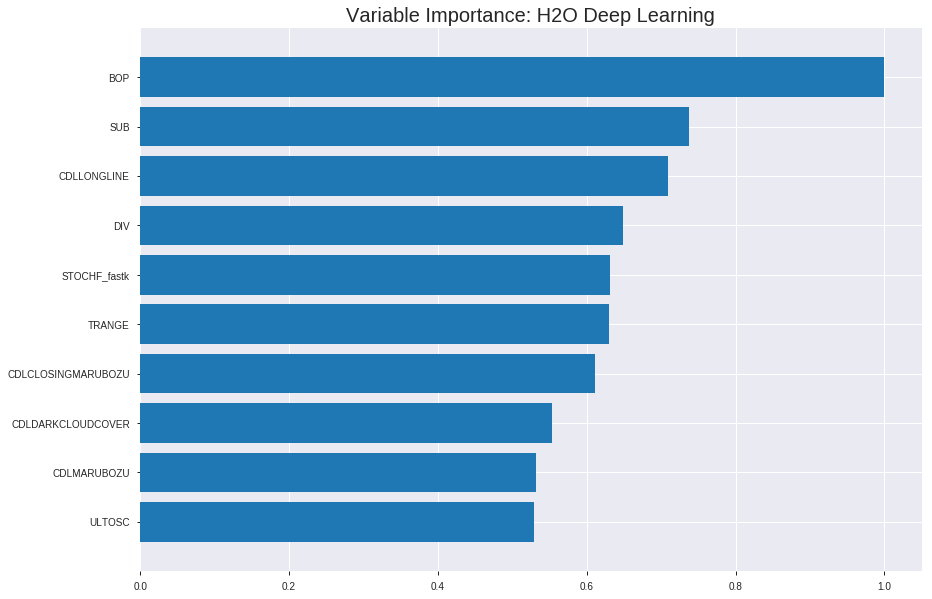

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_025229_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20123176953770136
RMSE: 0.4485886417840975
LogLoss: 0.5868864845313886
Mean Per-Class Error: 0.3139181155618962
AUC: 0.7548595535966489
pr_auc: 0.7522572621970742
Gini: 0.5097191071932978
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25576432426761747: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      272  575   0.6789   (575.0/847.0)
1      39   868   0.043    (39.0/907.0)
Total  311  1443  0.3501   (614.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.255764     0.738723  311
max f2                       0.238216     0.856413  317
max f0point5                 0.509738     0.692339  212
max accuracy                 0.472573     0.689282  228
max precision                0.997119     1         0
max recall                   0.0452387    1         385
max specificity              0.997119     1         0
max absolute_mcc             0.472573     0.382504  228
max min_per_class_accuracy   0.558061     0.676505  187
max mean_per_class_accuracy  0.506628     0.686082  214

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 53.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.992469           1.93385   1.93385            1                0.994969   1                           0.994969            0.0198456       0.0198456                  93.3848   93.3848
    2        0.0205245                   0.981427           1.82641   1.88013            0.944444         0.988066   0.972222                    0.991518            0.0187431       0.0385888                  82.6412   88.013
    3        0.0302166                   0.963911           1.82009   1.86087            0.941176         0.973535   0.962264                    0.985749            0.0176406       0.0562293                  82.0092   86.0872
    4        0.0404789                   0.953588           1.93385   1.87937            1                0.958029   0.971831                    0.978722            0.0198456       0.076075                   93.3848   87.9373
    5        0.050171                    0.94636            1.36507   1.78002            0.705882         0.949722   0.920455                    0.97312             0.0132304       0.0893054                  36.5069   78.0019
    6        0.100342                    0.883814           1.56026   1.67014            0.806818         0.915321   0.863636                    0.94422             0.07828         0.167585                   56.0264   67.0141
    7        0.149943                    0.822989           1.4226    1.58826            0.735632         0.855605   0.821293                    0.914906            0.0705623       0.238148                   42.2601   58.8255
    8        0.200114                    0.774805           1.47236   1.5592             0.761364         0.79681    0.806268                    0.885298            0.0738699       0.312018                   47.2361   55.9199
    9        0.299886                    0.703955           1.34817   1.48899            0.697143         0.737518   0.769962                    0.836132            0.134509        0.446527                   34.8168   48.8989
    10       0.400228                    0.631163           1.12075   1.39667            0.579545         0.668829   0.722222                    0.794187            0.112459        0.558986                   12.0753   39.6668
    11       0.5                         0.56181            1.11611   1.34068            0.577143         0.597259   0.693273                    0.754891            0.111356        0.670342                   11.6106   34.0684
    12       0.599772                    0.490175           1.08295   1.29781            0.56             0.526093   0.671103                    0.716831            0.108049        0.77839                    8.29548   29.781
    13       0.700114                    0.400112           0.857046  1.23464            0.443182         0.448669   0.638436                    0.678397            0.0859978       0.864388                   -14.2954  23.4639
    14       0.799886                    0.287946           0.718286  1.17023            0.371429         0.348431   0.605132                    0.637239            0.0716648       0.936053                   -28.1714  17.0233
    15       0.899658                    0.133255           0.442022  1.08947            0.228571         0.207318   0.563371                    0.589561            0.0441014       0.980154                   -55.7978  8.94745
    16       1                           0.00366068         0.19778   1                  0.102273         0.0727102  0.517104                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19149337268398745
RMSE: 0.43759955745405804
LogLoss: 0.5589374514870742
Mean Per-Class Error: 0.2848499323302285
AUC: 0.7770718891807976
pr_auc: 0.7866329302711459
Gini: 0.5541437783615952
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4225558246101108: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      105  132  0.557    (132.0/237.0)
1      25   240  0.0943   (25.0/265.0)
Total  130  372  0.3127   (157.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422556     0.753532  285
max f2                       0.130169     0.865447  370
max f0point5                 0.575394     0.737101  184
max accuracy                 0.575394     0.713147  184
max precision                0.997886     1         0
max recall                   0.130169     1         370
max specificity              0.997886     1         0
max absolute_mcc             0.575394     0.430122  184
max min_per_class_accuracy   0.562578     0.704641  196
max mean_per_class_accuracy  0.575394     0.71515   184

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 55.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.990411           1.89434   1.89434            1                0.99407   1                           0.99407             0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.970509           1.89434   1.89434            1                0.980652  1                           0.987971            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.955124           1.89434   1.89434            1                0.959359  1                           0.97903             0.0188679       0.0603774                  89.434    89.434
    4        0.0418327                   0.941317           1.51547   1.80413            0.8              0.949314  0.952381                    0.971955            0.0150943       0.0754717                  51.5472   80.4133
    5        0.0517928                   0.930588           1.89434   1.82148            1                0.933496  0.961538                    0.964559            0.0188679       0.0943396                  89.434    82.148
    6        0.101594                    0.856708           1.51547   1.67148            0.8              0.897628  0.882353                    0.93175             0.0754717       0.169811                   51.5472   67.1476
    7        0.151394                    0.7884             1.74279   1.69494            0.92             0.819409  0.894737                    0.894796            0.0867925       0.256604                   74.2792   69.4935
    8        0.201195                    0.743802           1.1366    1.55673            0.6              0.765073  0.821782                    0.862686            0.0566038       0.313208                   13.6604   55.6735
    9        0.300797                    0.677826           1.47758   1.53053            0.78             0.710391  0.807947                    0.812257            0.14717         0.460377                   47.7585   53.0526
    10       0.400398                    0.6222             1.28815   1.47023            0.68             0.648034  0.776119                    0.771406            0.128302        0.588679                   28.8151   47.0234
    11       0.5                         0.565781           1.09872   1.39623            0.58             0.594481  0.737052                    0.736162            0.109434        0.698113                   9.8717    39.6226
    12       0.599602                    0.516482           0.871396  1.30905            0.46             0.542624  0.69103                     0.704013            0.0867925       0.784906                   -12.8604  30.9045
    13       0.699203                    0.456793           0.795623  1.23591            0.42             0.486726  0.652422                    0.67306             0.0792453       0.864151                   -20.4377  23.5908
    14       0.798805                    0.364897           0.719849  1.17156            0.38             0.412786  0.618454                    0.640607            0.0716981       0.935849                   -28.0151  17.1562
    15       0.898406                    0.186851           0.416755  1.08788            0.22             0.278495  0.574279                    0.600462            0.0415094       0.977358                   -58.3245  8.78802
    16       1                           0.0132903          0.222863  1                  0.117647         0.106468  0.527888                    0.550275            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:56:21  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:56:22  1 min 37.393 sec  1227 obs/sec      1         1             1754       0.448516         0.585784            0.194391       0.752386        0.74692            1.82641          0.334664                         0.442541           0.572239              0.214186         0.770241          0.782943             1.89434            0.322709
    2019-09-03 02:56:28  1 min 43.087 sec  2393 obs/sec      9         9             15786      0.448589         0.586886            0.19413        0.75486         0.752257           1.93385          0.350057                         0.4376             0.558937              0.231636         0.777072          0.786633             1.89434            0.312749
    2019-09-03 02:56:33  1 min 48.465 sec  2299 obs/sec      15        15            26310      0.44358          0.572916            0.212026       0.765562        0.760362           1.93385          0.332383                         0.443425           0.571166              0.211042         0.769811          0.780799             1.89434            0.302789
    2019-09-03 02:56:39  1 min 53.807 sec  2588 obs/sec      24        24            42096      0.440484         0.566292            0.222985       0.771957        0.768169           1.93385          0.312429                         0.441926           0.569516              0.216369         0.782868          0.795707             1.89434            0.300797
    2019-09-03 02:56:44  1 min 59.511 sec  2780 obs/sec      34        34            59636      0.436743         0.558111            0.236127       0.780774        0.774983           1.93385          0.314709                         0.441755           0.567523              0.216976         0.782095          0.795293             1.89434            0.304781
    2019-09-03 02:56:50  2 min  5.142 sec  2906 obs/sec      44        44            77176      0.434877         0.553775            0.24264        0.786282        0.782436           1.93385          0.302166                         0.446266           0.577925              0.2009           0.772948          0.785443             1.89434            0.312749
    2019-09-03 02:56:50  2 min  5.710 sec  2904 obs/sec      44        44            77176      0.448589         0.586886            0.19413        0.75486         0.752257           1.93385          0.350057                         0.4376             0.558937              0.231636         0.777072          0.786633             1.89434            0.312749

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
BOP           1.0                    1.0                  0.0587774004761248
SUB           0.7377904653549194     0.7377904653549194   0.04336540564963258
CDLLONGLINE   0.7090457677841187     0.7090457677841187   0.04167586704894853
DIV           0.6491718888282776     0.6491718888282776   0.038156636087502034
STOCHF_fastk  0.6319032907485962     0.6319032907485962   0.03714163278251136
---           ---                    ---                  ---
CMO_8         0.4556608498096466     0.4556608498096466   0.026782560250552954
CMO_12        0.4516254663467407     0.4516254663467407   0.026545370900679002
WILLR_24      0.4465443789958954     0.4465443789958954   0.026246717794604194
CCI_14        0.4433252811431885     0.4433252811431885   0.026057507590943805
WILLR_20      0.4308302104473114     0.4308302104473114   0.025323079816674747


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7171314741035857)

('F1', 0.6947368421052632)

('auc', 0.7595268542199488)

('logloss', 0.5952112166246836)

('mean_per_class_error', 0.2878836317135549)

('rmse', 0.45245443879847763)

('mse', 0.20471501918844534)

deeplearning prediction progress: |███████████████████████████████████████| 100%


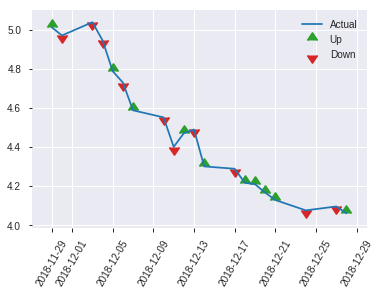


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20471501918844534
RMSE: 0.45245443879847763
LogLoss: 0.5952112166246836
Mean Per-Class Error: 0.2878836317135549
AUC: 0.7595268542199488
pr_auc: 0.7233596357681449
Gini: 0.5190537084398976
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45810295716887445: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   71   0.5221   (71.0/136.0)
1      16   99   0.1391   (16.0/115.0)
Total  81   170  0.3466   (87.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458103     0.694737  169
max f2                       0.217971     0.829662  220
max f0point5                 0.601519     0.699029  99
max accuracy                 0.601519     0.717131  99
max precision                0.992735     1         0
max recall                   0.118512     1         240
max specificity              0.992735     1         0
max absolute_mcc             0.585655     0.427943  105
max min_per_class_accuracy   0.56008      0.704348  120
max mean_per_class_accuracy  0.585655     0.712116  105

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 53.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.9893             2.18261   2.18261            1                0.991774  1                           0.991774            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.982187           1.45507   1.81884            0.666667         0.985344  0.833333                    0.988559            0.0173913       0.0434783                  45.5072   81.8841
    3        0.0318725                   0.933125           2.18261   1.90978            1                0.954856  0.875                       0.980133            0.0173913       0.0608696                  118.261   90.9783
    4        0.0438247                   0.913906           2.18261   1.98419            1                0.92146   0.909091                    0.964131            0.026087        0.0869565                  118.261   98.419
    5        0.0517928                   0.901586           2.18261   2.01472            1                0.907639  0.923077                    0.95544             0.0173913       0.104348                   118.261   101.472
    6        0.103586                    0.858504           1.67893   1.84682            0.769231         0.881357  0.846154                    0.918398            0.0869565       0.191304                   67.893    84.6823
    7        0.151394                    0.776369           1.81884   1.83799            0.833333         0.80957   0.842105                    0.884031            0.0869565       0.278261                   81.8841   83.7986
    8        0.203187                    0.736286           1.51104   1.75465            0.692308         0.753521  0.803922                    0.850764            0.0782609       0.356522                   51.1037   75.4646
    9        0.302789                    0.659148           1.30957   1.60824            0.6              0.693646  0.736842                    0.799081            0.130435        0.486957                   30.9565   60.8238
    10       0.40239                     0.599469           1.39687   1.55592            0.64             0.624301  0.712871                    0.755818            0.13913         0.626087                   39.687    55.5919
    11       0.501992                    0.551194           0.785739  1.40311            0.36             0.570102  0.642857                    0.71897             0.0782609       0.704348                   -21.4261  40.3106
    12       0.601594                    0.502536           0.698435  1.28644            0.32             0.527368  0.589404                    0.687248            0.0695652       0.773913                   -30.1565  28.6438
    13       0.701195                    0.436933           0.960348  1.24012            0.44             0.469685  0.568182                    0.656344            0.0956522       0.869565                   -3.96522  24.0119
    14       0.800797                    0.317108           0.61113   1.16189            0.28             0.372578  0.532338                    0.62105             0.0608696       0.930435                   -38.887   16.1886
    15       0.900398                    0.193381           0.523826  1.0913             0.24             0.25749   0.5                         0.580833            0.0521739       0.982609                   -47.6174  9.13043
    16       1                           0.0314823          0.174609  1                  0.08             0.120237  0.458167                    0.534957          

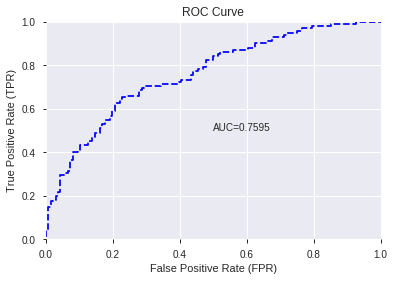

This function is available for GLM models only


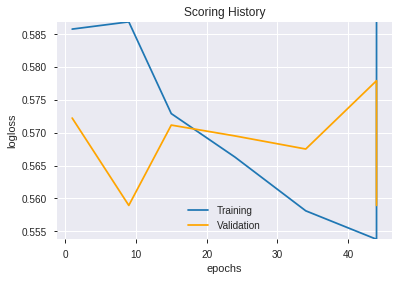

--2019-09-03 03:01:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_025229_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_025229_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'CDLLONGLINE',
 'DIV',
 'STOCHF_fastk',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'CDLMARUBOZU',
 'ULTOSC',
 'ADOSC',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'STOCHF_fastd',
 'RSI_14',
 'WILLR_30',
 'STOCH_slowk',
 'CMO_14',
 'CCI_12',
 'WILLR_12',
 'CCI_8',
 'WILLR_14',
 'RSI_8',
 'WILLR_8',
 'CDLBELTHOLD',
 'RSI_12',
 'CMO_8',
 'CMO_12',
 'WILLR_24',
 'CCI_14',
 'WILLR_20']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190903_030115_model_1  0.749552  0.598712              0.358312  0.454918  0.20695

variable  relative_importance  scaled_importance  percentage
0               CMO_12             1.178148           1.000000    0.107040
1         STOCHF_fastk             0.838045           0.711325    0.076140
2               CMO_14             0.774170           0.657107    0.070337
3       STOCHRSI_fastd             0.660673           0.560772    0.060025
4             WILLR_14             0.608735           0.516688    0.055306
5                  SUB             0.580891           0.493054    0.052776
6                  BOP             0.556080           0.471995    0.050522
7         STOCHF_fastd             0.513125           0.435535    0.046620
8          STOCH_slowk             0.512798           0.435257    0.046590
9                CMO_8             0.504179           0.427942    0.045807
10            WILLR_12             0.468824           0.397933    0.042595
11              RSI_12             0.462257           0.392359    0.041998
12      STOCHRSI_fastk             0.375089           0.318372    0.034078
13                 DIV             0.363131           0.308222    0.032992
14              ULTOSC             0.308199           0.261596    0.028001
15              RSI_14             0.290379           0.246471    0.026382
16            WILLR_20             0.264713           0.224686    0.024050
17         CDLLONGLINE             0.264265           0.224305    0.024010
18               RSI_8             0.258070           0.219047    0.023447
19              CCI_14             0.217977           0.185017    0.019804
20             WILLR_8             0.189287           0.160665    0.017198
21   CDLDARKCLOUDCOVER             0.149641           0.127013    0.013595
22            WILLR_24             0.119498           0.101429    0.010857
23               CCI_8             0.102077           0.086642    0.009274
24               ADOSC             0.101331           0.086009    0.009206
25  CDLCLOSINGMARUBOZU             0.096614           0.082005    0.008778
26              TRANGE             0.079359           0.067359    0.007210
27              CCI_12             0.077398           0.065694    0.007032
28         CDLBELTHOLD             0.031086           0.026386    0.002824
29        CDLENGULFING             0.027688           0.023501    0.002516
30            WILLR_30             0.019978           0.016957    0.001815
31         CDLMARUBOZU             0.012939           0.010982    0.001176

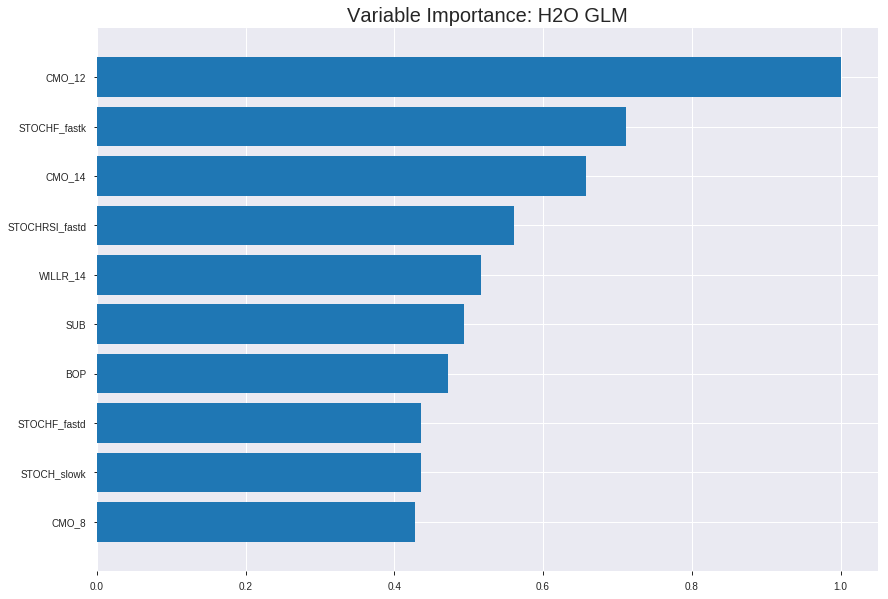

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_030115_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19551871338741192
RMSE: 0.4421749805081829
LogLoss: 0.5735030220997502
Null degrees of freedom: 1753
Residual degrees of freedom: 1721
Null deviance: 2429.507457396468
Residual deviance: 2011.8486015259239
AIC: 2077.848601525924
AUC: 0.7683926277190786
pr_auc: 0.7599358518230712
Gini: 0.5367852554381571
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37168200893306524: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      391  456   0.5384   (456.0/847.0)
1      102  805   0.1125   (102.0/907.0)
Total  493  1261  0.3181   (558.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371682     0.74262   266
max f2                       0.129988     0.855301  364
max f0point5                 0.608151     0.719562  148
max accuracy                 0.467695     0.702395  222
max precision                0.945681     1         0
max recall                   0.0879203    1         380
max specificity              0.945681     1         0
max absolute_mcc             0.451263     0.406686  229
max min_per_class_accuracy   0.537991     0.693034  185
max mean_per_class_accuracy  0.528307     0.699133  190

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.919876           1.61154   1.61154            0.833333         0.933087  0.833333                    0.933087            0.016538        0.016538                   61.154    61.154
    2        0.0205245                   0.903226           1.82641   1.71898            0.944444         0.911673  0.888889                    0.92238             0.0187431       0.0352811                  82.6412   71.8976
    3        0.0302166                   0.892846           1.59258   1.67843            0.823529         0.898776  0.867925                    0.914809            0.0154355       0.0507166                  59.2581   67.8434
    4        0.0404789                   0.882257           1.82641   1.71595            0.944444         0.887511  0.887324                    0.907889            0.0187431       0.0694598                  82.6412   71.595
    5        0.050171                    0.871218           1.59258   1.69212            0.823529         0.876816  0.875                       0.901886            0.0154355       0.0848953                  59.2581   69.2117
    6        0.100342                    0.821564           1.67014   1.68113            0.863636         0.844363  0.869318                    0.873125            0.0837927       0.168688                   67.0141   68.1129
    7        0.149943                    0.768051           1.55597   1.63973            0.804598         0.793409  0.847909                    0.846755            0.0771775       0.245865                   55.597    63.9727
    8        0.200114                    0.735874           1.51631   1.60879            0.784091         0.751008  0.831909                    0.82275             0.076075        0.32194                    51.6313   60.8785
    9        0.299886                    0.668947           1.37027   1.52943            0.708571         0.70308   0.790875                    0.782936            0.136714        0.458655                   37.0269   52.9431
    10       0.400228                    0.603512           1.28557   1.46829            0.664773         0.636284  0.759259                    0.746168            0.128997        0.587652                   28.5569   46.8292
    11       0.5                         0.541487           1.0056    1.37596            0.52             0.573826  0.711517                    0.711778            0.100331        0.687982                   0.560088  37.5965
    12       0.599772                    0.468016           1.0277    1.31803            0.531429         0.504428  0.681559                    0.677286            0.102536        0.790518                   2.7702    31.8031
    13       0.700114                    0.387089           0.780132  1.24094            0.403409         0.42886   0.641694                    0.641681            0.07828         0.868798                   -21.9868  24.0938
    14       0.799886                    0.290284           0.629882  1.16472            0.325714         0.34011   0.602281                    0.604065            0.0628445       0.931643                   -37.0118  16.4719
    15       0.899658                    0.172891           0.453073  1.0858             0.234286         0.229776  0.56147                     0.562556            0.045204        0.976847                   -54.6927  8.5798
    16       1                           0.00623669         0.230743  1                  0.119318         0.10958   0.517104                    0.517104            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18766663082902496
RMSE: 0.43320506787089297
LogLoss: 0.5537169858046855
Null degrees of freedom: 501
Residual degrees of freedom: 469
Null deviance: 694.5911617977604
Residual deviance: 555.9318537479043
AIC: 621.9318537479043
AUC: 0.7914576864899291
pr_auc: 0.8004214574326928
Gini: 0.5829153729798582
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4036722809716582: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      105  132  0.557    (132.0/237.0)
1      25   240  0.0943   (25.0/265.0)
Total  130  372  0.3127   (157.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403672     0.753532  288
max f2                       0.238701     0.865513  347
max f0point5                 0.648371     0.757129  147
max accuracy                 0.59994      0.723108  179
max precision                0.954596     1         0
max recall                   0.108122     1         383
max specificity              0.954596     1         0
max absolute_mcc             0.635974     0.452959  154
max min_per_class_accuracy   0.57131      0.709434  197
max mean_per_class_accuracy  0.59994      0.725922  179

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 54.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.919275           1.89434   1.89434            1                0.933249  1                           0.933249            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.902685           1.89434   1.89434            1                0.909604  1                           0.922501            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.886802           1.89434   1.89434            1                0.895964  1                           0.914208            0.0188679       0.0603774                  89.434    89.434
    4        0.0418327                   0.874047           1.51547   1.80413            0.8              0.877926  0.952381                    0.90557             0.0150943       0.0754717                  51.5472   80.4133
    5        0.0517928                   0.858303           1.51547   1.74862            0.8              0.864909  0.923077                    0.897751            0.0150943       0.090566                   51.5472   74.8621
    6        0.101594                    0.815003           1.66702   1.70862            0.88             0.834941  0.901961                    0.866961            0.0830189       0.173585                   66.7019   70.862
    7        0.151394                    0.772265           1.51547   1.64508            0.8              0.78931   0.868421                    0.841418            0.0754717       0.249057                   51.5472   64.5084
    8        0.201195                    0.73554            1.36392   1.57549            0.72             0.756441  0.831683                    0.820384            0.0679245       0.316981                   36.3925   57.549
    9        0.300797                    0.680318           1.62913   1.59325            0.86             0.707316  0.84106                     0.782944            0.162264        0.479245                   62.9132   59.3253
    10       0.400398                    0.632785           1.28815   1.51736            0.68             0.655244  0.800995                    0.751178            0.128302        0.607547                   28.8151   51.7357
    11       0.5                         0.575085           0.94717   1.40377            0.5              0.605371  0.741036                    0.722133            0.0943396       0.701887                   -5.28302  40.3774
    12       0.599602                    0.487132           0.909283  1.32163            0.48             0.531586  0.697674                    0.690481            0.090566        0.792453                   -9.0717   32.1632
    13       0.699203                    0.43222            0.681962  1.23051            0.36             0.458307  0.649573                    0.657407            0.0679245       0.860377                   -31.8038  23.0511
    14       0.798805                    0.358735           0.833509  1.18101            0.44             0.395839  0.623441                    0.624793            0.0830189       0.943396                   -16.6491  18.101
    15       0.898406                    0.207958           0.416755  1.09628            0.22             0.290754  0.578714                    0.58776             0.0415094       0.984906                   -58.3245  9.62808
    16       1                           0.0257179          0.148576  1                  0.0784314        0.127324  0.527888                    0.540982            0.0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 03:01:16  0.000 sec   2            .21E2     33            1.365503291076754   1.362079035731615
     2019-09-03 03:01:16  0.010 sec   4            .13E2     33            1.356339343903301   1.3519125673455825
     2019-09-03 03:01:16  0.018 sec   6            .8E1      33            1.344248824762206   1.3384108805086796
     2019-09-03 03:01:16  0.027 sec   8            .49E1     33            1.3291043701107863  1.3213527241635938
     2019-09-03 03:01:16  0.035 sec   10           .31E1     33            1.3108436461868476  1.300588092863433
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 03:01:16  0.202 sec   46           .22E-3    33            1.147299704340589   1.1075529774242518
     2019-09-03 03:01:16  0.207 sec   47           .14E-3    33            1.1472159839503504  1.1075457497942536
     2019-09-03 03:01:16  0.212 sec   48           .86E-4    33            1.1471426698855147  1.1075263702831408
     2019-09-03 03:01:16  0.219 sec   49           .54E-4    33            1.1470731019162081  1.1074856413888607
     2019-09-03 03:01:16  0.224 sec   50           .33E-4    33            1.1470060441995005  1.107433971609371


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.6903225806451613)

('auc', 0.7495524296675192)

('logloss', 0.598711927343941)

('mean_per_class_error', 0.3096227621483376)

('rmse', 0.454917898716903)

('mse', 0.20695029457300243)

glm prediction progress: |████████████████████████████████████████████████| 100%


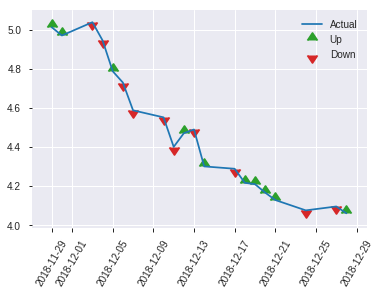


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20695029457300243
RMSE: 0.454917898716903
LogLoss: 0.598711927343941
Null degrees of freedom: 250
Residual degrees of freedom: 218
Null deviance: 349.69104234008756
Residual deviance: 300.55338752665836
AIC: 366.55338752665836
AUC: 0.7495524296675192
pr_auc: 0.7118500106971902
Gini: 0.49910485933503845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3383574439403634: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   88   0.6471   (88.0/136.0)
1      8    107  0.0696   (8.0/115.0)
Total  56   195  0.3825   (96.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.338357     0.690323  194
max f2                       0.259517     0.827124  210
max f0point5                 0.676299     0.689223  70
max accuracy                 0.676299     0.697211  70
max precision                0.936019     1         0
max recall                   0.0589497    1         249
max specificity              0.936019     1         0
max absolute_mcc             0.676299     0.398929  70
max min_per_class_accuracy   0.57387      0.652174  121
max mean_per_class_accuracy  0.617127     0.690377  100

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 52.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.906293           2.18261   2.18261            1                0.919561  1                           0.919561            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.894175           1.45507   1.81884            0.666667         0.900094  0.833333                    0.909827            0.0173913       0.0434783                  45.5072   81.8841
    3        0.0318725                   0.890811           2.18261   1.90978            1                0.893303  0.875                       0.905696            0.0173913       0.0608696                  118.261   90.9783
    4        0.0438247                   0.877602           2.18261   1.98419            1                0.881726  0.909091                    0.899159            0.026087        0.0869565                  118.261   98.419
    5        0.0517928                   0.862313           1.0913    1.84682            0.5              0.871584  0.846154                    0.894917            0.00869565      0.0956522                  9.13043   84.6823
    6        0.103586                    0.811686           1.84682   1.84682            0.846154         0.83151   0.846154                    0.863214            0.0956522       0.191304                   84.6823   84.6823
    7        0.151394                    0.761954           1.27319   1.66568            0.583333         0.781749  0.763158                    0.837488            0.0608696       0.252174                   27.3188   66.5675
    8        0.203187                    0.721437           2.01472   1.75465            0.923077         0.739782  0.803922                    0.812583            0.104348        0.356522                   101.472   75.4646
    9        0.302789                    0.666359           1.39687   1.63696            0.64             0.6872    0.75                        0.771338            0.13913         0.495652                   39.687    63.6957
    10       0.40239                     0.617127           1.13496   1.5127             0.52             0.63681   0.693069                    0.738039            0.113043        0.608696                   13.4957   51.2699
    11       0.501992                    0.567721           0.436522  1.29917            0.2              0.589084  0.595238                    0.708485            0.0434783       0.652174                   -56.3478  29.9172
    12       0.601594                    0.490359           1.30957   1.30089            0.6              0.52498   0.596026                    0.678103            0.130435        0.782609                   30.9565   30.0893
    13       0.701195                    0.393876           0.873043  1.24012            0.4              0.437313  0.568182                    0.6439              0.0869565       0.869565                   -12.6957  24.0119
    14       0.800797                    0.316841           0.698435  1.17274            0.32             0.35287   0.537313                    0.607702            0.0695652       0.93913                    -30.1565  17.2745
    15       0.900398                    0.190168           0.349217  1.08165            0.16             0.248266  0.495575                    0.567941            0.0347826       0.973913                   -65.0783  8.16468
    16       1                           0.052816           0.261913  1                  0.12             0.125575  0.458167                    0.523881          

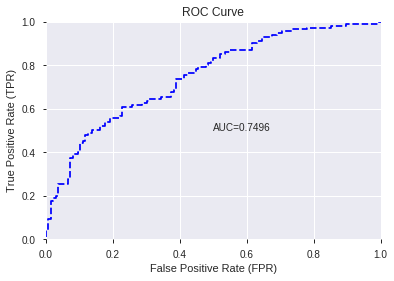

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


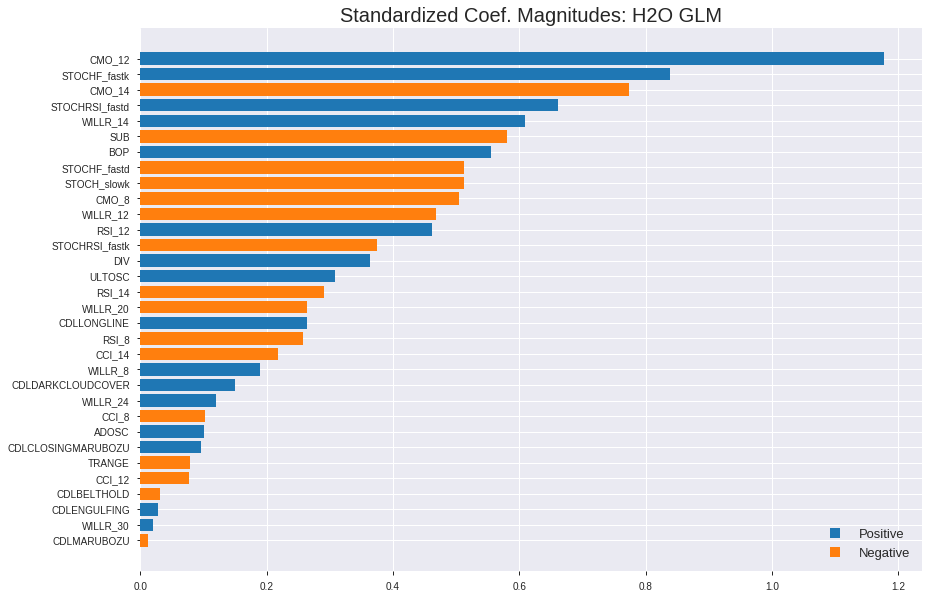

'log_likelihood'
--2019-09-03 03:01:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_030115_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_030115_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CMO_12',
 'STOCHF_fastk',
 'CMO_14',
 'STOCHRSI_fastd',
 'WILLR_14',
 'SUB',
 'BOP',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CMO_8',
 'WILLR_12',
 'RSI_12',
 'STOCHRSI_fastk',
 'DIV',
 'ULTOSC',
 'RSI_14',
 'WILLR_20',
 'CDLLONGLINE',
 'RSI_8',
 'CCI_14',
 'WILLR_8',
 'CDLDARKCLOUDCOVER',
 'WILLR_24',
 'CCI_8',
 'ADOSC',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'CCI_12',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'WILLR_30',
 'CDLMARUBOZU']

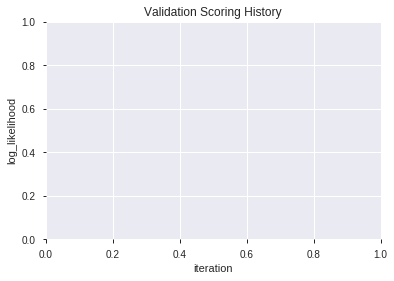

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_030127_model_4  0.740090  0.607316              0.361317  0.460002  0.211602
1  XGBoost_grid_1_AutoML_20190903_030127_model_6  0.736253  0.606814              0.337916  0.459542  0.211179
2  XGBoost_grid_1_AutoML_20190903_030127_model_1  0.731138  0.618601              0.292199  0.463797  0.215108
3               XGBoost_3_AutoML_20190903_030127  0.730882  0.616084              0.331266  0.463794  0.215105
4  XGBoost_grid_1_AutoML_20190903_030127_model_3  0.726087  0.616945              0.358312  0.464117  0.215404
5  XGBoost_grid_1_AutoML_20190903_030127_model_2  0.724808  0.623710              0.353293  0.467083  0.218167
6               XGBoost_2_AutoML_20190903_030127  0.722251  0.623551              0.362660  0.467237  0.218311
7  XGBoost_grid_1_AutoML_20190903_030127_model_7  0.721355  0.626087              0.319597  0.468222  0.219232
8               XGBoost_1_AutoML_20190903_030127  0.721036  0.628567              0.362340  0.470037  0.220935
9  XGBoost_grid_1_AutoML_20190903_030127_model_5  0.717519  0.647715              0.327270  0.475951  0.226529

variable  relative_importance  scaled_importance  percentage
0              BOP          2125.676025           1.000000    0.421065
1     STOCHF_fastk           510.782227           0.240292    0.101178
2              SUB           419.014923           0.197121    0.083001
3      STOCH_slowk           199.876190           0.094029    0.039592
4           CCI_12           195.689972           0.092060    0.038763
5           ULTOSC           166.094162           0.078137    0.032901
6         WILLR_14           145.695877           0.068541    0.028860
7            CCI_8           140.587357           0.066138    0.027848
8              DIV           132.320770           0.062249    0.026211
9         WILLR_20           109.647987           0.051583    0.021720
10        WILLR_30            97.550957           0.045892    0.019323
11         WILLR_8            97.390327           0.045816    0.019292
12           ADOSC            94.536171           0.044473    0.018726
13  STOCHRSI_fastd            87.793213           0.041301    0.017391
14          TRANGE            87.628738           0.041224    0.017358
15          CCI_14            75.831093           0.035674    0.015021
16           CMO_8            73.065033           0.034373    0.014473
17  STOCHRSI_fastk            61.098576           0.028743    0.012103
18        WILLR_12            56.631500           0.026642    0.011218
19        WILLR_24            49.257069           0.023172    0.009757
20          CMO_12            48.775841           0.022946    0.009662
21     CDLLONGLINE            48.375935           0.022758    0.009583
22          CMO_14            25.015051           0.011768    0.004955

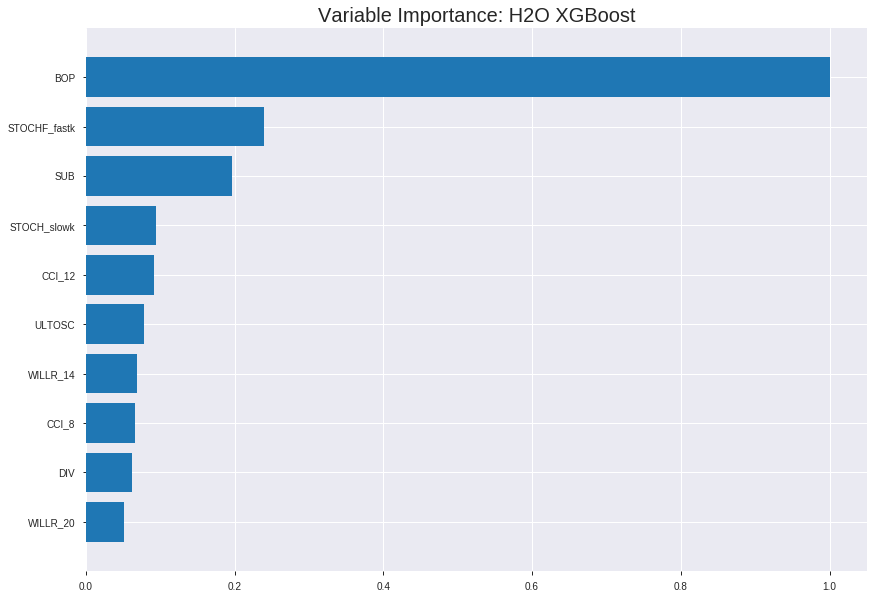

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_030127_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1773065027382252
RMSE: 0.4210777870396694
LogLoss: 0.5329322584396421
Mean Per-Class Error: 0.25035894245075363
AUC: 0.8181336554595049
pr_auc: 0.818687848711415
Gini: 0.6362673109190098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43017744024594623: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      487  360   0.425    (360.0/847.0)
1      124  783   0.1367   (124.0/907.0)
Total  611  1143  0.2759   (484.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430177     0.763902  243
max f2                       0.214193     0.864305  346
max f0point5                 0.570293     0.76179   169
max accuracy                 0.522399     0.750285  194
max precision                0.89753      1         0
max recall                   0.129485     1         386
max specificity              0.89753      1         0
max absolute_mcc             0.522399     0.499739  194
max min_per_class_accuracy   0.535102     0.742007  187
max mean_per_class_accuracy  0.522399     0.749641  194

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.875935           1.82641   1.82641            0.944444         0.884625  0.944444                    0.884625            0.0187431       0.0187431                  82.6412   82.6412
    2        0.0205245                   0.866687           1.93385   1.88013            1                0.870792  0.972222                    0.877709            0.0198456       0.0385888                  93.3848   88.013
    3        0.0302166                   0.860033           1.82009   1.86087            0.941176         0.862737  0.962264                    0.872906            0.0176406       0.0562293                  82.0092   86.0872
    4        0.0404789                   0.852043           1.71898   1.8249             0.888889         0.855419  0.943662                    0.868473            0.0176406       0.0738699                  71.8976   82.4899
    5        0.050171                    0.843971           1.82009   1.82397            0.941176         0.848033  0.943182                    0.864524            0.0176406       0.0915105                  82.0092   82.397
    6        0.100342                    0.797292           1.78002   1.80199            0.920455         0.820485  0.931818                    0.842505            0.0893054       0.180816                   78.0019   80.1995
    7        0.149943                    0.760354           1.62265   1.74267            0.83908          0.777199  0.901141                    0.820902            0.0804851       0.261301                   62.2654   74.2669
    8        0.200114                    0.730435           1.51631   1.68592            0.784091         0.745311  0.871795                    0.80195             0.076075        0.337376                   51.6313   68.5919
    9        0.299886                    0.671798           1.55813   1.6434             0.805714         0.700465  0.84981                     0.768186            0.155458        0.492834                   55.8129   64.3403
    10       0.400228                    0.610013           1.26359   1.54818            0.653409         0.642083  0.80057                     0.73657             0.126792        0.619625                   26.3594   54.818
    11       0.5                         0.539105           1.12716   1.46417            0.582857         0.575091  0.757127                    0.704348            0.112459        0.732084                   12.7157   46.4168
    12       0.599772                    0.467797           0.861944  1.36399            0.445714         0.506078  0.705323                    0.671366            0.0859978       0.818082                   -13.8056  36.3988
    13       0.700114                    0.384839           0.747168  1.27558            0.386364         0.428776  0.659609                    0.636597            0.0749724       0.893054                   -25.2832  27.5584
    14       0.799886                    0.285981           0.629882  1.19504            0.325714         0.337988  0.617962                    0.599351            0.0628445       0.955899                   -37.0118  19.5044
    15       0.899658                    0.193353           0.298365  1.0956             0.154286         0.240539  0.56654                     0.559559            0.0297685       0.985667                   -70.1635  9.5602
    16       1                           0.0936452          0.142841  1                  0.0738636        0.147178  0.517104                    0.51818             0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1922310847435089
RMSE: 0.43844165489094317
LogLoss: 0.5655220943053986
Mean Per-Class Error: 0.29251651938539935
AUC: 0.7791895549717379
pr_auc: 0.7869659364415624
Gini: 0.5583791099434758
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4560769200325012: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      124  113  0.4768   (113.0/237.0)
1      37   228  0.1396   (37.0/265.0)
Total  161  341  0.2988   (150.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456077     0.752475  262
max f2                       0.215556     0.871137  364
max f0point5                 0.633829     0.729266  149
max accuracy                 0.560792     0.707171  194
max precision                0.890353     1         0
max recall                   0.215556     1         364
max specificity              0.890353     1         0
max absolute_mcc             0.560792     0.414351  194
max min_per_class_accuracy   0.559739     0.70566   195
max mean_per_class_accuracy  0.560792     0.707483  194

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 54.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.870715           1.57862   1.57862            0.833333         0.878657  0.833333                    0.878657            0.0188679       0.0188679                  57.8616   57.8616
    2        0.0219124                   0.859484           1.89434   1.72213            1                0.865082  0.909091                    0.872487            0.0188679       0.0377358                  89.434    72.2127
    3        0.0318725                   0.854338           1.89434   1.77594            1                0.855389  0.9375                      0.867144            0.0188679       0.0566038                  89.434    77.5943
    4        0.0418327                   0.845745           1.89434   1.80413            1                0.848365  0.952381                    0.862673            0.0188679       0.0754717                  89.434    80.4133
    5        0.0517928                   0.83224            1.51547   1.74862            0.8              0.836422  0.923077                    0.857624            0.0150943       0.090566                   51.5472   74.8621
    6        0.101594                    0.780855           1.74279   1.74576            0.92             0.803106  0.921569                    0.8309              0.0867925       0.177358                   74.2792   74.5764
    7        0.151394                    0.748297           1.51547   1.67001            0.8              0.767624  0.881579                    0.810085            0.0754717       0.25283                    51.5472   67.001
    8        0.201195                    0.720474           1.66702   1.66927            0.88             0.733737  0.881188                    0.791187            0.0830189       0.335849                   66.7019   66.927
    9        0.300797                    0.668014           1.21238   1.51798            0.64             0.694166  0.801325                    0.759061            0.120755        0.456604                   21.2377   51.7981
    10       0.400398                    0.6276             1.32604   1.47023            0.7              0.64938   0.776119                    0.731777            0.132075        0.588679                   32.6038   47.0234
    11       0.5                         0.562632           1.02294   1.38113            0.54             0.601085  0.729084                    0.705743            0.101887        0.690566                   2.29434   38.1132
    12       0.599602                    0.51641            0.871396  1.29646            0.46             0.541008  0.684385                    0.678378            0.0867925       0.777358                   -12.8604  29.6458
    13       0.699203                    0.444938           0.909283  1.24131            0.48             0.479046  0.655271                    0.649983            0.090566        0.867925                   -9.0717   24.1305
    14       0.798805                    0.344201           0.606189  1.16211            0.32             0.398     0.613466                    0.618564            0.0603774       0.928302                   -39.3811  16.2114
    15       0.898406                    0.248557           0.530415  1.09208            0.28             0.306954  0.576497                    0.584017            0.0528302       0.981132                   -46.9585  9.20805
    16       1                           0.0888737          0.18572   1                  0.0980392        0.172685  0.527888                    0.542229           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:01:37  4.971 sec   0                  0.5              0.693147            0.5             0                  1                0.482896                         0.5                0.693147              0.5               0                    1                  0.472112
    2019-09-03 03:01:37  5.063 sec   5                  0.478512         0.650843            0.780929        0.712421           1.82174          0.330673                         0.481034           0.655733              0.767996          0.716684             1.75903            0.320717
    2019-09-03 03:01:37  5.123 sec   10                 0.463884         0.622236            0.785975        0.718512           1.82174          0.325542                         0.468408           0.630903              0.773816          0.732997             1.75903            0.322709
    2019-09-03 03:01:37  5.176 sec   15                 0.454063         0.6027              0.788829        0.778822           1.82438          0.324401                         0.459814           0.613683              0.777008          0.782396             1.74862            0.336653
    2019-09-03 03:01:37  5.233 sec   20                 0.446633         0.587506            0.791005        0.792789           1.84977          0.314709                         0.452674           0.599095              0.781562          0.787439             1.89434            0.278884
    2019-09-03 03:01:37  5.290 sec   25                 0.441914         0.577502            0.793543        0.794516           1.93385          0.312999                         0.449004           0.591011              0.780033          0.787059             1.89434            0.308765
    2019-09-03 03:01:38  5.361 sec   30                 0.438176         0.569621            0.796427        0.795153           1.93385          0.310718                         0.446606           0.585687              0.780018          0.784787             1.62372            0.298805
    2019-09-03 03:01:38  5.437 sec   35                 0.434926         0.562597            0.799542        0.797629           1.93385          0.312999                         0.444446           0.580701              0.779572          0.784763             1.62372            0.308765
    2019-09-03 03:01:38  5.508 sec   40                 0.432323         0.556966            0.802424        0.802067           1.93385          0.306157                         0.442724           0.576691              0.780471          0.786653             1.57862            0.302789
    2019-09-03 03:01:38  5.580 sec   45                 0.43025          0.552346            0.804532        0.804537           1.93385          0.305017                         0.441944           0.574556              0.77872           0.784066             1.57862            0.304781
    2019-09-03 03:01:38  5.654 sec   50                 0.428197         0.547983            0.807311        0.808371           1.93385          0.306727                         0.440949           0.572105              0.778457          0.780519             1.89434            0.314741
    2019-09-03 03:01:38  5.723 sec   55                 0.426047         0.543556            0.81114         0.812377           1.93385          0.279932                         0.440401           0.570661              0.778752          0

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  --------------------
BOP           2125.676025390625      1.0                   0.42106477248151586
STOCHF_fastk  510.7822265625         0.24029166272816013   0.10117835429583788
SUB           419.0149230957031      0.19712078326644475   0.08300061775746376
STOCH_slowk   199.87619018554688     0.09402947005944455   0.03959249741713753
CCI_12        195.68997192382812     0.09206011150634638   0.038763269906042716
---           ---                    ---                   ---
WILLR_12      56.631500244140625     0.0266416422670683    0.01121785703971705
WILLR_24      49.2570686340332       0.023172425170002786  0.009757091932052174
CMO_12        48.775840759277344     0.02294603701441947   0.009661767854828975
CDLLONGLINE   48.37593460083008      0.02275790573116158   0.009582552398847336
CMO_14        25.015050888061523     0.011768044889843753  0.004955109144094325


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.6900958466453674)

('auc', 0.7400895140664963)

('logloss', 0.6073156085494495)

('mean_per_class_error', 0.3226662404092071)

('rmse', 0.46000200308518013)

('mse', 0.2116018428423781)

xgboost prediction progress: |████████████████████████████████████████████| 100%


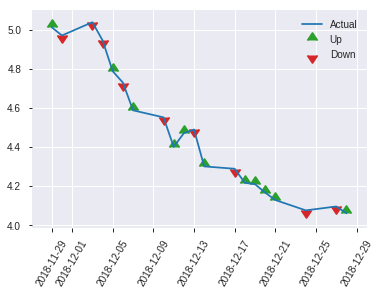


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2116018428423781
RMSE: 0.46000200308518013
LogLoss: 0.6073156085494495
Mean Per-Class Error: 0.3226662404092071
AUC: 0.7400895140664963
pr_auc: 0.711449358033354
Gini: 0.4801790281329925
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33671849966049194: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      46   90   0.6618   (90.0/136.0)
1      7    108  0.0609   (7.0/115.0)
Total  53   198  0.3865   (97.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336718     0.690096  197
max f2                       0.199587     0.829726  232
max f0point5                 0.630179     0.66075   97
max accuracy                 0.630179     0.685259  97
max precision                0.889136     1         0
max recall                   0.199587     1         232
max specificity              0.889136     1         0
max absolute_mcc             0.630179     0.362227  97
max min_per_class_accuracy   0.595091     0.654412  122
max mean_per_class_accuracy  0.630179     0.677334  97

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 53.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.860915           2.18261   2.18261            1                0.87771   1                           0.87771             0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.848284           2.18261   2.18261            1                0.850721  1                           0.864216            0.026087        0.0521739                  118.261   118.261
    3        0.0318725                   0.833861           2.18261   2.18261            1                0.83961   1                           0.858064            0.0173913       0.0695652                  118.261   118.261
    4        0.0438247                   0.830318           2.18261   2.18261            1                0.831183  1                           0.850733            0.026087        0.0956522                  118.261   118.261
    5        0.0517928                   0.821087           1.0913    2.01472            0.5              0.825633  0.923077                    0.846872            0.00869565      0.104348                   9.13043   101.472
    6        0.103586                    0.788912           2.01472   2.01472            0.923077         0.812558  0.923077                    0.829715            0.104348        0.208696                   101.472   101.472
    7        0.151394                    0.752717           1.45507   1.83799            0.666667         0.7688    0.842105                    0.810478            0.0695652       0.278261                   45.5072   83.7986
    8        0.203187                    0.729492           1.00736   1.62626            0.461538         0.738388  0.745098                    0.792102            0.0521739       0.330435                   0.735786  62.6257
    9        0.302789                    0.675215           1.13496   1.46465            0.52             0.695902  0.671053                    0.760458            0.113043        0.443478                   13.4957   46.4645
    10       0.40239                     0.627437           1.39687   1.44787            0.64             0.652582  0.663366                    0.733756            0.13913         0.582609                   39.687    44.7869
    11       0.501992                    0.582517           0.960348  1.35114            0.44             0.606728  0.619048                    0.708552            0.0956522       0.678261                   -3.96522  35.1139
    12       0.601594                    0.496801           0.960348  1.28644            0.44             0.539406  0.589404                    0.680548            0.0956522       0.773913                   -3.96522  28.6438
    13       0.701195                    0.410479           0.873043  1.22772            0.4              0.450135  0.5625                      0.647818            0.0869565       0.86087                    -12.6957  22.7717
    14       0.800797                    0.330403           0.785739  1.17274            0.36             0.371602  0.537313                    0.613463            0.0782609       0.93913                    -21.4261  17.2745
    15       0.900398                    0.225527           0.436522  1.0913             0.2              0.289673  0.5                         0.577646            0.0434783       0.982609                   -56.3478  9.13043
    16       1                           0.0864118          0.174609  1                  0.08             0.170191  0.458167                    0.537062         

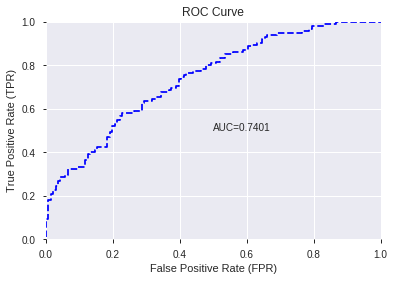

This function is available for GLM models only


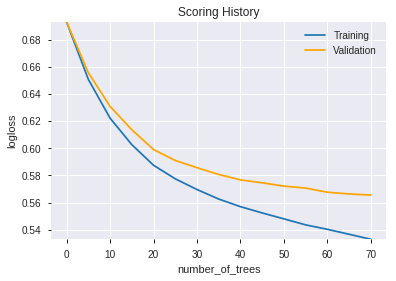

--2019-09-03 03:01:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_030127_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_030127_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'STOCH_slowk',
 'CCI_12',
 'ULTOSC',
 'WILLR_14',
 'CCI_8',
 'DIV',
 'WILLR_20',
 'WILLR_30',
 'WILLR_8',
 'ADOSC',
 'STOCHRSI_fastd',
 'TRANGE',
 'CCI_14',
 'CMO_8',
 'STOCHRSI_fastk',
 'WILLR_12',
 'WILLR_24',
 'CMO_12',
 'CDLLONGLINE',
 'CMO_14']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

53

['BBANDS_upperband_14_5_3',
 'DEMA_20',
 'SMA_20',
 'MA_20_5',
 'BBANDS_middleband_20_6_5',
 'BOP',
 'ADX_8',
 'CMO_8',
 'DX_8',
 'MACDFIX_hist_8',
 'MFI_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROC_8',
 'ROCP_8',
 'WILLR_8',
 'CCI_12',
 'DX_12',
 'PLUS_DM_12',
 'ROCP_12',
 'ROCR_12',
 'WILLR_12',
 'aroondown_14',
 'AROONOSC_14',
 'CCI_14',
 'MOM_14',
 'ROC_14',
 'RSI_14',
 'WILLR_14',
 'aroonup_20',
 'CCI_20',
 'MOM_20',
 'ROCR100_20',
 'WILLR_20',
 'MACDFIX_hist_24',
 'MINUS_DM_24',
 'MOM_24',
 'ROCP_24',
 'aroonup_30',
 'CMO_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ADOSC',
 'ATR_12',
 'ATR_24',
 'TRANGE',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'BETA_8',
 'CORREL_8',
 'LINEARREG_SLOPE_8']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_030311_model_8  0.763107  0.583781              0.329923  0.448486  0.201139
1  DeepLearning_grid_1_AutoML_20190903_030311_model_2  0.759719  0.587283              0.273497  0.447410  0.200176
2  DeepLearning_grid_1_AutoML_20190903_030311_model_9  0.759079  0.584751              0.312212  0.446688  0.199530
3  DeepLearning_grid_1_AutoML_20190903_030311_model_6  0.753708  0.591594              0.355978  0.451351  0.203718
4  DeepLearning_grid_1_AutoML_20190903_030311_model_3  0.746867  0.606766              0.345301  0.456296  0.208206
5  DeepLearning_grid_1_AutoML_20190903_030311_model_7  0.741592  0.642582              0.362308  0.471921  0.222709
6  DeepLearning_grid_1_AutoML_20190903_030311_model_5  0.733568  0.613839              0.405083  0.462597  0.213996
7  DeepLearning_grid_1_AutoML_20190903_030311_model_4  0.712020  0.693065              0.364003  0.484907  0.235134
8               DeepLearning_1_AutoML_20190903_030311  0.707737  0.651722              0.364003  0.473074  0.223799
9  DeepLearning_grid_1_AutoML_20190903_030311_model_1  0.695269  0.715769              0.382385  0.490993  0.241074

variable  relative_importance  scaled_importance  percentage
0                     TRANGE             1.000000           1.000000    0.041873
1                        BOP             0.963134           0.963134    0.040329
2                CDLLONGLINE             0.800985           0.800985    0.033540
3                 aroonup_30             0.613873           0.613873    0.025705
4               STOCHF_fastk             0.562904           0.562904    0.023570
5                 aroonup_20             0.550922           0.550922    0.023069
6                      ADX_8             0.529059           0.529059    0.022153
7                       DX_8             0.516358           0.516358    0.021621
8                     BETA_8             0.502589           0.502589    0.021045
9             STOCHRSI_fastk             0.492767           0.492767    0.020634
10                  CORREL_8             0.491231           0.491231    0.020569
11              aroondown_14             0.475267           0.475267    0.019901
12                     ADOSC             0.474073           0.474073    0.019851
13            CDLSPINNINGTOP             0.467807           0.467807    0.019588
14                    CCI_20             0.465977           0.465977    0.019512
15               STOCH_slowk             0.463908           0.463908    0.019425
16               MINUS_DM_24             0.458748           0.458748    0.019209
17                    CCI_12             0.446296           0.446296    0.018688
18                     DX_12             0.445970           0.445970    0.018674
19                    ROC_14             0.444519           0.444519    0.018613
20               AROONOSC_14             0.439289           0.439289    0.018394
21                 PLUS_DI_8             0.430634           0.430634    0.018032
22                    ATR_12             0.428760           0.428760    0.017953
23                    SMA_20             0.423502           0.423502    0.017733
24   BBANDS_upperband_14_5_3             0.421233           0.421233    0.017638
25                   WILLR_8             0.419537           0.419537    0.017567
26                    ATR_24             0.419053           0.419053    0.017547
27                    MOM_14             0.414604           0.414604    0.017361
28                   MA_20_5             0.411973           0.411973    0.017251
29  BBANDS_middleband_20_6_5             0.403329           0.403329    0.016889
30                    MOM_20             0.401433           0.401433    0.016809
31                    CCI_14             0.400191           0.400191    0.016757
32                    MOM_24             0.397657           0.397657    0.016651
33                     MOM_8             0.389461           0.389461    0.016308
34                   DEMA_20             0.385941           0.385941    0.016160
35         LINEARREG_SLOPE_8             0.384259           0.384259    0.016090
36                  WILLR_20             0.383101           0.383101    0.016042
37                ROCR100_20             0.380446           0.380446    0.015930
38                    CMO_30             0.378822           0.378822    0.015862
39                PLUS_DM_12             0.377225           0.377225    0.015796
40                     MFI_8             0.374427           0.374427    0.015678
41                   ROCP_24             0.373185           0.373185    0.015626
42                   ROCR_12             0.369659           0.369659    0.015479
43                  WILLR_30             0.367776           0.367776    0.015400
44                  WILLR_14             0.365791           0.365791    0.015317
45                  WILLR_12             0.360403           0.360403    0.015091
46                    ROCP_8             0.354158           0.354158    0.014830
47            MACDFIX_hist_8             0.353466           0.353466    0.014801
48           MACDFIX_hist_24             0.352995  

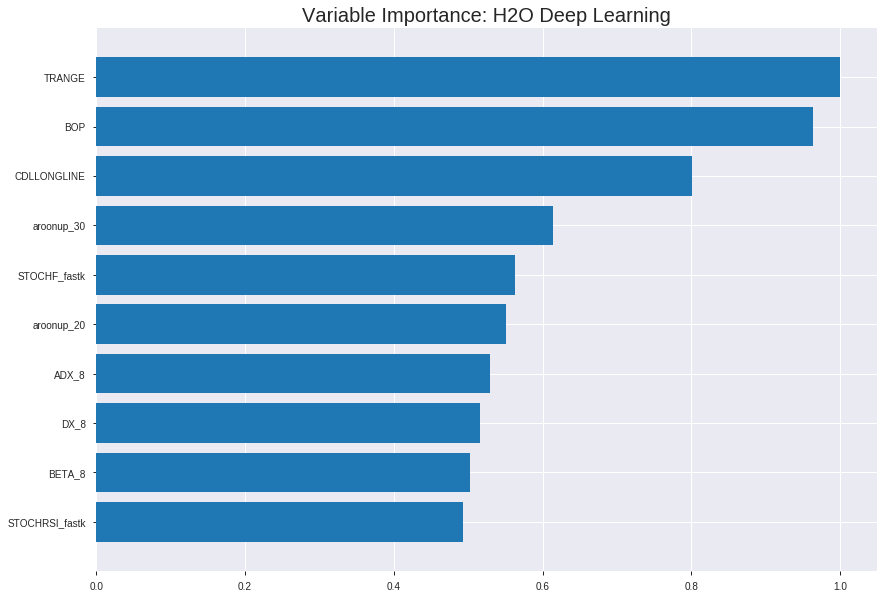

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_030311_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18719928834411978
RMSE: 0.4326653306472796
LogLoss: 0.5528743093156162
Mean Per-Class Error: 0.28336147164452274
AUC: 0.7961792642558404
pr_auc: 0.797494747499936
Gini: 0.5923585285116808
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4319815601107184: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      414  433   0.5112   (433.0/847.0)
1      97   810   0.1069   (97.0/907.0)
Total  511  1243  0.3022   (530.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431982     0.753488  236
max f2                       0.243865     0.863407  316
max f0point5                 0.537927     0.731995  173
max accuracy                 0.537927     0.715507  173
max precision                0.920652     1         0
max recall                   0.0311534    1         393
max specificity              0.920652     1         0
max absolute_mcc             0.537927     0.433595  173
max min_per_class_accuracy   0.529389     0.712238  180
max mean_per_class_accuracy  0.537927     0.716639  173

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 50.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.877079           1.93385   1.93385            1                0.897212  1                           0.897212            0.0198456       0.0198456                  93.3848   93.3848
    2        0.0205245                   0.858258           1.82641   1.88013            0.944444         0.867275  0.972222                    0.882244            0.0187431       0.0385888                  82.6412   88.013
    3        0.0302166                   0.846239           1.82009   1.86087            0.941176         0.852869  0.962264                    0.872821            0.0176406       0.0562293                  82.0092   86.0872
    4        0.0404789                   0.834492           1.71898   1.8249             0.888889         0.84028   0.943662                    0.864572            0.0176406       0.0738699                  71.8976   82.4899
    5        0.050171                    0.824603           1.70634   1.80199            0.882353         0.830319  0.931818                    0.857955            0.016538        0.0904079                  70.6336   80.1995
    6        0.100342                    0.767751           1.69212   1.74706            0.875            0.796062  0.903409                    0.827008            0.0848953       0.175303                   69.2117   74.7056
    7        0.149943                    0.716496           1.60043   1.69855            0.827586         0.743651  0.878327                    0.799434            0.0793826       0.254686                   60.0426   69.8551
    8        0.200114                    0.671518           1.64817   1.68592            0.852273         0.694389  0.871795                    0.773098            0.0826902       0.337376                   64.8166   68.5919
    9        0.299886                    0.606362           1.42552   1.59928            0.737143         0.633721  0.826996                    0.726727            0.142227        0.479603                   42.5522   59.9285
    10       0.400228                    0.563119           1.13174   1.48207            0.585227         0.582621  0.766382                    0.690598            0.113561        0.593164                   13.1741   48.2066
    11       0.5                         0.529602           1.12716   1.41125            0.582857         0.546439  0.729761                    0.661832            0.112459        0.705623                   12.7157   41.1246
    12       0.599772                    0.486823           0.939298  1.33274            0.485714         0.508391  0.689163                    0.636307            0.0937155       0.799338                   -6.07025  33.2737
    13       0.700114                    0.437939           0.857046  1.26456            0.443182         0.464634  0.653909                    0.611703            0.0859978       0.885336                   -14.2954  26.456
    14       0.799886                    0.343025           0.651983  1.18815            0.337143         0.392597  0.614398                    0.584373            0.0650496       0.950386                   -34.8017  18.8152
    15       0.899658                    0.181987           0.375719  1.09805            0.194286         0.272273  0.567807                    0.549761            0.0374862       0.987872                   -62.4281  9.8053
    16       1                           0.00402709         0.120865  1                  0.0625           0.102629  0.517104                    0.504895            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19202477900610881
RMSE: 0.43820632013482963
LogLoss: 0.5649752472645934
Mean Per-Class Error: 0.2667542393121567
AUC: 0.7920308892604092
pr_auc: 0.8000449258579762
Gini: 0.5840617785208184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45202370952825155: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  124  0.5232   (124.0/237.0)
1      28   237  0.1057   (28.0/265.0)
Total  141  361  0.3028   (152.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452024     0.757188  270
max f2                       0.35268      0.864071  306
max f0point5                 0.541152     0.755957  183
max accuracy                 0.541152     0.731076  183
max precision                0.918756     1         0
max recall                   0.128038     1         374
max specificity              0.918756     1         0
max absolute_mcc             0.541152     0.466391  183
max min_per_class_accuracy   0.531292     0.716981  196
max mean_per_class_accuracy  0.541152     0.733246  183

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 50.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.889512           1.89434   1.89434            1                0.903845  1                           0.903845            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.859338           1.51547   1.72213            0.8              0.871785  0.909091                    0.889273            0.0150943       0.0377358                  51.5472   72.2127
    3        0.0318725                   0.841951           1.51547   1.65755            0.8              0.84726   0.875                       0.876144            0.0150943       0.0528302                  51.5472   65.7547
    4        0.0418327                   0.828841           1.89434   1.71393            1                0.834587  0.904762                    0.866249            0.0188679       0.0716981                  89.434    71.3926
    5        0.0517928                   0.820906           1.89434   1.74862            1                0.824887  0.923077                    0.858295            0.0188679       0.090566                   89.434    74.8621
    6        0.101594                    0.748656           1.81857   1.78291            0.96             0.783472  0.941176                    0.821617            0.090566        0.181132                   81.8566   78.2908
    7        0.151394                    0.67748            1.51547   1.69494            0.8              0.70635   0.894737                    0.7837              0.0754717       0.256604                   51.5472   69.4935
    8        0.201195                    0.64395            1.4397    1.63176            0.76             0.660608  0.861386                    0.753232            0.0716981       0.328302                   43.9698   63.1758
    9        0.300797                    0.593316           1.40181   1.55562            0.74             0.616809  0.821192                    0.708059            0.139623        0.467925                   40.1811   55.5617
    10       0.400398                    0.561641           1.28815   1.48908            0.68             0.576197  0.78607                     0.675257            0.128302        0.596226                   28.8151   48.9083
    11       0.5                         0.533784           1.1366    1.41887            0.6              0.547941  0.749004                    0.649896            0.113208        0.709434                   13.6604   41.8868
    12       0.599602                    0.506078           0.795623  1.31534            0.42             0.519186  0.694352                    0.628183            0.0792453       0.788679                   -20.4377  31.5339
    13       0.699203                    0.464525           0.833509  1.2467             0.44             0.487455  0.65812                     0.608136            0.0830189       0.871698                   -16.6491  24.6702
    14       0.798805                    0.35388            0.757736  1.18573            0.4              0.426898  0.625935                    0.585538            0.0754717       0.94717                    -24.2264  18.5734
    15       0.898406                    0.203795           0.189434  1.07528            0.1              0.281945  0.567627                    0.55188             0.0188679       0.966038                   -81.0566  7.52793
    16       1                           0.0278202          0.334295  1                  0.176471         0.119574  0.527888                    0.507961          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:09:14  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:09:15  1 min 24.433 sec  593 obs/sec       0.507982  1             891        0.617            1.09404             -0.524542      0.703541        0.693433           1.82641          0.366021                         0.613174           1.05389               -0.508624        0.74147           0.73461              1.57862            0.326693
    2019-09-03 03:09:25  1 min 34.624 sec  952 obs/sec       5.81414   11            10198      0.460113         0.612296            0.152192       0.764545        0.754846           1.71898          0.306157                         0.458697           0.609992              0.155761         0.778887          0.790408             1.89434            0.288845
    2019-09-03 03:09:36  1 min 45.138 sec  1099 obs/sec      12.6824   24            22245      0.449179         0.588251            0.192009       0.776549        0.773038           1.93385          0.305587                         0.451296           0.593258              0.182785         0.772239          0.782752             1.57862            0.320717
    2019-09-03 03:09:46  1 min 55.593 sec  1188 obs/sec      20.1214   38            35293      0.44517          0.578824            0.206366       0.786267        0.78484            1.82641          0.307868                         0.452327           0.593465              0.179046         0.769087          0.780535             1.89434            0.314741
    2019-09-03 03:09:57  2 min  5.739 sec  1264 obs/sec      28.0086   53            49127      0.432665         0.552874            0.250326       0.796179        0.797495           1.93385          0.302166                         0.438206           0.564975              0.229504         0.792031          0.800045             1.89434            0.302789
    2019-09-03 03:10:07  2 min 15.834 sec  1319 obs/sec      36.0564   68            63243      0.424634         0.534876            0.2779         0.812798        0.814348           1.93385          0.296465                         0.439361           0.566274              0.225436         0.787246          0.802386             1.89434            0.324701
    2019-09-03 03:10:17  2 min 26.132 sec  1363 obs/sec      44.5068   84            78065      0.425594         0.534827            0.274629       0.816396        0.825198           1.93385          0.295895                         0.448911           0.588127              0.1914           0.783711          0.7866               1.57862            0.318725
    2019-09-03 03:10:27  2 min 36.307 sec  1399 obs/sec      53.0268   100           93009      0.41106          0.501978            0.323327       0.833831        0.84264            1.93385          0.261688                         0.440649           0.576208              0.220889         0.782223          0.785073             1.89434            0.306773
    2019-09-03 03:10:28

Variable Importances: 


variable         relative_importance    scaled_importance    percentage
---------------  ---------------------  -------------------  --------------------
TRANGE           1.0                    1.0                  0.0418729842466824
BOP              0.9631342887878418     0.9631342887878418   0.040329306901852956
CDLLONGLINE      0.8009852170944214     0.8009852170944214   0.03353964137722019
aroonup_30       0.6138734221458435     0.6138734221458435   0.02570471213496992
STOCHF_fastk     0.5629041194915771     0.5629041194915771   0.023570475327863435
---              ---                    ---                  ---
MACDFIX_hist_24  0.35299497842788696    0.35299497842788696  0.014780953170868904
ROC_8            0.3497905433177948     0.3497905433177948   0.014646773909984498
ROCP_12          0.3488196134567261     0.3488196134567261   0.014606118179207334
RSI_14           0.3447895348072052     0.3447895348072052   0.014437366759403056
CMO_8            0.30965062975883484    0.30965062975883484  0.012965995941866974


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7131474103585658)

('F1', 0.6968641114982579)

('auc', 0.7631074168797953)

('logloss', 0.5837813973643585)

('mean_per_class_error', 0.29693094629156014)

('rmse', 0.4484855726798049)

('mse', 0.20113930890193255)

deeplearning prediction progress: |███████████████████████████████████████| 100%


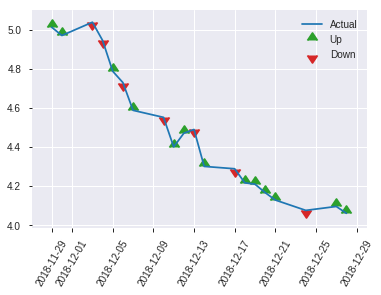


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20113930890193255
RMSE: 0.4484855726798049
LogLoss: 0.5837813973643585
Mean Per-Class Error: 0.29693094629156014
AUC: 0.7631074168797953
pr_auc: 0.7286466330849571
Gini: 0.5262148337595907
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42509945295332735: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   72   0.5294   (72.0/136.0)
1      15   100  0.1304   (15.0/115.0)
Total  79   172  0.3466   (87.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425099     0.696864  171
max f2                       0.168316     0.833333  223
max f0point5                 0.590757     0.703325  68
max accuracy                 0.567909     0.713147  90
max precision                0.886301     1         0
max recall                   0.119982     1         238
max specificity              0.886301     1         0
max absolute_mcc             0.567909     0.420932  90
max min_per_class_accuracy   0.523882     0.678261  118
max mean_per_class_accuracy  0.567909     0.703069  90

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 48.92 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.875892           2.18261    2.18261            1                0.881293  1                           0.881293            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.852359           2.18261    2.18261            1                0.862136  1                           0.871715            0.026087        0.0521739                  118.261   118.261
    3        0.0318725                   0.84159            2.18261    2.18261            1                0.844354  1                           0.864874            0.0173913       0.0695652                  118.261   118.261
    4        0.0438247                   0.821503           1.45507    1.98419            0.666667         0.832603  0.909091                    0.856073            0.0173913       0.0869565                  45.5072   98.419
    5        0.0517928                   0.816529           1.0913     1.84682            0.5              0.820717  0.846154                    0.850634            0.00869565      0.0956522                  9.13043   84.6823
    6        0.103586                    0.741213           1.84682    1.84682            0.846154         0.775021  0.846154                    0.812827            0.0956522       0.191304                   84.6823   84.6823
    7        0.151394                    0.677619           1.81884    1.83799            0.833333         0.694434  0.842105                    0.77544             0.0869565       0.278261                   81.8841   83.7986
    8        0.203187                    0.625844           1.67893    1.79744            0.769231         0.6472    0.823529                    0.742751            0.0869565       0.365217                   67.893    79.7442
    9        0.302789                    0.58386            1.30957    1.63696            0.6              0.597853  0.75                        0.695087            0.130435        0.495652                   30.9565   63.6957
    10       0.40239                     0.551773           1.13496    1.5127             0.52             0.568004  0.693069                    0.663631            0.113043        0.608696                   13.4957   51.2699
    11       0.501992                    0.513209           0.960348   1.40311            0.44             0.532084  0.642857                    0.63753             0.0956522       0.704348                   -3.96522  40.3106
    12       0.601594                    0.464558           0.873043   1.31535            0.4              0.490779  0.602649                    0.613234            0.0869565       0.791304                   -12.6957  31.5347
    13       0.701195                    0.422782           0.785739   1.24012            0.36             0.441646  0.568182                    0.588861            0.0782609       0.869565                   -21.4261  24.0119
    14       0.800797                    0.335584           0.61113    1.16189            0.28             0.390744  0.532338                    0.564219            0.0608696       0.930435                   -38.887   16.1886
    15       0.900398                    0.151115           0.61113    1.10096            0.28             0.26739   0.504425                    0.531384            0.0608696       0.991304                   -38.887   10.0962
    16       1                           0.0311672          0.0873043  1                  0.04             0.108045  0.458167                    

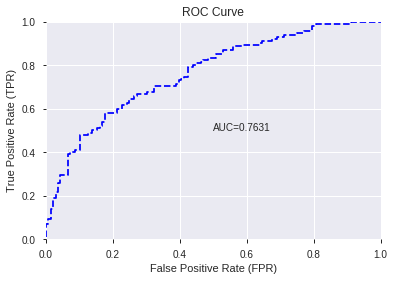

This function is available for GLM models only


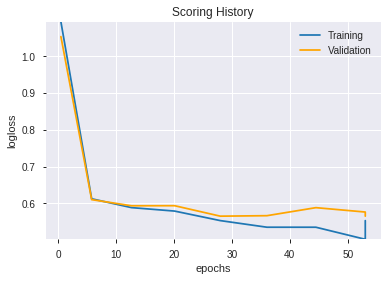

--2019-09-03 03:11:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_030311_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_030311_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLLONGLINE',
 'aroonup_30',
 'STOCHF_fastk',
 'aroonup_20',
 'ADX_8',
 'DX_8',
 'BETA_8',
 'STOCHRSI_fastk',
 'CORREL_8',
 'aroondown_14',
 'ADOSC',
 'CDLSPINNINGTOP',
 'CCI_20',
 'STOCH_slowk',
 'MINUS_DM_24',
 'CCI_12',
 'DX_12',
 'ROC_14',
 'AROONOSC_14',
 'PLUS_DI_8',
 'ATR_12',
 'SMA_20',
 'BBANDS_upperband_14_5_3',
 'WILLR_8',
 'ATR_24',
 'MOM_14',
 'MA_20_5',
 'BBANDS_middleband_20_6_5',
 'MOM_20',
 'CCI_14',
 'MOM_24',
 'MOM_8',
 'DEMA_20',
 'LINEARREG_SLOPE_8',
 'WILLR_20',
 'ROCR100_20',
 'CMO_30',
 'PLUS_DM_12',
 'MFI_8',
 'ROCP_24',
 'ROCR_12',
 'WILLR_30',
 'WILLR_14',
 'WILLR_12',
 'ROCP_8',
 'MACDFIX_hist_8',
 'MACDFIX_hist_24',
 'ROC_8',
 'ROCP_12',
 'RSI_14',
 'CMO_8']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_031156_model_1  0.747059  0.595321              0.312916  0.452613  0.204858

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.560893           1.000000    0.112762
1                     TRANGE             0.357321           0.637057    0.071836
2               STOCHF_fastk             0.316060           0.563494    0.063541
3                CDLLONGLINE             0.280536           0.500159    0.056399
4                MINUS_DM_24             0.201273           0.358843    0.040464
5                 aroonup_30             0.200250           0.357020    0.040258
6                     CCI_20             0.196863           0.350981    0.039577
7                      ADOSC             0.180075           0.321050    0.036202
8                     CCI_12             0.175320           0.312574    0.035246
9                  PLUS_DI_8             0.150024           0.267473    0.030161
10               STOCH_slowk             0.144179           0.257052    0.028986
11                  WILLR_14             0.136651           0.243631    0.027472
12                    CMO_30             0.133994           0.238894    0.026938
13                    BETA_8             0.127421           0.227175    0.025617
14                     DX_12             0.118863           0.211917    0.023896
15                   WILLR_8             0.114063           0.203360    0.022931
16            MACDFIX_hist_8             0.102117           0.182061    0.020530
17               AROONOSC_14             0.100461           0.179109    0.020197
18                    MOM_20             0.091332           0.162833    0.018361
19              aroondown_14             0.091147           0.162503    0.018324
20                PLUS_DM_12             0.090438           0.161239    0.018182
21                   ROCP_12             0.086762           0.154685    0.017443
22                   ROCR_12             0.086192           0.153668    0.017328
23                      DX_8             0.084532           0.150710    0.016994
24                  WILLR_20             0.079665           0.142032    0.016016
25                    ATR_24             0.075503           0.134612    0.015179
26                    CCI_14             0.068393           0.121935    0.013750
27                aroonup_20             0.064785           0.115503    0.013024
28           MACDFIX_hist_24             0.064240           0.114532    0.012915
29                   ROCP_24             0.049550           0.088342    0.009962
30                  WILLR_30             0.045986           0.081987    0.009245
31                  WILLR_12             0.043883           0.078238    0.008822
32                    MOM_24             0.040949           0.073007    0.008232
33                    MOM_14             0.039778           0.070918    0.007997
34         LINEARREG_SLOPE_8             0.034069           0.060740    0.006849
35                   DEMA_20             0.033563           0.059838    0.006747
36                    ROC_14             0.025744           0.045898    0.005176
37                ROCR100_20             0.024872           0.044344    0.005000
38            CDLSPINNINGTOP             0.022357           0.039859    0.004495
39                     CMO_8             0.022181           0.039546    0.004459
40                    ATR_12             0.018649           0.033249    0.003749
41                    SMA_20             0.013197           0.023528    0.002653
42  BBANDS_middleband_20_6_5             0.011349           0.020234    0.002282
43                    RSI_14             0.010775           0.019210    0.002166
44                     ADX_8             0.010692           0.019063    0.002150
45            STOCHRSI_fastk             0.009404           0.016766    0.001891
46                   MA_20_5             0.007871           0.014033    0.001582
47                     MFI_8             0.006646           0.011848    0.001336
48                     ROC_8             0.005909  

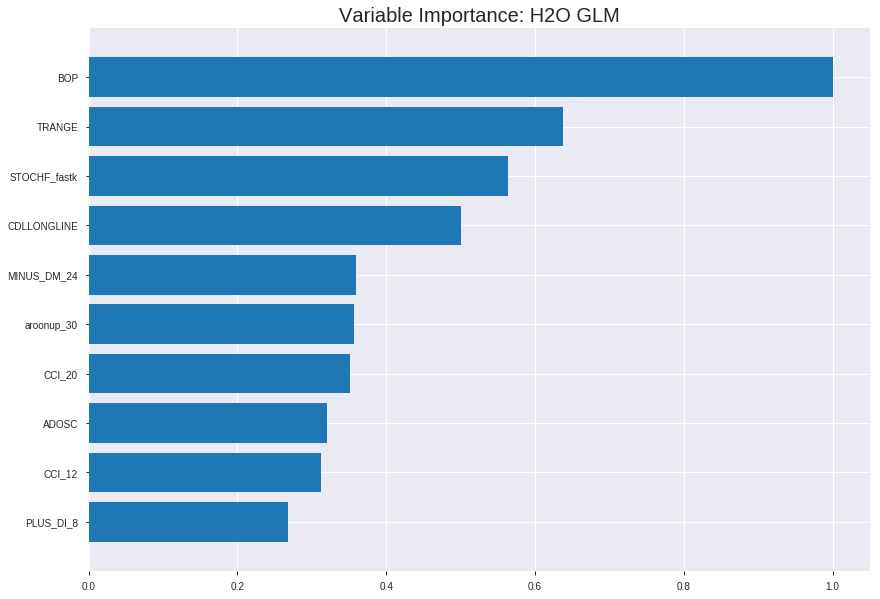

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_031156_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.194518716085399
RMSE: 0.4410427599285573
LogLoss: 0.5724582161151349
Null degrees of freedom: 1753
Residual degrees of freedom: 1700
Null deviance: 2429.507457396468
Residual deviance: 2008.1834221318932
AIC: 2116.183422131893
AUC: 0.7724103099466436
pr_auc: 0.7593612687732575
Gini: 0.5448206198932872
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4212601558887442: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      450  397   0.4687   (397.0/847.0)
1      136  771   0.1499   (136.0/907.0)
Total  586  1168  0.3039   (533.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42126      0.743133  243
max f2                       0.160695     0.8544    359
max f0point5                 0.587069     0.725495  157
max accuracy                 0.501327     0.708096  202
max precision                0.873544     0.886792  18
max recall                   0.0649351    1         392
max specificity              0.938946     0.998819  0
max absolute_mcc             0.501327     0.415158  202
max min_per_class_accuracy   0.53226      0.699008  186
max mean_per_class_accuracy  0.501327     0.706504  202

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.899411           1.5041    1.5041             0.777778         0.910307  0.777778                    0.910307            0.0154355       0.0154355                  50.4104    50.4104
    2        0.0205245                   0.886832           1.82641   1.66526            0.944444         0.892392  0.861111                    0.901349            0.0187431       0.0341786                  82.6412    66.5258
    3        0.0302166                   0.871973           1.82009   1.71492            0.941176         0.878469  0.886792                    0.89401             0.0176406       0.0518192                  82.0092    71.4922
    4        0.0404789                   0.862488           1.5041    1.66147            0.777778         0.867739  0.859155                    0.88735             0.0154355       0.0672547                  50.4104    66.1475
    5        0.050171                    0.856296           1.70634   1.67014            0.882353         0.859024  0.863636                    0.881878            0.016538        0.0837927                  70.6336    67.0141
    6        0.100342                    0.800422           1.64817   1.65915            0.852273         0.829102  0.857955                    0.85549             0.0826902       0.166483                   64.8166    65.9154
    7        0.149943                    0.750137           1.53374   1.61767            0.793103         0.774798  0.836502                    0.828797            0.076075        0.242558                   53.3741    61.7667
    8        0.200114                    0.7201             1.53829   1.59777            0.795455         0.736508  0.826211                    0.805659            0.0771775       0.319735                   53.8288    59.7766
    9        0.299886                    0.659955           1.39237   1.52943            0.72             0.686986  0.790875                    0.766177            0.13892         0.458655                   39.237     52.9431
    10       0.400228                    0.603584           1.32952   1.47931            0.6875           0.633479  0.764957                    0.732908            0.133407        0.592062                   32.952     47.9311
    11       0.5                         0.534441           1.01665   1.38699            0.525714         0.568108  0.717218                    0.700023            0.101433        0.693495                   1.66514    38.699
    12       0.599772                    0.464769           0.99455   1.32171            0.514286         0.501444  0.68346                     0.666989            0.0992282       0.792723                   -0.544968  32.1708
    13       0.700114                    0.391381           0.769144  1.24251            0.397727         0.428898  0.642508                    0.632866            0.0771775       0.869901                   -23.0856   24.2513
    14       0.799886                    0.312003           0.59673   1.16196            0.308571         0.354296  0.600855                    0.598119            0.0595369       0.929438                   -40.327    16.1963
    15       0.899658                    0.197644           0.497275  1.08825            0.257143         0.2544    0.562738                    0.56                0.0496141       0.979052                   -50.2725   8.8249
    16       1                           0.0196093          0.208768  1                  0.107955         0.132497  0.517104                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1920543058602652
RMSE: 0.43824000942436236
LogLoss: 0.5658435219530876
Null degrees of freedom: 501
Residual degrees of freedom: 448
Null deviance: 694.5911617977604
Residual deviance: 568.1068960409
AIC: 676.1068960409
AUC: 0.779484117506568
pr_auc: 0.7930646893186502
Gini: 0.558968235013136
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30756511588133945: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      77   160  0.6751   (160.0/237.0)
1      12   253  0.0453   (12.0/265.0)
Total  89   413  0.3426   (172.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.307565     0.746313  321
max f2                       0.272636     0.863698  330
max f0point5                 0.600014     0.735439  147
max accuracy                 0.517609     0.713147  208
max precision                0.914202     1         0
max recall                   0.0904878    1         394
max specificity              0.914202     1         0
max absolute_mcc             0.517609     0.423694  208
max min_per_class_accuracy   0.543819     0.696203  195
max mean_per_class_accuracy  0.517609     0.711361  208

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 51.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.898213           1.89434   1.89434            1                0.905082  1                           0.905082            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.884944           1.89434   1.89434            1                0.887614  1                           0.897142            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.869872           1.51547   1.77594            0.8              0.875945  0.9375                      0.890518            0.0150943       0.0566038                  51.5472   77.5943
    4        0.0418327                   0.860893           1.51547   1.71393            0.8              0.86522   0.904762                    0.884495            0.0150943       0.0716981                  51.5472   71.3926
    5        0.0517928                   0.845941           1.51547   1.67576            0.8              0.849088  0.884615                    0.877686            0.0150943       0.0867925                  51.5472   67.5762
    6        0.101594                    0.787716           1.81857   1.74576            0.96             0.810156  0.921569                    0.844583            0.090566        0.177358                   81.8566   74.5764
    7        0.151394                    0.747857           1.66702   1.71986            0.88             0.767698  0.907895                    0.819292            0.0830189       0.260377                   66.7019   71.9861
    8        0.201195                    0.709148           1.4397    1.65051            0.76             0.726363  0.871287                    0.79629             0.0716981       0.332075                   43.9698   65.0514
    9        0.300797                    0.64119            1.40181   1.56816            0.74             0.676858  0.827815                    0.756743            0.139623        0.471698                   40.1811   56.8162
    10       0.400398                    0.589049           1.17449   1.47023            0.62             0.612496  0.776119                    0.72086             0.116981        0.588679                   17.4491   47.0234
    11       0.5                         0.545521           0.985057  1.37358            0.52             0.568505  0.7251                      0.690511            0.0981132       0.686792                   -1.49434  37.3585
    12       0.599602                    0.486651           0.94717   1.30275            0.5              0.51628   0.687708                    0.661569            0.0943396       0.781132                   -5.28302  30.2752
    13       0.699203                    0.41652            0.757736  1.22511            0.4              0.452636  0.646724                    0.631806            0.0754717       0.856604                   -24.2264  22.5114
    14       0.798805                    0.333391           0.795623  1.17156            0.42             0.376755  0.618454                    0.600004            0.0792453       0.935849                   -20.4377  17.1562
    15       0.898406                    0.200167           0.416755  1.08788            0.22             0.26454   0.574279                    0.562813            0.0415094       0.977358                   -58.3245  8.78802
    16       1                           0.0379275          0.222863  1                  0.117647         0.136206  0.527888                    0.519473           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 03:11:57  0.000 sec   2            .21E2     54            1.3704368363058248  1.3677290841897416
     2019-09-03 03:11:57  0.014 sec   4            .13E2     54            1.3633232816425478  1.3599131184584403
     2019-09-03 03:11:57  0.028 sec   6            .8E1      54            1.353562319961551   1.349102689153177
     2019-09-03 03:11:57  0.041 sec   8            .49E1     54            1.3405972304868947  1.3346471305994778
     2019-09-03 03:11:57  0.055 sec   10           .31E1     54            1.3239571052313341  1.3159858626013452
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 03:11:57  0.303 sec   34           .1E-1     54            1.1415242689993104  1.1322177546559973
     2019-09-03 03:11:57  0.333 sec   36           .63E-2    54            1.1389247161941238  1.1333213640868023
     2019-09-03 03:11:57  0.356 sec   38           .39E-2    54            1.137012283112063   1.1347215153060595
     2019-09-03 03:11:57  0.383 sec   40           .24E-2    54            1.1357011957179817  1.1362130577866665
     2019-09-03 03:11:57  0.410 sec   42           .15E-2    54            1.1348663352632957  1.1375822738415473


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7131474103585658)

('F1', 0.6850393700787402)

('auc', 0.7470588235294118)

('logloss', 0.5953209104593591)

('mean_per_class_error', 0.29827365728900257)

('rmse', 0.4526125853270561)

('mse', 0.20485815239644167)

glm prediction progress: |████████████████████████████████████████████████| 100%


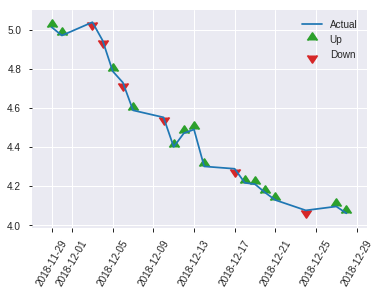


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20485815239644167
RMSE: 0.4526125853270561
LogLoss: 0.5953209104593591
Null degrees of freedom: 250
Residual degrees of freedom: 197
Null deviance: 349.69104234008756
Residual deviance: 298.85109705059824
AIC: 406.85109705059824
AUC: 0.7470588235294118
pr_auc: 0.701231553845118
Gini: 0.49411764705882355
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4995402952307629: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      84   52   0.3824   (52.0/136.0)
1      28   87   0.2435   (28.0/115.0)
Total  112  139  0.3187   (80.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49954      0.685039  138
max f2                       0.261711     0.828358  209
max f0point5                 0.605627     0.701944  86
max accuracy                 0.605627     0.713147  86
max precision                0.92148      1         0
max recall                   0.0898967    1         248
max specificity              0.92148      1         0
max absolute_mcc             0.605627     0.422405  86
max min_per_class_accuracy   0.537399     0.678261  119
max mean_per_class_accuracy  0.605627     0.701726  86

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 49.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.884629           2.18261   2.18261            1                0.900017  1                           0.900017            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.874179           1.45507   1.81884            0.666667         0.878049  0.833333                    0.889033            0.0173913       0.0434783                  45.5072   81.8841
    3        0.0318725                   0.844595           2.18261   1.90978            1                0.850874  0.875                       0.879493            0.0173913       0.0608696                  118.261   90.9783
    4        0.0438247                   0.838558           1.45507   1.78577            0.666667         0.840107  0.818182                    0.868751            0.0173913       0.0782609                  45.5072   78.5771
    5        0.0517928                   0.833241           2.18261   1.84682            1                0.834905  0.846154                    0.863544            0.0173913       0.0956522                  118.261   84.6823
    6        0.103586                    0.775845           1.67893   1.76288            0.769231         0.803936  0.807692                    0.83374             0.0869565       0.182609                   67.893    76.2876
    7        0.151394                    0.712271           1.45507   1.66568            0.666667         0.731769  0.763158                    0.801539            0.0695652       0.252174                   45.5072   66.5675
    8        0.203187                    0.684514           1.51104   1.62626            0.692308         0.698486  0.745098                    0.77527             0.0782609       0.330435                   51.1037   62.6257
    9        0.302789                    0.626299           1.57148   1.60824            0.72             0.652517  0.736842                    0.734891            0.156522        0.486957                   57.1478   60.8238
    10       0.40239                     0.569671           1.04765   1.46948            0.48             0.598405  0.673267                    0.701107            0.104348        0.591304                   4.76522   46.9479
    11       0.501992                    0.529945           0.960348  1.36846            0.44             0.546475  0.626984                    0.670426            0.0956522       0.686957                   -3.96522  36.8461
    12       0.601594                    0.455663           0.960348  1.30089            0.44             0.498132  0.596026                    0.641901            0.0956522       0.782609                   -3.96522  30.0893
    13       0.701195                    0.371855           0.785739  1.22772            0.36             0.407418  0.5625                      0.608594            0.0782609       0.86087                    -21.4261  22.7717
    14       0.800797                    0.303329           0.61113   1.15103            0.28             0.335803  0.527363                    0.574664            0.0608696       0.921739                   -38.887   15.1027
    15       0.900398                    0.185087           0.61113   1.0913             0.28             0.23951   0.5                         0.53759             0.0608696       0.982609                   -38.887   9.13043
    16       1                           0.0602571          0.174609  1                  0.08             0.13356   0.458167                    0.497348         

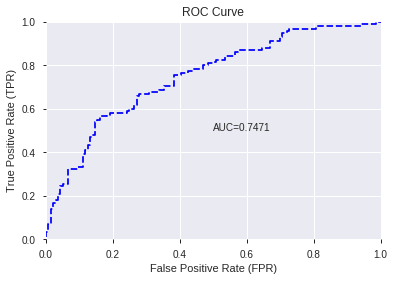

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


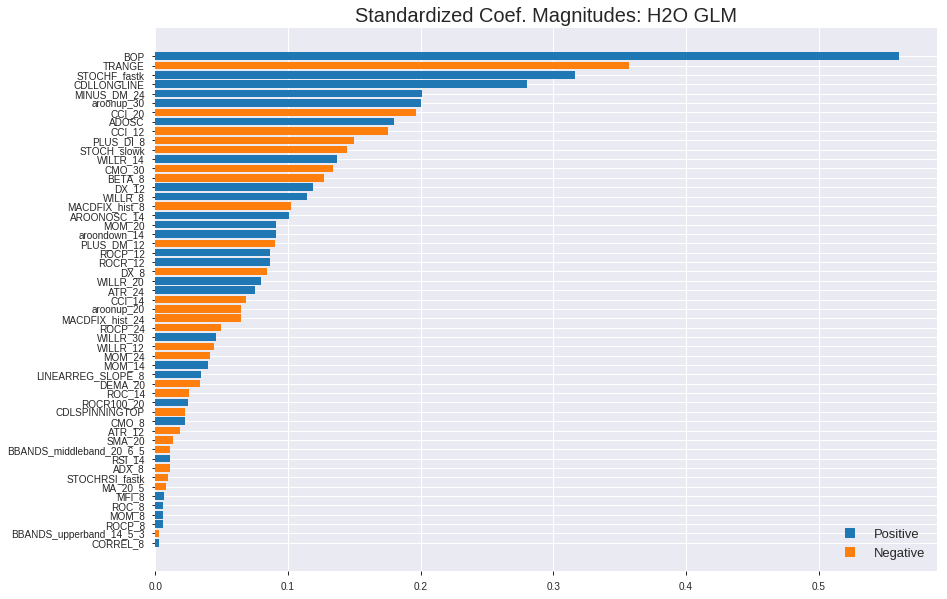

'log_likelihood'
--2019-09-03 03:12:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_031156_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_031156_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'MINUS_DM_24',
 'aroonup_30',
 'CCI_20',
 'ADOSC',
 'CCI_12',
 'PLUS_DI_8',
 'STOCH_slowk',
 'WILLR_14',
 'CMO_30',
 'BETA_8',
 'DX_12',
 'WILLR_8',
 'MACDFIX_hist_8',
 'AROONOSC_14',
 'MOM_20',
 'aroondown_14',
 'PLUS_DM_12',
 'ROCP_12',
 'ROCR_12',
 'DX_8',
 'WILLR_20',
 'ATR_24',
 'CCI_14',
 'aroonup_20',
 'MACDFIX_hist_24',
 'ROCP_24',
 'WILLR_30',
 'WILLR_12',
 'MOM_24',
 'MOM_14',
 'LINEARREG_SLOPE_8',
 'DEMA_20',
 'ROC_14',
 'ROCR100_20',
 'CDLSPINNINGTOP',
 'CMO_8',
 'ATR_12',
 'SMA_20',
 'BBANDS_middleband_20_6_5',
 'RSI_14',
 'ADX_8',
 'STOCHRSI_fastk',
 'MA_20_5',
 'MFI_8',
 'ROC_8',
 'MOM_8',
 'ROCP_8',
 'BBANDS_upperband_14_5_3',
 'CORREL_8']

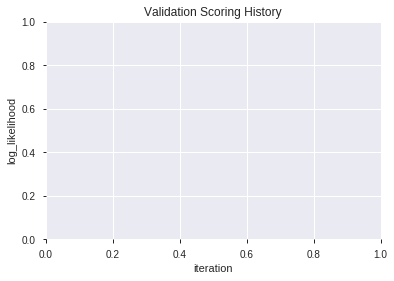

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_031208_model_4  0.760358  0.586220              0.326247  0.449038  0.201636
1  XGBoost_grid_1_AutoML_20190903_031208_model_3  0.759079  0.585289              0.320205  0.449276  0.201849
2  XGBoost_grid_1_AutoML_20190903_031208_model_6  0.754668  0.591422              0.308184  0.452081  0.204377
3  XGBoost_grid_1_AutoML_20190903_031208_model_2  0.751151  0.595695              0.324904  0.453761  0.205899
4               XGBoost_3_AutoML_20190903_031208  0.750064  0.596972              0.322570  0.454814  0.206856
5  XGBoost_grid_1_AutoML_20190903_031208_model_1  0.746547  0.596526              0.326566  0.454629  0.206687
6  XGBoost_grid_1_AutoML_20190903_031208_model_7  0.737084  0.607857              0.337276  0.459762  0.211381
7               XGBoost_2_AutoML_20190903_031208  0.735934  0.605505              0.327941  0.458912  0.210601
8               XGBoost_1_AutoML_20190903_031208  0.724680  0.618219              0.325927  0.464051  0.215344
9  XGBoost_grid_1_AutoML_20190903_031208_model_5  0.717199  0.647282              0.372347  0.475662  0.226254

variable  relative_importance  scaled_importance  percentage
0                        BOP          2140.427246           1.000000    0.392286
1               STOCHF_fastk           446.256622           0.208490    0.081788
2                     TRANGE           398.557281           0.186205    0.073046
3                   WILLR_14           148.814301           0.069526    0.027274
4                      ADOSC           146.549088           0.068467    0.026859
5                STOCH_slowk           146.289062           0.068346    0.026811
6                     CCI_12           109.514740           0.051165    0.020071
7                   CORREL_8           104.412971           0.048781    0.019136
8                     CCI_20            91.890862           0.042931    0.016841
9                     BETA_8            89.769936           0.041940    0.016453
10                   ROCP_12            80.100029           0.037422    0.014680
11               MINUS_DM_24            78.069611           0.036474    0.014308
12                aroonup_30            70.892555           0.033121    0.012993
13                   WILLR_8            65.722763           0.030705    0.012045
14                     ROC_8            64.218742           0.030003    0.011770
15                 PLUS_DI_8            61.272511           0.028626    0.011230
16                PLUS_DM_12            59.997536           0.028031    0.010996
17                    MOM_24            58.697590           0.027423    0.010758
18                ROCR100_20            58.377296           0.027274    0.010699
19                  WILLR_12            55.827770           0.026083    0.010232
20                     DX_12            55.289261           0.025831    0.010133
21                    CCI_14            53.843201           0.025155    0.009868
22                     ADX_8            51.520531           0.024070    0.009442
23            STOCHRSI_fastk            50.036617           0.023377    0.009170
24         LINEARREG_SLOPE_8            49.551376           0.023150    0.009082
25                     CMO_8            46.365398           0.021662    0.008498
26                      DX_8            45.993973           0.021488    0.008430
27           MACDFIX_hist_24            44.983524           0.021016    0.008244
28            MACDFIX_hist_8            44.511822           0.020796    0.008158
29                     MFI_8            38.254726           0.017872    0.007011
30                   DEMA_20            37.711407           0.017619    0.006912
31  BBANDS_middleband_20_6_5            37.431290           0.017488    0.006860
32                    RSI_14            35.229950           0.016459    0.006457
33                    CMO_30            34.578346           0.016155    0.006337
34                aroonup_20            32.908409           0.015375    0.006031
35                    ATR_24            30.839245           0.014408    0.005652
36                    SMA_20            30.484476           0.014242    0.005587
37                     MOM_8            29.997906           0.014015    0.005498
38                  WILLR_20            29.283497           0.013681    0.005367
39                    MOM_20            29.119186           0.013604    0.005337
40                    ATR_12            27.253235           0.012733    0.004995
41              aroondown_14            25.475531           0.011902    0.004669
42               AROONOSC_14            20.936451           0.009781    0.003837
43                  WILLR_30            20.447388           0.009553    0.003747
44   BBANDS_upperband_14_5_3            19.907856           0.009301    0.003649
45                   ROCP_24            18.768585           0.008769    0.003440
46                    ROC_14            18.416946           0.008604    0.003375
47               CDLLONGLINE             8.106953           0.003788    0.001486
48                   MA_20_5             6.746897  

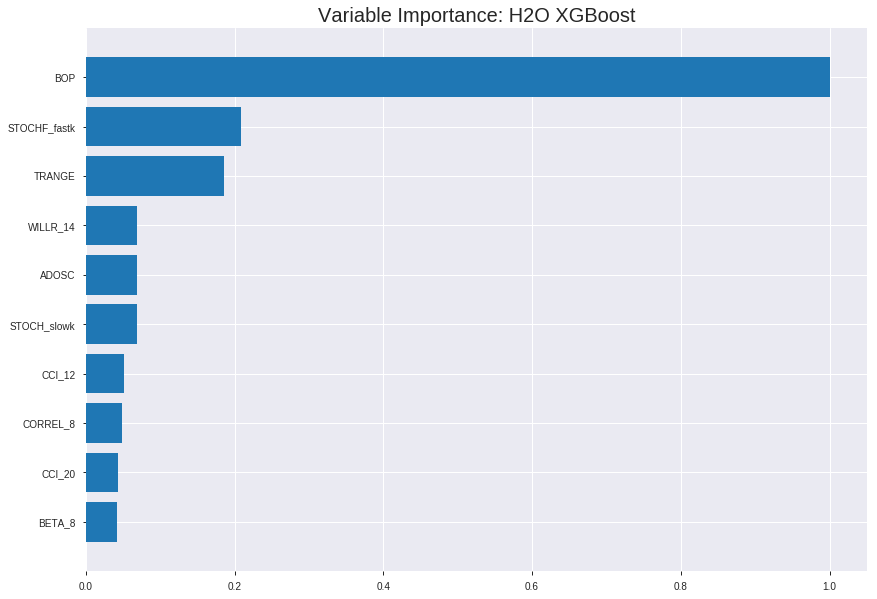

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_031208_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17381007856196004
RMSE: 0.41690535923871264
LogLoss: 0.5254861451939367
Mean Per-Class Error: 0.243396825686091
AUC: 0.8296770884723176
pr_auc: 0.8312804912499993
Gini: 0.6593541769446352
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4018692870934804: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      466  381   0.4498   (381.0/847.0)
1      98   809   0.108    (98.0/907.0)
Total  564  1190  0.2731   (479.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401869     0.771578  258
max f2                       0.270648     0.865933  321
max f0point5                 0.605562     0.779447  149
max accuracy                 0.5352       0.756556  188
max precision                0.898051     1         0
max recall                   0.163215     1         372
max specificity              0.898051     1         0
max absolute_mcc             0.556698     0.513032  177
max min_per_class_accuracy   0.533201     0.755608  189
max mean_per_class_accuracy  0.5352       0.756603  188

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 51.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.868683           1.93385   1.93385            1                0.880231  1                           0.880231            0.0198456       0.0198456                  93.3848   93.3848
    2        0.0205245                   0.86124            1.82641   1.88013            0.944444         0.864612  0.972222                    0.872422            0.0187431       0.0385888                  82.6412   88.013
    3        0.0302166                   0.851876           1.82009   1.86087            0.941176         0.856168  0.962264                    0.867208            0.0176406       0.0562293                  82.0092   86.0872
    4        0.0404789                   0.843545           1.82641   1.85214            0.944444         0.846731  0.957746                    0.862017            0.0187431       0.0749724                  82.6412   85.2136
    5        0.050171                    0.836096           1.70634   1.82397            0.882353         0.839808  0.943182                    0.857727            0.016538        0.0915105                  70.6336   82.397
    6        0.100342                    0.791416           1.84595   1.83496            0.954545         0.81441   0.948864                    0.836068            0.092613        0.184123                   84.5946   83.4958
    7        0.149943                    0.752785           1.62265   1.76473            0.83908          0.774436  0.912548                    0.81568             0.0804851       0.264609                   62.2654   76.4728
    8        0.200114                    0.723645           1.60421   1.72449            0.829545         0.736176  0.891738                    0.795748            0.0804851       0.345094                   60.4215   72.4485
    9        0.299886                    0.665079           1.48077   1.6434             0.765714         0.693997  0.84981                     0.761895            0.14774         0.492834                   48.0775   64.3403
    10       0.400228                    0.607135           1.45039   1.59501            0.75             0.635476  0.824786                    0.730201            0.145535        0.638368                   45.0386   59.5011
    11       0.5                         0.540664           1.06085   1.48842            0.548571         0.574899  0.769669                    0.699211            0.105843        0.744212                   6.08537   48.8423
    12       0.599772                    0.472061           0.79564   1.37318            0.411429         0.505841  0.710076                    0.667044            0.0793826       0.823594                   -20.436   37.3179
    13       0.700114                    0.380057           0.824083  1.29448            0.426136         0.425788  0.669381                    0.632467            0.0826902       0.906284                   -17.5917  29.4481
    14       0.799886                    0.295168           0.508326  1.19642            0.262857         0.337661  0.618674                    0.595695            0.0507166       0.957001                   -49.1674  19.6422
    15       0.899658                    0.202422           0.320466  1.09928            0.165714         0.249821  0.568441                    0.557337            0.0319735       0.988975                   -67.9534  9.92785
    16       1                           0.102318           0.109878  1                  0.0568182        0.159047  0.517104                    0.517372           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19382305833810531
RMSE: 0.4402534024151379
LogLoss: 0.5701119551112137
Mean Per-Class Error: 0.2825332377995382
AUC: 0.7763315022689277
pr_auc: 0.7833573388450766
Gini: 0.5526630045378553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3368340730667114: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   151  0.6371   (151.0/237.0)
1      17   248  0.0642   (17.0/265.0)
Total  103  399  0.3347   (168.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336834     0.746988  314
max f2                       0.244303     0.86856   359
max f0point5                 0.540694     0.731707  211
max accuracy                 0.540694     0.719124  211
max precision                0.878078     1         0
max recall                   0.162648     1         385
max specificity              0.878078     1         0
max absolute_mcc             0.540694     0.435784  211
max min_per_class_accuracy   0.554354     0.708861  200
max mean_per_class_accuracy  0.540694     0.717467  211

Gains/Lift Table: Avg response rate: 52.79 %, avg score: 53.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.861956           1.89434   1.89434            1                0.870653  1                           0.870653            0.0226415       0.0226415                  89.434    89.434
    2        0.0219124                   0.854234           1.89434   1.89434            1                0.856166  1                           0.864068            0.0188679       0.0415094                  89.434    89.434
    3        0.0318725                   0.833692           1.51547   1.77594            0.8              0.843464  0.9375                      0.857629            0.0150943       0.0566038                  51.5472   77.5943
    4        0.0418327                   0.830711           1.89434   1.80413            1                0.831872  0.952381                    0.851497            0.0188679       0.0754717                  89.434    80.4133
    5        0.0517928                   0.823229           1.89434   1.82148            1                0.825891  0.961538                    0.846573            0.0188679       0.0943396                  89.434    82.148
    6        0.101594                    0.778988           1.51547   1.67148            0.8              0.79441   0.882353                    0.821003            0.0754717       0.169811                   51.5472   67.1476
    7        0.151394                    0.738764           1.59125   1.64508            0.84             0.759529  0.868421                    0.800781            0.0792453       0.249057                   59.1245   64.5084
    8        0.201195                    0.713967           1.51547   1.613              0.8              0.725667  0.851485                    0.782189            0.0754717       0.324528                   51.5472   61.3002
    9        0.300797                    0.663036           1.28815   1.50544            0.68             0.687194  0.794702                    0.750733            0.128302        0.45283                    28.8151   50.5435
    10       0.400398                    0.612036           1.21238   1.43254            0.64             0.637712  0.756219                    0.722619            0.120755        0.573585                   21.2377   43.2535
    11       0.5                         0.558255           1.21238   1.38868            0.64             0.58608   0.733068                    0.69542             0.120755        0.69434                    21.2377   38.8679
    12       0.599602                    0.515461           0.909283  1.30905            0.48             0.537603  0.69103                     0.669204            0.090566        0.784906                   -9.0717   30.9045
    13       0.699203                    0.429605           0.795623  1.23591            0.42             0.477877  0.652422                    0.64195             0.0792453       0.864151                   -20.4377  23.5908
    14       0.798805                    0.332812           0.719849  1.17156            0.38             0.379927  0.618454                    0.609278            0.0716981       0.935849                   -28.0151  17.1562
    15       0.898406                    0.246081           0.492528  1.09628            0.26             0.292204  0.578714                    0.574126            0.0490566       0.984906                   -50.7472  9.62808
    16       1                           0.0933049          0.148576  1                  0.0784314        0.180288  0.527888                    0.534115            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:12:18  4.185 sec   0                  0.5              0.693147            0.5             0                  1                0.482896                         0.5                0.693147              0.5               0                    1                  0.472112
    2019-09-03 03:12:18  4.296 sec   5                  0.479056         0.651897            0.776455        0.703754           1.82788          0.312999                         0.4812             0.656051              0.759326          0.706841             1.77594            0.302789
    2019-09-03 03:12:18  4.352 sec   10                 0.464705         0.623832            0.784509        0.785753           1.87525          0.321551                         0.46986            0.633691              0.758459          0.759696             1.57862            0.322709
    2019-09-03 03:12:18  4.417 sec   15                 0.454842         0.604268            0.788105        0.780264           1.85327          0.281072                         0.460745           0.615493              0.76892           0.772952             1.62372            0.332669
    2019-09-03 03:12:18  4.481 sec   20                 0.447306         0.58907             0.792203        0.790925           1.93385          0.282782                         0.454093           0.601987              0.774063          0.779242             1.89434            0.284861
    2019-09-03 03:12:19  4.547 sec   25                 0.441894         0.577815            0.79697         0.794097           1.93385          0.27195                          0.450131           0.593492              0.775711          0.779493             1.62372            0.322709
    2019-09-03 03:12:19  4.623 sec   30                 0.437484         0.568703            0.801857        0.801204           1.82641          0.277651                         0.448614           0.589881              0.77165           0.77406              1.57862            0.330677
    2019-09-03 03:12:19  4.686 sec   35                 0.433813         0.560906            0.805701        0.805792           1.82641          0.283352                         0.445899           0.583784              0.773203          0.776778             1.57862            0.320717
    2019-09-03 03:12:19  4.752 sec   40                 0.430863         0.554721            0.809589        0.809693           1.93385          0.286203                         0.444088           0.579707              0.775583          0.781148             1.57862            0.330677
    2019-09-03 03:12:19  4.828 sec   45                 0.428267         0.549185            0.812616        0.813528           1.93385          0.283352                         0.443198           0.577559              0.775193          0.782128             1.89434            0.324701
    2019-09-03 03:12:19  4.902 sec   50                 0.425864         0.544178            0.816031        0.817834           1.93385          0.276511                         0.442978           0.576636              0.772797          0.776615             1.89434            0.318725
    2019-09-03 03:12:19  4.978 sec   55                 0.4235           0.539268            0.819575        0.821122           1.93385          0.278221                         0.441889           0.574199              0.775161          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2140.42724609375       1.0                    0.3922864173945713
STOCHF_fastk  446.2566223144531      0.2084895074704666     0.08178760194994805
TRANGE        398.5572814941406      0.18620454501385278    0.07304551386607049
WILLR_14      148.81430053710938     0.06952551216524337    0.027273914084826004
ADOSC         146.54908752441406     0.06846721269870962    0.026858757578568895
---           ---                    ---                    ---
ROCP_24       18.768585205078125     0.008768616284122963   0.0034398090676062954
ROC_14        18.416946411132812     0.008604331889693277   0.0033753625310816372
CDLLONGLINE   8.106952667236328      0.0037875394653246936  0.001485800287592774
MA_20_5       6.746896743774414      0.003152126172981309   0.0012365362835744984
MOM_14        6.634420394897461      0.0030995776226476215  0.0012159222010248178


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.6993006993006993)

('auc', 0.7603580562659847)

('logloss', 0.5862195262710237)

('mean_per_class_error', 0.2965473145780051)

('rmse', 0.44903847770216176)

('mse', 0.20163555445707484)

xgboost prediction progress: |████████████████████████████████████████████| 100%


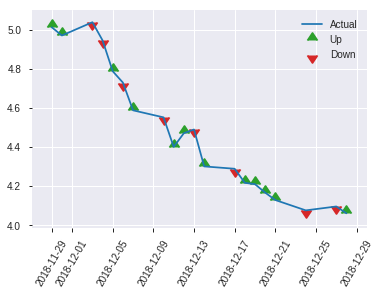


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20163555445707484
RMSE: 0.44903847770216176
LogLoss: 0.5862195262710237
Mean Per-Class Error: 0.2965473145780051
AUC: 0.7603580562659847
pr_auc: 0.7197701025648945
Gini: 0.5207161125319695
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4018120765686035: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   71   0.5221   (71.0/136.0)
1      15   100  0.1304   (15.0/115.0)
Total  80   171  0.3426   (86.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401812     0.699301  170
max f2                       0.304249     0.833333  205
max f0point5                 0.639605     0.68323   91
max accuracy                 0.639605     0.701195  91
max precision                0.881179     1         0
max recall                   0.195581     1         233
max specificity              0.881179     1         0
max absolute_mcc             0.546093     0.405559  127
max min_per_class_accuracy   0.581235     0.686957  118
max mean_per_class_accuracy  0.546093     0.703453  127

Gains/Lift Table: Avg response rate: 45.82 %, avg score: 51.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.861311           2.18261   2.18261            1                0.875681  1                           0.875681            0.026087        0.026087                   118.261   118.261
    2        0.0239044                   0.848848           2.18261   2.18261            1                0.851148  1                           0.863414            0.026087        0.0521739                  118.261   118.261
    3        0.0318725                   0.834051           1.0913    1.90978            0.5              0.84005   0.875                       0.857573            0.00869565      0.0608696                  9.13043   90.9783
    4        0.0438247                   0.826796           2.18261   1.98419            1                0.830714  0.909091                    0.850248            0.026087        0.0869565                  118.261   98.419
    5        0.0517928                   0.820236           2.18261   2.01472            1                0.823624  0.923077                    0.846152            0.0173913       0.104348                   118.261   101.472
    6        0.103586                    0.771025           1.84682   1.93077            0.846154         0.797284  0.884615                    0.821718            0.0956522       0.2                        84.6823   93.0769
    7        0.151394                    0.726066           1.63696   1.83799            0.75             0.746489  0.842105                    0.797961            0.0782609       0.278261                   63.6957   83.7986
    8        0.203187                    0.694891           1.34314   1.71185            0.615385         0.708777  0.784314                    0.775228            0.0695652       0.347826                   34.3144   71.185
    9        0.302789                    0.655969           1.13496   1.52208            0.52             0.671287  0.697368                    0.741037            0.113043        0.46087                    13.4957   52.2082
    10       0.40239                     0.62268            1.48417   1.5127             0.68             0.640951  0.693069                    0.716263            0.147826        0.608696                   48.4174   51.2699
    11       0.501992                    0.560258           1.04765   1.42043            0.48             0.589571  0.650794                    0.691126            0.104348        0.713043                   4.76522   42.0428
    12       0.601594                    0.472596           0.61113   1.28644            0.28             0.510957  0.589404                    0.661297            0.0608696       0.773913                   -38.887   28.6438
    13       0.701195                    0.388705           1.04765   1.25252            0.48             0.42711   0.573864                    0.628032            0.104348        0.878261                   4.76522   25.252
    14       0.800797                    0.320105           0.61113   1.17274            0.28             0.353421  0.537313                    0.593876            0.0608696       0.93913                    -38.887   17.2745
    15       0.900398                    0.220379           0.436522  1.0913             0.2              0.266907  0.5                         0.557707            0.0434783       0.982609                   -56.3478  9.13043
    16       1                           0.099446           0.174609  1                  0.08             0.171045  0.458167                    0.519195            

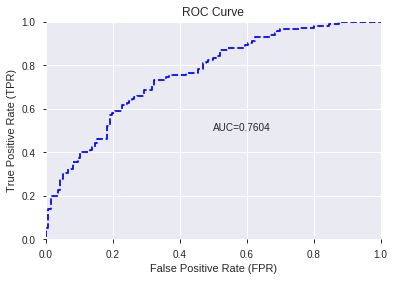

This function is available for GLM models only


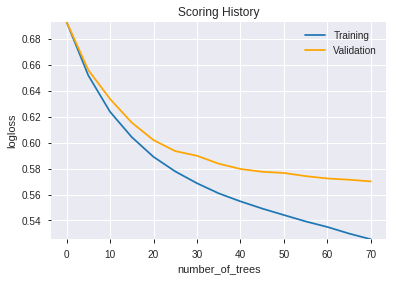

--2019-09-03 03:12:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_031208_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_031208_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_87ca',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'WILLR_14',
 'ADOSC',
 'STOCH_slowk',
 'CCI_12',
 'CORREL_8',
 'CCI_20',
 'BETA_8',
 'ROCP_12',
 'MINUS_DM_24',
 'aroonup_30',
 'WILLR_8',
 'ROC_8',
 'PLUS_DI_8',
 'PLUS_DM_12',
 'MOM_24',
 'ROCR100_20',
 'WILLR_12',
 'DX_12',
 'CCI_14',
 'ADX_8',
 'STOCHRSI_fastk',
 'LINEARREG_SLOPE_8',
 'CMO_8',
 'DX_8',
 'MACDFIX_hist_24',
 'MACDFIX_hist_8',
 'MFI_8',
 'DEMA_20',
 'BBANDS_middleband_20_6_5',
 'RSI_14',
 'CMO_30',
 'aroonup_20',
 'ATR_24',
 'SMA_20',
 'MOM_8',
 'WILLR_20',
 'MOM_20',
 'ATR_12',
 'aroondown_14',
 'AROONOSC_14',
 'WILLR_30',
 'BBANDS_upperband_14_5_3',
 'ROCP_24',
 'ROC_14',
 'CDLLONGLINE',
 'MA_20_5',
 'MOM_14']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.729
GLM             0.713
XGBoost         0.721
dtype: float64

DeepLearning    GLM  XGBoost
All          0.705  0.701    0.721
DLF          0.717  0.701    0.677
Fwe          0.717  0.697    0.685
RFE          0.713  0.713    0.701
XGBF         0.729  0.701    0.677





F1


DeepLearning    0.717
GLM             0.714
XGBoost         0.703
dtype: float64

DeepLearning    GLM  XGBoost
All          0.710  0.703    0.703
DLF          0.703  0.714    0.702
Fwe          0.695  0.690    0.690
RFE          0.697  0.685    0.699
XGBF         0.717  0.714    0.702





auc


DeepLearning    0.769
GLM             0.762
XGBoost         0.762
dtype: float64

DeepLearning    GLM  XGBoost
All          0.763  0.762    0.762
DLF          0.766  0.759    0.741
Fwe          0.760  0.750    0.740
RFE          0.763  0.747    0.760
XGBF         0.769  0.759    0.741





logloss


DeepLearning    0.615
GLM             0.610
XGBoost         0.610
dtype: float64

DeepLearning    GLM  XGBoost
All          0.603  0.608    0.598
DLF          0.615  0.610    0.610
Fwe          0.595  0.599    0.607
RFE          0.584  0.595    0.586
XGBF         0.602  0.610    0.610





mean_per_class_error


DeepLearning    0.306
GLM             0.310
XGBoost         0.325
dtype: float64

DeepLearning    GLM  XGBoost
All          0.306  0.295    0.288
DLF          0.282  0.293    0.325
Fwe          0.288  0.310    0.323
RFE          0.297  0.298    0.297
XGBF         0.282  0.293    0.325





rmse


DeepLearning    0.464
GLM             0.460
XGBoost         0.461
dtype: float64

DeepLearning    GLM  XGBoost
All          0.458  0.459    0.455
DLF          0.464  0.460    0.461
Fwe          0.452  0.455    0.460
RFE          0.448  0.453    0.449
XGBF         0.456  0.460    0.461





mse


DeepLearning    0.216
GLM             0.212
XGBoost         0.212
dtype: float64

DeepLearning    GLM  XGBoost
All          0.210  0.210    0.207
DLF          0.216  0.212    0.212
Fwe          0.205  0.207    0.212
RFE          0.201  0.205    0.202
XGBF         0.208  0.212    0.212

{'F1':       DeepLearning    GLM  XGBoost
 All          0.710    NaN      NaN
 DLF          0.703    NaN      NaN
 DLF            NaN  0.714      NaN
 DLF            NaN    NaN    0.702
 All            NaN  0.703      NaN
 All            NaN    NaN    0.703
 XGBF         0.717    NaN      NaN
 XGBF           NaN  0.714      NaN
 XGBF           NaN    NaN    0.702
 Fwe          0.695    NaN      NaN
 Fwe            NaN  0.690      NaN
 Fwe            NaN    NaN    0.690
 RFE          0.697    NaN      NaN
 RFE            NaN  0.685      NaN
 RFE            NaN    NaN    0.699,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.705    NaN      NaN
 DLF          0.717    NaN      NaN
 DLF            NaN  0.701      NaN
 DLF            NaN    NaN    0.677
 All            NaN  0.701      NaN
 All            NaN    NaN    0.721
 XGBF         0.729    NaN      NaN
 XGBF           NaN  0.701      NaN
 XGBF           NaN    NaN    0.677
 Fwe          0.717    NaN      NaN
 Fwe     